<div style="background: linear-gradient(45deg,  #FF8C00, #FFD700, #006400); padding: 18px; border-radius: 10px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 32px;"> LSTM MODEL for GOOGLE STOCK FORECASTING</h1>  
    
</div>

<div style="background: linear-gradient(45deg, #FF8C00, #006400); padding: 18px; border-radius: 20px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> Setting To Obtain Stable Results</h1>  
    
</div>

In [1]:
import tensorflow as tf
import os
import numpy as np
import random

SEED = 0

2024-09-07 00:37:50.125814: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [3]:
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed = SEED)

## Important !

1. Please run cells above before executing any other code.
2. Model training might become slower since the code is deterministic -- a tradeoff.
3. The code belongs to stack overflow user Dan to [Question](https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed)

<div style="background: linear-gradient(45deg, #FF8C00, #006400); padding: 18px; border-radius: 20px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> Importing Libraries</h1>  
    
</div>

In [ ]:
# Following commands might be needed for installations. Restart kernel after installations!

# conda install -c anaconda pandas-datareader
# !pip install yfinance
# !pip install pandas-ta

In [4]:
# Import libraries
import pandas as pd
import numpy as np
import pandas_ta

import matplotlib.pyplot as plt
import seaborn as sns

# For reading stock data from yahoo
import pandas_datareader as pdr
import yfinance as yf

# For time stamps
from datetime import datetime

# For scaler and model evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score

# For model building
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

<div style="background: linear-gradient(45deg, #FF8C00, #006400); padding: 18px; border-radius: 20px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> Loading Dataset</h1>  
    
</div>

## !!! Downloading data from yahoo finance and feature engineering were conducted as protocol in the Apple Model notebook. To minimize the code cluster, I will import the saved csv.

In [5]:
df_google = pd.read_csv('google-stock-price-20-yr.csv', delimiter = ',', index_col = 'date')
df_google.index = pd.to_datetime(df_google.index)
df_google.head(5)

open      high       low     close  adj_close     volume  \
date                                                                       
2004-08-23  2.758411  2.826406  2.716070  2.724787   2.721690  366857939   
2004-08-24  2.770615  2.779581  2.579581  2.611960   2.608991  306396159   
2004-08-25  2.614201  2.689918  2.587302  2.640104   2.637103  184645512   
2004-08-26  2.613952  2.688672  2.606729  2.687676   2.684621  142572401   
2004-08-27  2.692408  2.705360  2.632383  2.643840   2.640835  124826132   

            garman_klass_volatility  dollar_volume        obv      macd  \
date                                                                      
2004-08-23                 0.000723     998.473562          0  0.000000   
2004-08-24                 0.001392     799.384793 -306396159 -0.009000   
2004-08-25                 0.000727     486.929249 -121750647 -0.013704   
2004-08-26                 0.000204     382.752875   20821754 -0.013439   
2004-08-27                 0.000229     329.645194 -104004378 -0.016574   

            ma_3_days  ma_5_days  ma_10_days  ma_12_days  ma_20_days  
date                                                                  
2004-08-23        NaN        NaN         NaN         NaN         NaN  
2004-08-24        NaN        NaN         NaN         NaN         NaN  
2004-08-25   2.655928        NaN         NaN         NaN         NaN  
2004-08-26   2.643572        NaN         NaN         NaN         NaN  
2004-08-27   2.654186   2.658648         NaN         NaN         NaN

<div style="background: linear-gradient(45deg,  #FF8C00, #FFD700, #006400); padding: 18px; border-radius: 10px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 32px;"> DATA VISUALIZATION: TRENDS & RELATIONS </h1>  
    
</div>

### Hence plotting 20 years challenges the interpretation of the stock's performance and movement over time; graphs will be plotted seperately based on time intervals.

***
**interval 1** = 2004-2008

**interval 2** = 2008-2012 -- *real estate crisis & recovery* 

**interval 3** = 2012-2019 -- *till emergence of Covid-19*

**interval 4** = 2019-2022 -- *Covid-19 period*

**interval 5** = 2022-2024 -- *post Covid-19 & recovery period*
***

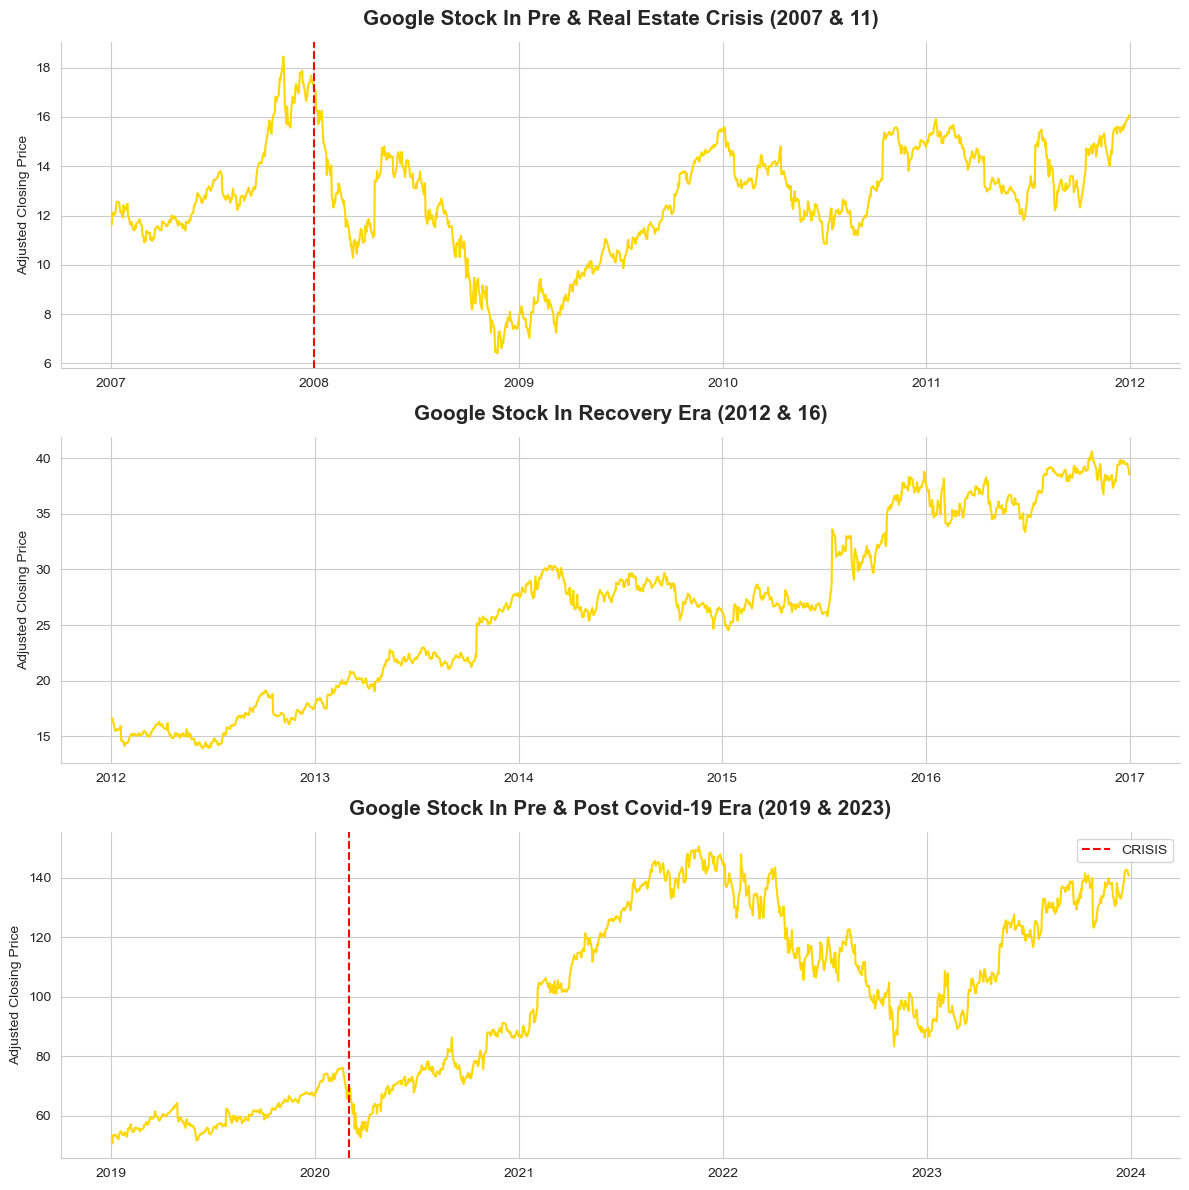

In [6]:
# Historical view on Adjusted Closing Prices during particular intervals (see code)

sns.set_style('whitegrid')
fig, axs = plt.subplots(3, 1, figsize = (12, 12))

axs[0].plot(df_google.loc['2007': '2011', 'adj_close'], color = 'gold')
axs[0].set_title('Google Stock In Pre & Real Estate Crisis (2007 & 11)',
                 fontsize = 15, fontweight = 'bold', pad = 12)
axs[0].axvline(x = pd.to_datetime('2008-01'), color = 'red', linestyle = '--', label = 'Year 2008')


axs[1].plot(df_google.loc['2012': '2016', 'adj_close'], color = 'gold')
axs[1].set_title('Google Stock In Recovery Era (2012 & 16)',
                 fontsize = 15, fontweight = 'bold', pad = 12)


axs[2].plot(df_google.loc['2019': '2023', 'adj_close'], color = 'gold')
axs[2].set_title('Google Stock In Pre & Post Covid-19 Era (2019 & 2023)',
                 fontsize = 15, fontweight = 'bold', pad = 12)
axs[2].axvline(x = pd.to_datetime('2020-03'), color = 'red', linestyle = '--', label = 'CRISIS')

for ax in axs.flat:
    ax.set(ylabel = 'Adjusted Closing Price')


plt.tight_layout()
plt.legend()
sns.despine()
plt.show()

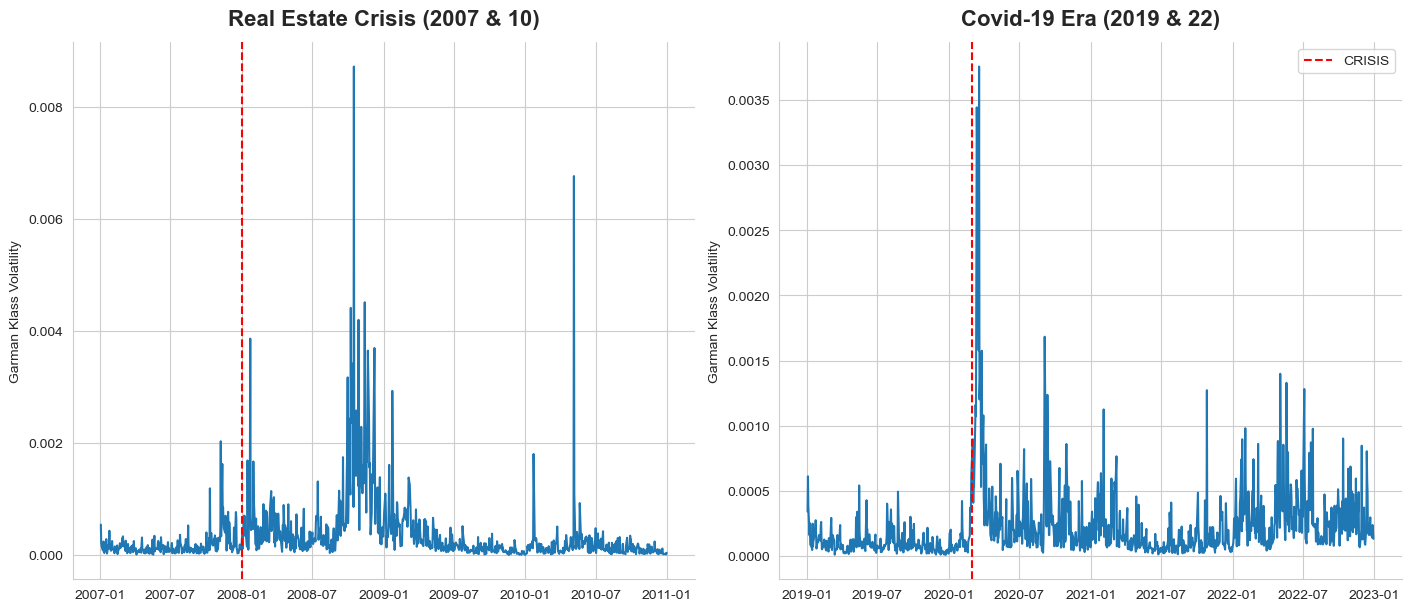

In [7]:
sns.set_style('whitegrid')
fig, axs = plt.subplots(1, 2, figsize = (14, 6), layout = 'constrained')

axs[0].plot(df_google.loc['2007': '2010', 'garman_klass_volatility'])
axs[0].set_title('Real Estate Crisis (2007 & 10)', fontsize = 16, fontweight = 'bold', pad = 12)
axs[0].axvline(x = pd.to_datetime('2008-01'), color = 'red', linestyle = '--', label = 'Year 2008')

axs[1].plot(df_google.loc['2019': '2022', 'garman_klass_volatility'])
axs[1].set_title('Covid-19 Era (2019 & 22)', fontsize = 16, fontweight = 'bold', pad = 12)
axs[1].axvline(x = pd.to_datetime('2020-03'), color = 'red', linestyle = '--', label = 'CRISIS')

for ax in axs.flat:
    ax.set(ylabel = 'Garman Klass Volatility')

sns.despine()  
plt.legend()
plt.show()

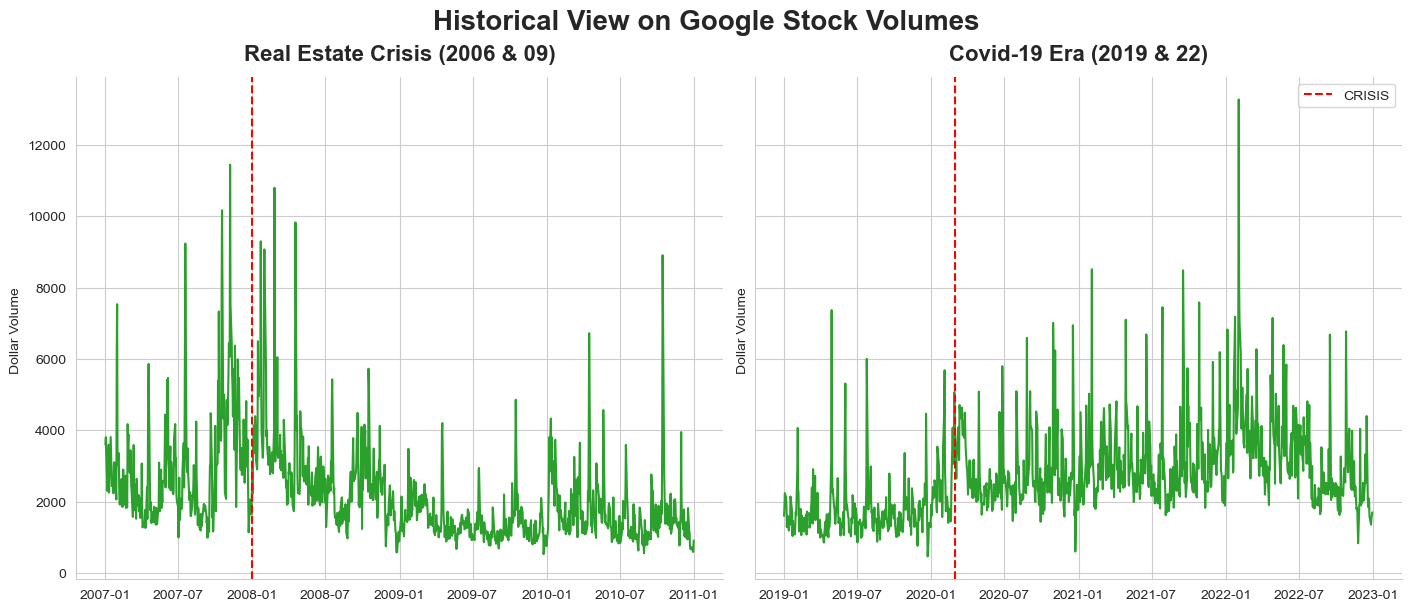

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (14, 6), layout = 'constrained', sharey = True)

axs[0].plot(df_google.loc['2007': '2010', 'dollar_volume'], 'tab:green')
axs[0].set_title('Real Estate Crisis (2006 & 09)', fontsize = 16, fontweight = 'bold', pad = 12)
axs[0].axvline(x = pd.to_datetime('2008-01'), color = 'red', linestyle = '--', label = 'Year 2008')

axs[1].plot(df_google.loc['2019': '2022', 'dollar_volume'], 'tab:green')
axs[1].set_title('Covid-19 Era (2019 & 22)', fontsize = 16, fontweight = 'bold', pad = 12)
axs[1].axvline(x = pd.to_datetime('2020-03'), color = 'red', linestyle = '--', label = 'CRISIS')

fig.suptitle('Historical View on Google Stock Volumes',
             fontsize = 20, fontweight = 'bold')

for ax in axs.flat:
    ax.set(ylabel = 'Dollar Volume ')

sns.despine()
plt.legend()
plt.show()

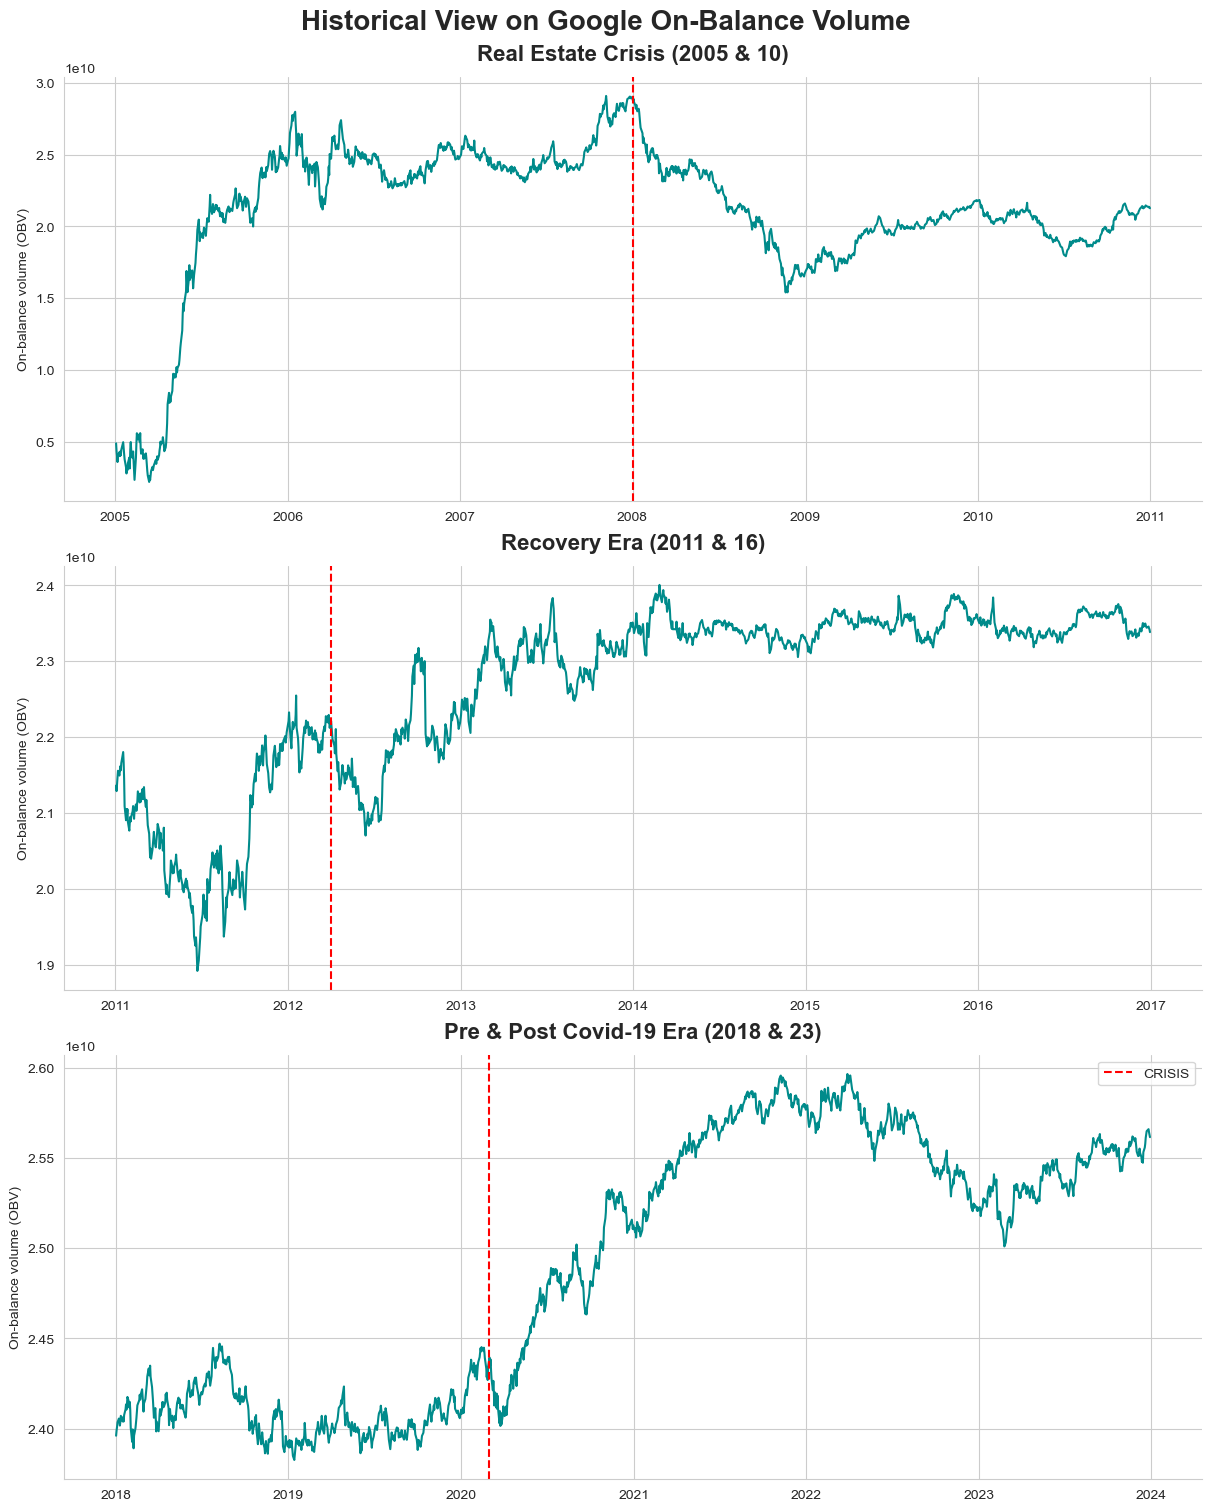

In [9]:
fig, axs = plt.subplots(3, 1, figsize = (12, 15), layout = 'constrained')

axs[0].plot(df_google.loc['2005': '2010', 'obv'], color = 'darkcyan')
axs[0].set_title('Real Estate Crisis (2005 & 10)', fontsize = 16, fontweight = 'bold', pad = 12)
axs[0].axvline(x = pd.to_datetime('2008-01'), color = 'red', linestyle = '--', label = 'Year 2008')

axs[1].plot(df_google.loc['2011': '2016', 'obv'], color = 'darkcyan')
axs[1].set_title('Recovery Era (2011 & 16)', fontsize = 16, fontweight = 'bold', pad = 12)
axs[1].axvline(x = pd.to_datetime('2012-04'), color = 'red', linestyle = '--', label = 'Year 2012')

axs[2].plot(df_google.loc['2018': '2023', 'obv'], color = 'darkcyan')
axs[2].set_title('Pre & Post Covid-19 Era (2018 & 23)', fontsize = 16, fontweight = 'bold', pad = 12)
axs[2].axvline(x = pd.to_datetime('2020-03'), color = 'red', linestyle = '--', label = 'CRISIS')

fig.suptitle('Historical View on Google On-Balance Volume',
             fontsize = 20, fontweight = 'bold')

for ax in axs.flat:
    ax.set(ylabel = 'On-balance volume (OBV)')

sns.despine()
plt.legend()
plt.show()

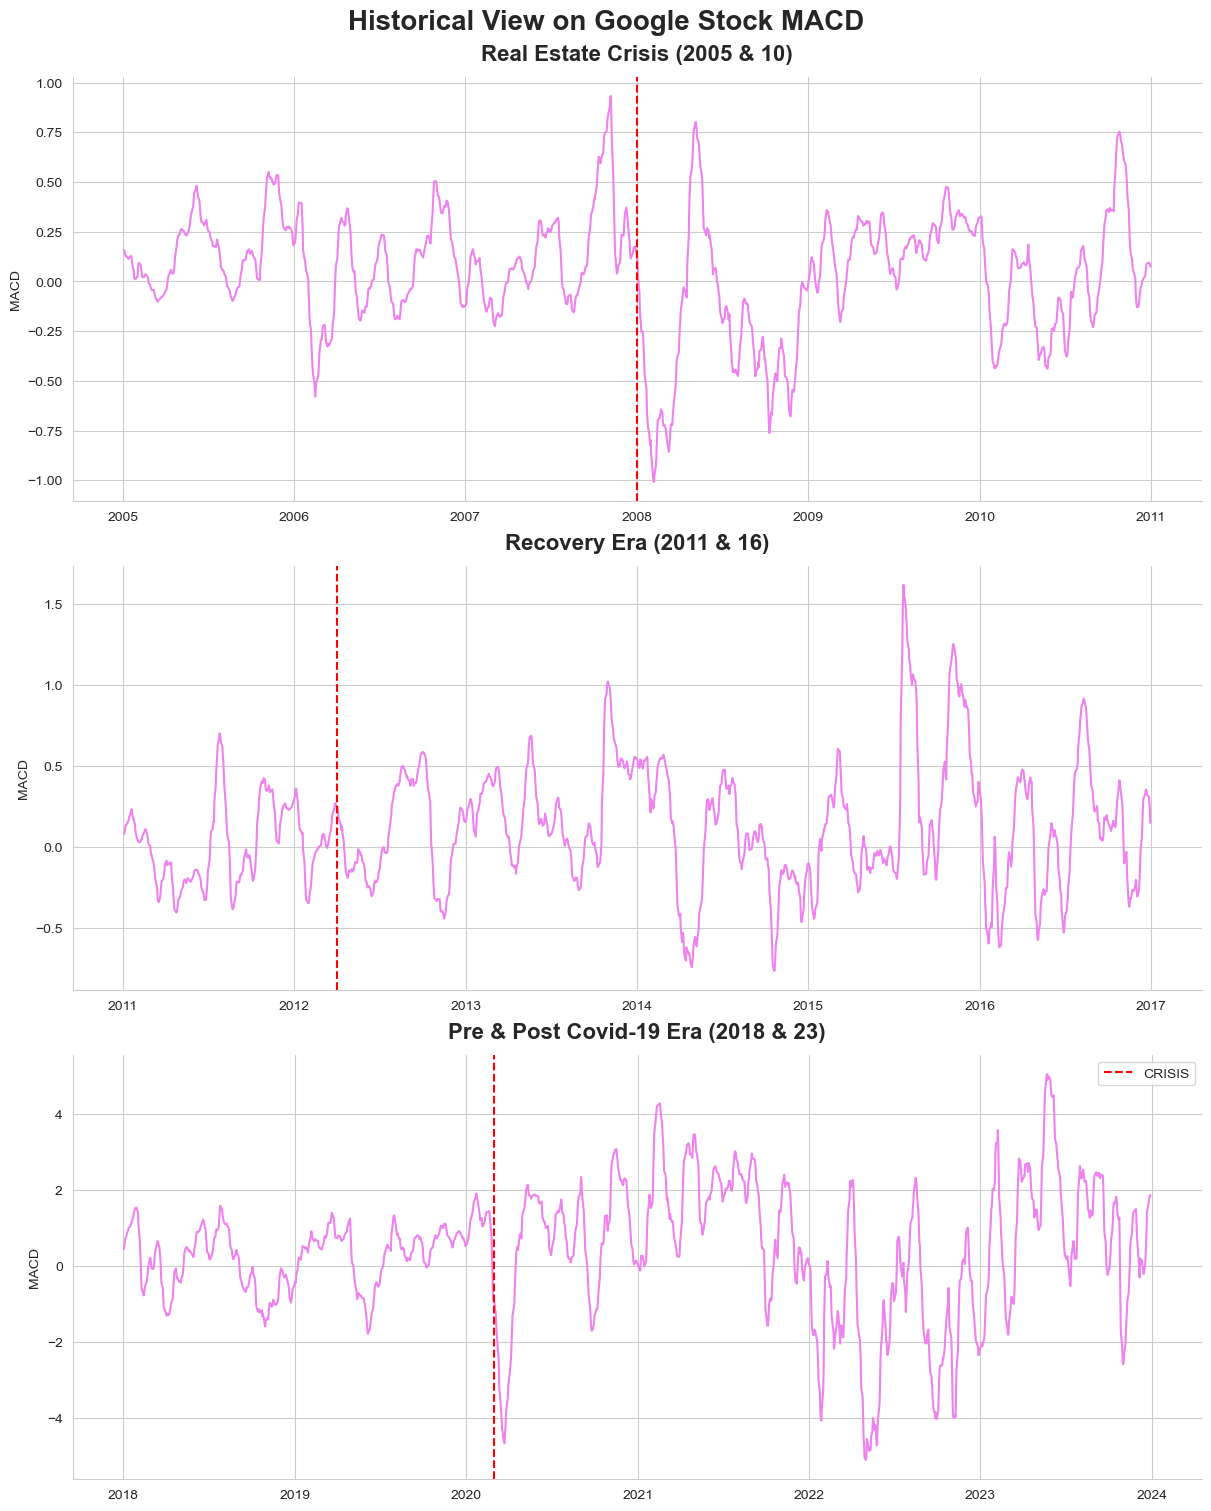

In [10]:
fig, axs = plt.subplots(3, 1, figsize = (12, 15), layout = 'constrained')

axs[0].plot(df_google.loc['2005': '2010', 'macd'], color = 'violet')
axs[0].set_title('Real Estate Crisis (2005 & 10)', fontsize = 16, fontweight = 'bold', pad = 12)
axs[0].axvline(x = pd.to_datetime('2008-01'), color = 'red', linestyle = '--', label = 'Year 2008')

axs[1].plot(df_google.loc['2011': '2016', 'macd'], color = 'violet')
axs[1].set_title('Recovery Era (2011 & 16)', fontsize = 16, fontweight = 'bold', pad = 12)
axs[1].axvline(x = pd.to_datetime('2012-04'), color = 'red', linestyle = '--', label = 'Year 2012')

axs[2].plot(df_google.loc['2018': '2023', 'macd'], color = 'violet')
axs[2].set_title('Pre & Post Covid-19 Era (2018 & 23)', fontsize = 16, fontweight = 'bold', pad = 12)
axs[2].axvline(x = pd.to_datetime('2020-03'), color = 'red', linestyle = '--', label = 'CRISIS')

fig.suptitle('Historical View on Google Stock MACD',
             fontsize = 20, fontweight = 'bold')

for ax in axs.flat:
    ax.set(ylabel = 'MACD')

sns.despine()
plt.legend()
plt.show()

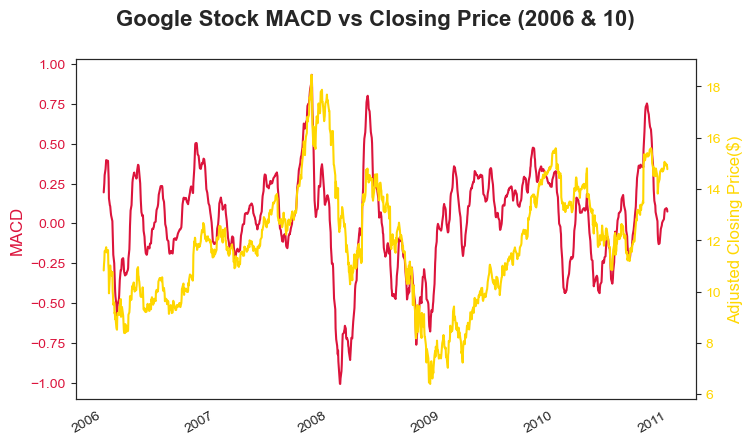

In [11]:
sns.set_style('white')

fig, ax1 = plt.subplots(figsize = (8, 5))
ax2 = ax1.twinx()

ax1.plot(df_google.loc['2006': '2010', 'macd'], color = 'crimson', lw = 1.5)
ax2.plot(df_google.loc['2006': '2010', 'adj_close'], color = 'gold', lw = 1.5)

ax1.set_ylabel('MACD', color = 'crimson', fontsize = 12)
ax1.tick_params(axis = 'y', labelcolor = 'crimson')

ax2.set_ylabel('Adjusted Closing Price($)', color = 'gold', fontsize = 12)
ax2.tick_params(axis = 'y', labelcolor = 'gold')

fig.suptitle('Google Stock MACD vs Closing Price (2006 & 10)', fontweight = 'bold', fontsize = 16)
fig.autofmt_xdate()

plt.show()

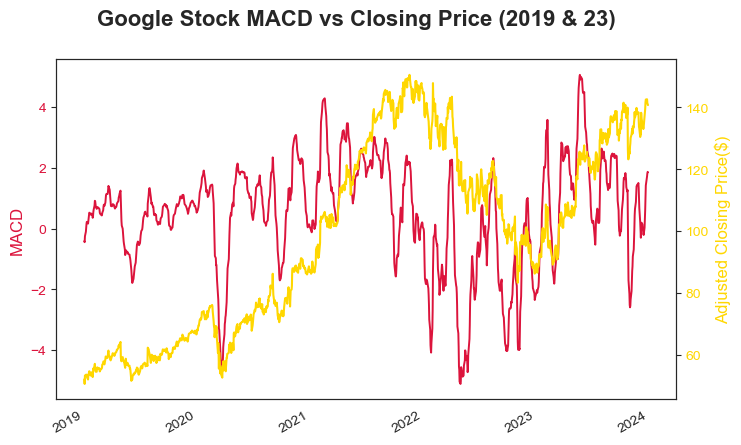

In [12]:
sns.set_style('white')

fig, ax1 = plt.subplots(figsize = (8, 5))
ax2 = ax1.twinx()

ax1.plot(df_google.loc['2019': '2023', 'macd'], color = 'crimson', lw = 1.4)
ax2.plot(df_google.loc['2019': '2023', 'adj_close'], color = 'gold', lw = 1.5)

ax1.set_ylabel('MACD', color = 'crimson', fontsize = 12)
ax1.tick_params(axis = 'y', labelcolor = 'crimson')

ax2.set_ylabel('Adjusted Closing Price($)', color = 'gold', fontsize = 12)
ax2.tick_params(axis = 'y', labelcolor = 'gold')

fig.suptitle('Google Stock MACD vs Closing Price (2019 & 23)', fontweight = 'bold', fontsize = 16)
fig.autofmt_xdate()

plt.show()

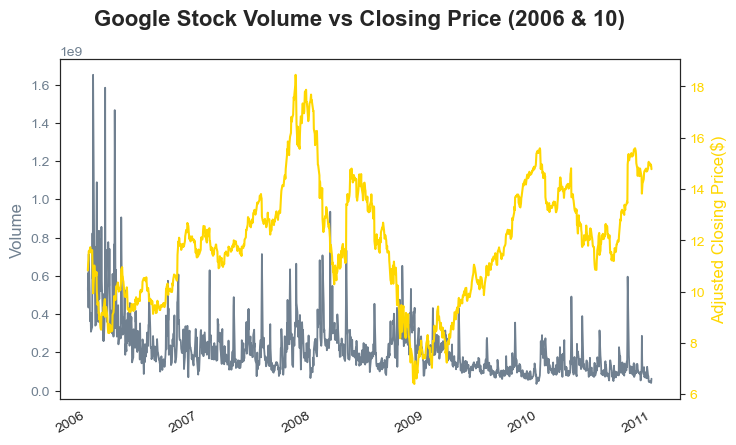

In [13]:
fig, ax1 = plt.subplots(figsize = (8, 5))
ax2 = ax1.twinx()

ax1.plot(df_google.loc['2006': '2010', 'volume'], color = 'slategray', lw = 1.3)
ax2.plot(df_google.loc['2006': '2010', 'adj_close'], color = 'gold', lw = 1.5)

ax1.set_ylabel('Volume', color = 'slategray', fontsize = 12)
ax1.tick_params(axis = 'y', labelcolor = 'slategray')

ax2.set_ylabel('Adjusted Closing Price($)', color = 'gold', fontsize = 12)
ax2.tick_params(axis = 'y', labelcolor = 'gold')

fig.suptitle('Google Stock Volume vs Closing Price (2006 & 10)', fontweight = 'bold', fontsize = 16)
fig.autofmt_xdate()

plt.show()

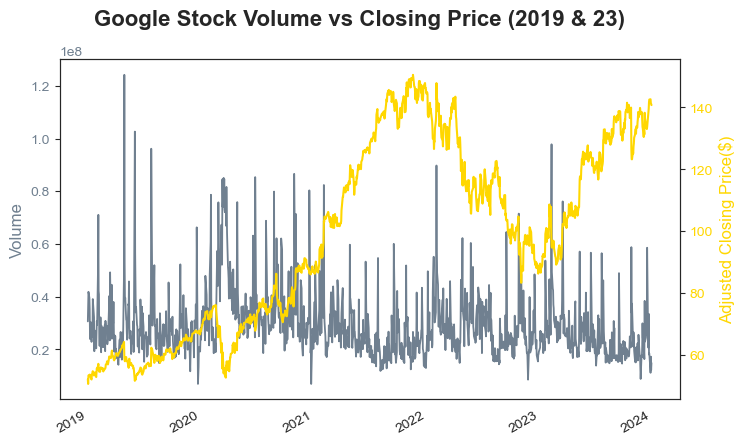

In [14]:
fig, ax1 = plt.subplots(figsize = (8, 5))
ax2 = ax1.twinx()

ax1.plot(df_google.loc['2019': '2023', 'volume'], color = 'slategray', lw = 1.3)
ax2.plot(df_google.loc['2019': '2023', 'adj_close'], color = 'gold', lw = 1.5)

ax1.set_ylabel('Volume', color = 'slategray', fontsize = 12)
ax1.tick_params(axis = 'y', labelcolor = 'slategray')

ax2.set_ylabel('Adjusted Closing Price($)', color = 'gold', fontsize = 12)
ax2.tick_params(axis = 'y', labelcolor = 'gold')

fig.suptitle('Google Stock Volume vs Closing Price (2019 & 23)', fontweight = 'bold', fontsize = 16)
fig.autofmt_xdate()

plt.show()

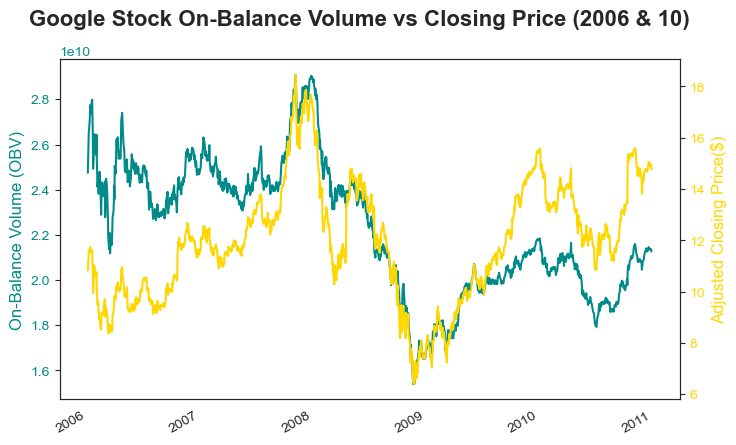

In [15]:
fig, ax1 = plt.subplots(figsize = (8, 5))
ax2 = ax1.twinx()

ax1.plot(df_google.loc['2006': '2010', 'obv'], color = 'darkcyan', lw = 1.5)
ax2.plot(df_google.loc['2006': '2010', 'adj_close'], color = 'gold', lw = 1.5)

ax1.set_ylabel('On-Balance Volume (OBV)', color = 'darkcyan', fontsize = 12)
ax1.tick_params(axis = 'y', labelcolor = 'darkcyan')

ax2.set_ylabel('Adjusted Closing Price($)', color = 'gold', fontsize = 12)
ax2.tick_params(axis = 'y', labelcolor = 'gold')

fig.suptitle('Google Stock On-Balance Volume vs Closing Price (2006 & 10)', fontweight = 'bold', fontsize = 16)
fig.autofmt_xdate()

plt.show()

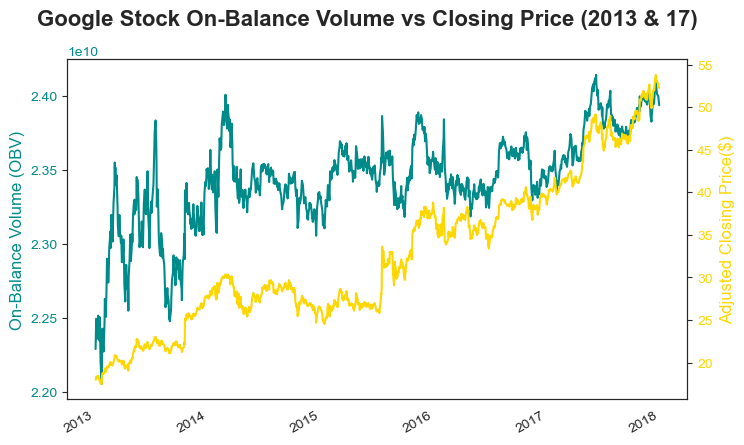

In [16]:
fig, ax1 = plt.subplots(figsize = (8, 5))
ax2 = ax1.twinx()

ax1.plot(df_google.loc['2013': '2017', 'obv'], color = 'darkcyan', lw = 1.5)
ax2.plot(df_google.loc['2013': '2017', 'adj_close'], color = 'gold', lw = 1.5)

ax1.set_ylabel('On-Balance Volume (OBV)', color = 'darkcyan', fontsize = 12)
ax1.tick_params(axis = 'y', labelcolor = 'darkcyan')

ax2.set_ylabel('Adjusted Closing Price($)', color = 'gold', fontsize = 12)
ax2.tick_params(axis = 'y', labelcolor = 'gold')

fig.suptitle('Google Stock On-Balance Volume vs Closing Price (2013 & 17)', fontweight = 'bold', fontsize = 16)
fig.autofmt_xdate()

plt.show()

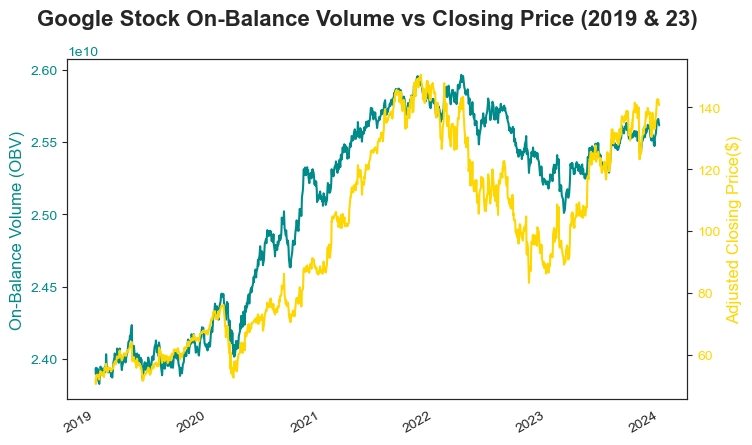

In [17]:
fig, ax1 = plt.subplots(figsize = (8, 5))
ax2 = ax1.twinx()

ax1.plot(df_google.loc['2019': '2023', 'obv'], color = 'darkcyan', lw = 1.5)
ax2.plot(df_google.loc['2019': '2023', 'adj_close'], color = 'gold', lw = 1.5)

ax1.set_ylabel('On-Balance Volume (OBV)', color = 'darkcyan', fontsize = 12)
ax1.tick_params(axis = 'y', labelcolor = 'darkcyan')

ax2.set_ylabel('Adjusted Closing Price($)', color = 'gold', fontsize = 12)
ax2.tick_params(axis = 'y', labelcolor = 'gold')

fig.suptitle('Google Stock On-Balance Volume vs Closing Price (2019 & 23)', fontweight = 'bold', fontsize = 16)
fig.autofmt_xdate()

plt.show()

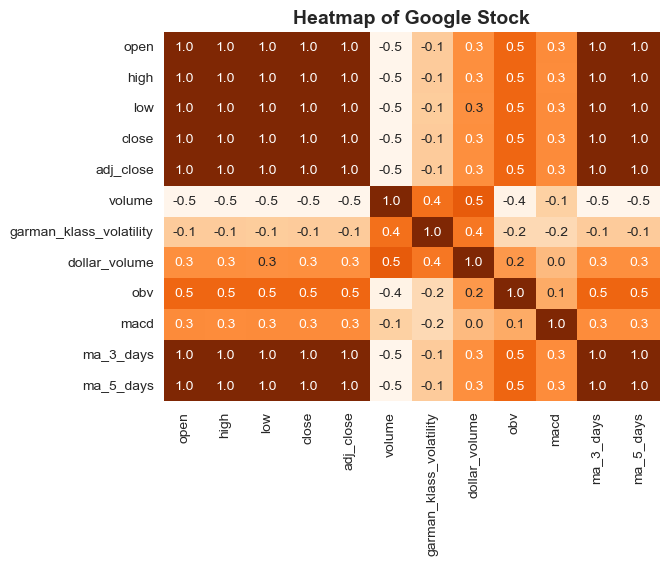

In [18]:
sns.heatmap(df_google[['open', 'high', 'low', 'close', 'adj_close', 
                       'volume', 'garman_klass_volatility', 'dollar_volume', 
                       'obv', 'macd', 'ma_3_days', 'ma_5_days']].corr(),
            annot = True, cbar = False, cmap = 'Oranges', fmt = '.1f')

plt.title('Heatmap of Google Stock', fontsize = 14, fontweight = 'bold')
plt.show()

<div style="background: linear-gradient(45deg,  #FF8C00, #FFD700, #006400); padding: 18px; border-radius: 10px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 32px;"> MODEL BUILDING & EVALUATION </h1>  
    
</div>

<div style="background: linear-gradient(45deg, #FF8C00, #006400); padding: 18px; border-radius: 20px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> Dataset Preparation for LSTM Model</h1>  
    
</div>

In [19]:
# Select sub-part of DF based on heatmap of correlation
google_features = ['adj_close', 'volume', 'dollar_volume', 'obv', 'ma_3_days', 'macd']
google_dset = df_google.filter(google_features)
google_dset.dropna(axis = 0, inplace = True)
print(google_dset.shape)

(5032, 6)


In [20]:
# Split train-test dsets wrt 80% - 20%
q_80 = int(len(google_dset) * 0.8)

google_train = google_dset[:q_80]
google_test = google_dset[q_80:]

google_train.shape, google_test.shape

((4025, 6), (1007, 6))

In [21]:
# Scale both train and test dsets before training the model
scaler = MinMaxScaler(feature_range = (0, 1))
google_train_scaled = scaler.fit_transform(google_train)
google_test_scaled = scaler.transform(google_test) # transform is selected to avoid data leakage
google_train_scaled

array([[0.00196476, 0.11176468, 0.02941552, 0.00583736, 0.00202881,
        0.6831326 ],
       [0.00259125, 0.08627624, 0.02306382, 0.01069032, 0.00186541,
        0.68317164],
       [0.00201396, 0.07552532, 0.01982581, 0.00644142, 0.00200578,
        0.68271082],
       ...,
       [0.96674068, 0.01660386, 0.12714687, 0.85457043, 0.96731398,
        0.72569851],
       [0.99348777, 0.02446489, 0.19214118, 0.85595042, 0.9761531 ,
        0.75483335],
       [0.9861985 , 0.02002428, 0.15623315, 0.85481993, 0.98491517,
        0.77037656]])

In [22]:
# Reform datasets since it is time series data and will be fed into LSTM model
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX, trainY = createXY(google_train_scaled, 21)
testX, testY = createXY(google_test_scaled, 21)

In [23]:
# Check dataset shapes are compatible and consistent
trainX.shape, trainY.shape, testX.shape, testY.shape

((4004, 21, 6), (4004,), (986, 21, 6), (986,))

<div style="background: linear-gradient(45deg, #FF8C00, #006400); padding: 15px; border-radius: 20px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> Model Architecture and GridSearchCV</h1>  
</div>

## !!! GridSearchCV and model training won't be executed in this final notebook version since it takes very long time for my old laptop :(

In [ ]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(100, return_sequences = True, input_shape = (21, 6)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.1))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse', optimizer = optimizer)
    return grid_model


grid_model = KerasRegressor(build_fn = build_model,
                            verbose = 1, validation_data = (testX, testY))
parameters = {'batch_size' : [12, 20, 24],
              'epochs' : [15, 20],
              'optimizer' : ['adam', 'Adadelta']}
grid_search  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 4)

In [ ]:
grid_search = grid_search.fit(trainX, trainY)

In [ ]:
grid_search.best_params_

### GridSearchCV yielded {'batch_size': 12, 'epochs': 20, 'optimizer': 'adam'} as best parameters.

In [ ]:
# Crate trained model with best parameters yielded from GridSearchCV
google_model = grid_search.best_estimator_.model

In [ ]:
# Save the model !!!
google_model.save('Google-LSTM-Model.h5')
print('Model saved to disk :)')

In [24]:
# Load previously saved model
google_model = tf.keras.models.load_model('Google-LSTM-Model.h5')
google_model.summary()

2024-09-07 00:41:13.203293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-07 00:41:13.206094: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-07 00:41:13.207744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_96 (LSTM)              (None, 21, 100)           42800     
                                                                 
 lstm_97 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_48 (Dropout)        (None, 50)                0         
                                                                 
 dense_48 (Dense)            (None, 1)                 51        
                                                                 
Total params: 73,051
Trainable params: 73,051
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Generate prediction and check its size
prediction = google_model.predict(testX)

print('Prediction Shape :', prediction.shape)

2024-09-07 00:41:18.430481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-09-07 00:41:18.430974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-09-07 00:41:18.858235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/s

31/31 [==============================] - 1s 9ms/step
Prediction Shape : (986, 1)


In [26]:
# Change shape to use inverse_transform
prediction_array = np.repeat(prediction, 6, axis = -1)
original_array = np.repeat(testY, 6, axis = -1)

In [27]:
# We just need the adj_close(1st column) after inverse transform, use [:,0] at the end
preds = scaler.inverse_transform(np.reshape(prediction_array,(len(prediction), 6)))[:,0]
original = scaler.inverse_transform(np.reshape(original_array,(len(testY), 6)))[:,0]
preds.shape, original.shape

((986,), (986,))

<div style="background: linear-gradient(45deg, #FF8C00, #006400); padding: 15px; border-radius: 20px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> 1st Model Evaluation</h1>  
    
</div>


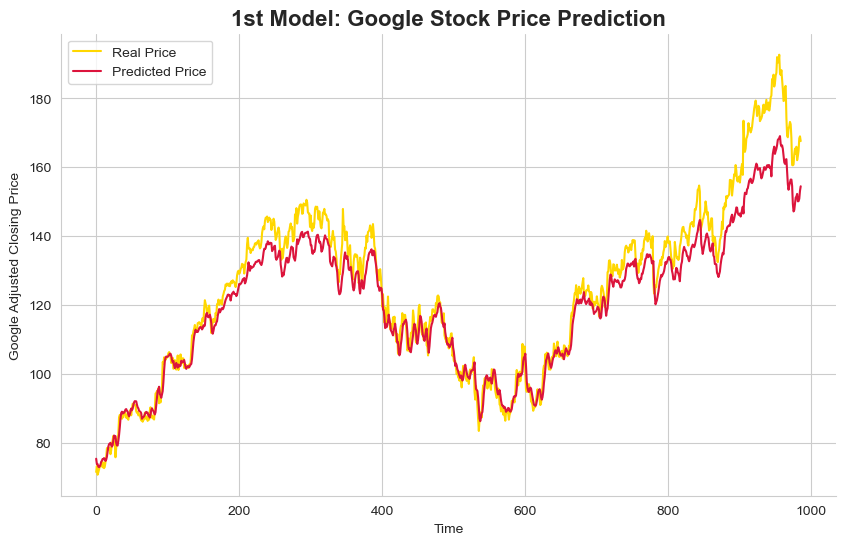

In [28]:
plt.figure(figsize = (10, 6))
sns.set_style('whitegrid')

plt.plot(original, color = 'gold', label = 'Real Price')
plt.plot(preds, color = 'crimson', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Google Adjusted Closing Price')
plt.title('1st Model: Google Stock Price Prediction', fontweight = 'bold', fontsize = 16)

plt.legend()
sns.despine()
plt.show()

In [29]:
# Calculate common evaluation metrics for forecasting model
mae_1 = mean_absolute_error(original, preds).round(4)
mape_1 = mean_absolute_percentage_error(original, preds).round(4)
R2_1 = r2_score(original, preds).round(4)

print('MAE =', mae_1, '\nMAPE =', mape_1, '\nR2 score =', R2_1)

MAE = 5.1096 
MAPE = 0.037 
R2 score = 0.9238


***
***

<div style="background: linear-gradient(45deg, #FF8C00, #006400); padding: 15px; border-radius: 20px; text-align: center; background-color: black; color: black;"> <h1 style="font-size: 24px;"> 2nd Model Building & Evaluation</h1>  
    
</div>


In [ ]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(128, return_sequences = True, input_shape = (21, 6)))
    grid_model.add(LSTM(64))
    grid_model.add(Dense(10))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse', optimizer = optimizer)
    return grid_model


grid_model = KerasRegressor(build_fn = build_model,
                            verbose = 1, validation_data = (testX, testY))
parameters = {'batch_size' : [20, 24, 32],
              'epochs' : [20, 30], 'optimizer' : ['adam']}
grid_search2  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 5)

In [ ]:
%%time

grid_search2 = grid_search2.fit(trainX, trainY)

In [ ]:
grid_search2.best_params_

### GridSearchCV yielded {'batch_size': 20, 'epochs': 30, 'optimizer': 'adam'} as best parameters.

In [ ]:
google_model2 = grid_search2.best_estimator_.model

In [31]:
# Load previously saved 2nd model
google_model2 = tf.keras.models.load_model('2nd-Google-LSTM-Model.h5')
google_model2.summary()

2024-09-07 00:45:53.521306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-09-07 00:45:53.522698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-09-07 00:45:53.524647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 21, 128)           69120     
                                                                 
 lstm_61 (LSTM)              (None, 64)                49408     
                                                                 
 dense_60 (Dense)            (None, 10)                650       
                                                                 
 dense_61 (Dense)            (None, 1)                 11        
                                                                 
Total params: 119,189
Trainable params: 119,189
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Generate prediction and check its size
prediction2 = google_model2.predict(testX)
print('Prediction Shape :', prediction2.shape)

2024-09-07 00:46:01.793012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-09-07 00:46:01.793430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-09-07 00:46:02.208402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/s

31/31 [==============================] - 1s 11ms/step
Prediction Shape : (986, 1)


In [33]:
# Change shape to use inverse_transform
prediction_array2 = np.repeat(prediction2, 6, axis = -1)
preds2 = scaler.inverse_transform(np.reshape(prediction_array,(len(prediction2), 6)))[:,0]

In [34]:
preds2.shape, original.shape

((986,), (986,))

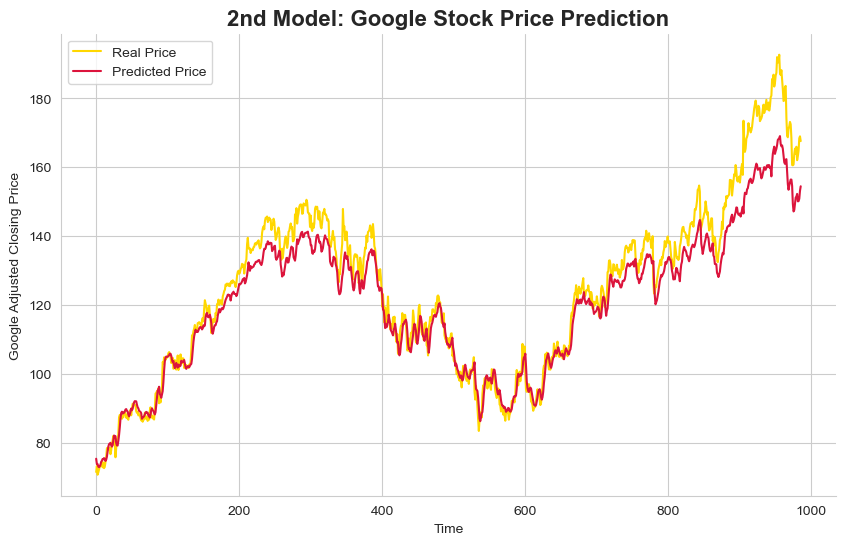

In [35]:
plt.figure(figsize = (10, 6))
sns.set_style('whitegrid')

plt.plot(original, color = 'gold', label = 'Real Price')
plt.plot(preds2, color = 'crimson', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Google Adjusted Closing Price')
plt.title('2nd Model: Google Stock Price Prediction', fontweight = 'bold', fontsize = 16)
plt.legend()

sns.despine()
plt.show()

In [35]:
google_model2.save('2nd-Google-LSTM-Model.h5')
print('Model saved to disk!')

Model saved to disk!


In [71]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(128, return_sequences = True, input_shape = (21, 6)))
    grid_model.add(LSTM(64))
    grid_model.add(Dense(18))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse', optimizer = optimizer)
    return grid_model


grid_model = KerasRegressor(build_fn = build_model,
                            verbose = 1, validation_data = (testX, testY))
parameters = {'batch_size' : [16, 24, 32],
              'epochs' : [20, 25, 30, 35], 'optimizer' : ['adam']}
grid_search5  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 4)

/var/folders/k6/rj6vyp8j659d9vfskgxrz_x40000gn/T/ipykernel_932/7340385.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn = build_model,


In [73]:
grid_search5 = grid_search5.fit(trainX, trainY)


2024-08-22 19:28:50.169092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:28:50.170864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:28:50.172668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 19:28:50.463856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:28:50.464186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:28:50.773073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

188/188 [==============================] - ETA: 0s - loss: 0.0032

2024-08-22 19:29:02.113592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 19:29:02.114052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:29:02.473867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

188/188 [==============================] - 13s 38ms/step - loss: 0.0032 - val_loss: 0.0425
Epoch 2/20
188/188 [==============================] - 6s 32ms/step - loss: 2.8026e-04 - val_loss: 0.0431
Epoch 3/20
188/188 [==============================] - 6s 30ms/step - loss: 2.5393e-04 - val_loss: 0.0203
Epoch 4/20
188/188 [==============================] - 6s 30ms/step - loss: 3.2805e-04 - val_loss: 0.0144
Epoch 5/20
188/188 [==============================] - 6s 31ms/step - loss: 3.1189e-04 - val_loss: 0.0142
Epoch 6/20
188/188 [==============================] - 6s 31ms/step - loss: 2.7907e-04 - val_loss: 0.0091
Epoch 7/20
188/188 [==============================] - 6s 31ms/step - loss: 2.1626e-04 - val_loss: 0.0143
Epoch 8/20
188/188 [==============================] - 6s 30ms/step - loss: 2.5296e-04 - val_loss: 0.0111
Epoch 9/20
188/188 [==============================] - 6s 30ms/step - loss: 2.2820e-04 - val_loss: 0.0059
Epoch 10/20
188/188 [==============================] - 6s 30ms/step -

2024-08-22 19:30:58.283479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:30:58.283795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 1.8253e-04


2024-08-22 19:30:58.945541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:30:58.947455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:30:58.949284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 19:30:59.167161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:30:59.169519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:30:59.171225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

188/188 [==============================] - ETA: 0s - loss: 0.0034

2024-08-22 19:31:09.696160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 19:31:09.696504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:31:09.986669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

188/188 [==============================] - 12s 39ms/step - loss: 0.0034 - val_loss: 0.0278
Epoch 2/20
188/188 [==============================] - 7s 36ms/step - loss: 2.9747e-04 - val_loss: 0.0343
Epoch 3/20
188/188 [==============================] - 6s 33ms/step - loss: 2.6480e-04 - val_loss: 0.0162
Epoch 4/20
188/188 [==============================] - 7s 36ms/step - loss: 3.5456e-04 - val_loss: 0.0133
Epoch 5/20
188/188 [==============================] - 6s 33ms/step - loss: 3.1154e-04 - val_loss: 0.0131
Epoch 6/20
188/188 [==============================] - 6s 33ms/step - loss: 2.8368e-04 - val_loss: 0.0067
Epoch 7/20
188/188 [==============================] - 7s 36ms/step - loss: 2.3495e-04 - val_loss: 0.0100
Epoch 8/20
188/188 [==============================] - 6s 34ms/step - loss: 2.8013e-04 - val_loss: 0.0071
Epoch 9/20
188/188 [==============================] - 6s 34ms/step - loss: 2.5517e-04 - val_loss: 0.0032
Epoch 10/20
188/188 [==============================] - 7s 36ms/step -

2024-08-22 19:33:14.952682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:33:14.953022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 1.7533e-05


2024-08-22 19:33:15.611376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:33:15.613232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:33:15.614577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 19:33:15.856676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:33:15.858152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:33:15.859882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

187/188 [============================>.] - ETA: 0s - loss: 0.0020

2024-08-22 19:33:25.794539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:33:25.794913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:33:26.081034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

188/188 [==============================] - 11s 38ms/step - loss: 0.0019 - val_loss: 0.0183
Epoch 2/20
188/188 [==============================] - 8s 44ms/step - loss: 2.8356e-04 - val_loss: 0.0342
Epoch 3/20
188/188 [==============================] - 8s 43ms/step - loss: 2.8380e-04 - val_loss: 0.0156
Epoch 4/20
188/188 [==============================] - 6s 34ms/step - loss: 2.4687e-04 - val_loss: 0.0122
Epoch 5/20
188/188 [==============================] - 6s 34ms/step - loss: 3.6112e-04 - val_loss: 0.0118
Epoch 6/20
188/188 [==============================] - 7s 37ms/step - loss: 2.7893e-04 - val_loss: 0.0083
Epoch 7/20
188/188 [==============================] - 7s 37ms/step - loss: 2.2854e-04 - val_loss: 0.0086
Epoch 8/20
188/188 [==============================] - 6s 34ms/step - loss: 2.1919e-04 - val_loss: 0.0078
Epoch 9/20
188/188 [==============================] - 6s 34ms/step - loss: 2.3858e-04 - val_loss: 0.0041
Epoch 10/20
188/188 [==============================] - 7s 36ms/step -

2024-08-22 19:35:36.075101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:35:36.075430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 1.3143e-04


2024-08-22 19:35:36.749462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:35:36.751227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:35:36.753152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 19:35:36.991400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:35:36.993119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:35:36.995111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

187/188 [============================>.] - ETA: 0s - loss: 0.0015

2024-08-22 19:35:46.951778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 19:35:46.952111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:35:47.232119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

188/188 [==============================] - 11s 39ms/step - loss: 0.0015 - val_loss: 0.0335
Epoch 2/20
188/188 [==============================] - 7s 35ms/step - loss: 9.9860e-05 - val_loss: 0.0358
Epoch 3/20
188/188 [==============================] - 6s 34ms/step - loss: 9.5873e-05 - val_loss: 0.0276
Epoch 4/20
188/188 [==============================] - 7s 36ms/step - loss: 1.0625e-04 - val_loss: 0.0306
Epoch 5/20
188/188 [==============================] - 7s 36ms/step - loss: 8.7202e-05 - val_loss: 0.0226
Epoch 6/20
188/188 [==============================] - 6s 34ms/step - loss: 8.2274e-05 - val_loss: 0.0309
Epoch 7/20
188/188 [==============================] - 6s 33ms/step - loss: 7.9713e-05 - val_loss: 0.0229
Epoch 8/20
188/188 [==============================] - 6s 34ms/step - loss: 7.5843e-05 - val_loss: 0.0147
Epoch 9/20
188/188 [==============================] - 7s 35ms/step - loss: 6.9143e-05 - val_loss: 0.0138
Epoch 10/20
188/188 [==============================] - 6s 34ms/step -

2024-08-22 19:37:52.122341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1001,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 19:37:52.122731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 1s 8ms/step - loss: 1.9664e-04


2024-08-22 19:37:52.912439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:37:52.914837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:37:52.916669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2024-08-22 19:37:53.209294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:37:53.211699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:37:53.213600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

188/188 [==============================] - ETA: 0s - loss: 0.0061

2024-08-22 19:38:03.251821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:38:03.252200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:38:03.526720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

188/188 [==============================] - 11s 38ms/step - loss: 0.0061 - val_loss: 0.0715
Epoch 2/25
188/188 [==============================] - 6s 33ms/step - loss: 3.6622e-04 - val_loss: 0.0666
Epoch 3/25
188/188 [==============================] - 7s 36ms/step - loss: 3.1828e-04 - val_loss: 0.0595
Epoch 4/25
188/188 [==============================] - 7s 35ms/step - loss: 3.0570e-04 - val_loss: 0.0408
Epoch 5/25
188/188 [==============================] - 6s 34ms/step - loss: 3.5864e-04 - val_loss: 0.0249
Epoch 6/25
188/188 [==============================] - 6s 34ms/step - loss: 3.0126e-04 - val_loss: 0.0242
Epoch 7/25
188/188 [==============================] - 7s 36ms/step - loss: 2.3632e-04 - val_loss: 0.0348
Epoch 8/25
188/188 [==============================] - 6s 34ms/step - loss: 2.1995e-04 - val_loss: 0.0154
Epoch 9/25
188/188 [==============================] - 6s 34ms/step - loss: 2.6403e-04 - val_loss: 0.0147
Epoch 10/25
188/188 [==============================] - 7s 35ms/step -

2024-08-22 19:40:39.526680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:40:39.527014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 3.7848e-05


2024-08-22 19:40:40.198017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:40:40.199844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:40:40.201140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2024-08-22 19:40:40.399943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:40:40.402404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:40:40.404455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

188/188 [==============================] - ETA: 0s - loss: 0.0021

2024-08-22 19:40:50.088203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 19:40:50.088674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:40:51.739112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

188/188 [==============================] - 12s 45ms/step - loss: 0.0021 - val_loss: 0.0146
Epoch 2/25
188/188 [==============================] - 6s 33ms/step - loss: 2.9547e-04 - val_loss: 0.0293
Epoch 3/25
188/188 [==============================] - 7s 37ms/step - loss: 2.8982e-04 - val_loss: 0.0162
Epoch 4/25
188/188 [==============================] - 7s 35ms/step - loss: 2.8930e-04 - val_loss: 0.0093
Epoch 5/25
188/188 [==============================] - 6s 34ms/step - loss: 3.1743e-04 - val_loss: 0.0069
Epoch 6/25
188/188 [==============================] - 6s 34ms/step - loss: 2.9622e-04 - val_loss: 0.0047
Epoch 7/25
188/188 [==============================] - 7s 35ms/step - loss: 2.3202e-04 - val_loss: 0.0077
Epoch 8/25
188/188 [==============================] - 6s 34ms/step - loss: 2.6541e-04 - val_loss: 0.0054
Epoch 9/25
188/188 [==============================] - 6s 34ms/step - loss: 2.0660e-04 - val_loss: 0.0028
Epoch 10/25
188/188 [==============================] - 7s 36ms/step -

2024-08-22 19:43:29.343794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:43:29.344196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 6.7822e-05


2024-08-22 19:43:30.022895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:43:30.024656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:43:30.026345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2024-08-22 19:43:30.322050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:43:30.322375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:43:30.593518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

188/188 [==============================] - ETA: 0s - loss: 0.0022

2024-08-22 19:43:40.214314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:43:40.214761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:43:40.486140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

188/188 [==============================] - 11s 39ms/step - loss: 0.0022 - val_loss: 0.0417
Epoch 2/25
188/188 [==============================] - 7s 36ms/step - loss: 2.9729e-04 - val_loss: 0.0505
Epoch 3/25
188/188 [==============================] - 6s 34ms/step - loss: 2.6192e-04 - val_loss: 0.0221
Epoch 4/25
188/188 [==============================] - 6s 34ms/step - loss: 3.3024e-04 - val_loss: 0.0320
Epoch 5/25
188/188 [==============================] - 6s 34ms/step - loss: 3.1374e-04 - val_loss: 0.0163
Epoch 6/25
188/188 [==============================] - 7s 35ms/step - loss: 2.5462e-04 - val_loss: 0.0213
Epoch 7/25
188/188 [==============================] - 6s 34ms/step - loss: 2.1241e-04 - val_loss: 0.0246
Epoch 8/25
188/188 [==============================] - 6s 34ms/step - loss: 1.9377e-04 - val_loss: 0.0131
Epoch 9/25
188/188 [==============================] - 7s 36ms/step - loss: 2.3381e-04 - val_loss: 0.0093
Epoch 10/25
188/188 [==============================] - 6s 34ms/step -

2024-08-22 19:46:16.836191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:46:16.836525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 6.2418e-05


2024-08-22 19:46:17.512418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:46:17.513679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:46:17.515614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2024-08-22 19:46:17.809610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:46:17.809948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:46:18.087281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

187/188 [============================>.] - ETA: 0s - loss: 0.0014

2024-08-22 19:46:27.325189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:46:27.325590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:46:27.577501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

188/188 [==============================] - 11s 38ms/step - loss: 0.0014 - val_loss: 0.1018
Epoch 2/25
188/188 [==============================] - 6s 34ms/step - loss: 1.1579e-04 - val_loss: 0.1135
Epoch 3/25
188/188 [==============================] - 10s 53ms/step - loss: 1.0570e-04 - val_loss: 0.1033
Epoch 4/25
188/188 [==============================] - 7s 37ms/step - loss: 1.2111e-04 - val_loss: 0.1100
Epoch 5/25
188/188 [==============================] - 6s 33ms/step - loss: 9.7230e-05 - val_loss: 0.0944
Epoch 6/25
188/188 [==============================] - 6s 33ms/step - loss: 9.2960e-05 - val_loss: 0.0960
Epoch 7/25
188/188 [==============================] - 7s 37ms/step - loss: 8.6296e-05 - val_loss: 0.0810
Epoch 8/25
188/188 [==============================] - 7s 35ms/step - loss: 7.8794e-05 - val_loss: 0.0573
Epoch 9/25
188/188 [==============================] - 6s 33ms/step - loss: 7.2049e-05 - val_loss: 0.0543
Epoch 10/25
188/188 [==============================] - 6s 33ms/step 

2024-08-22 19:49:06.808885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1001,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 19:49:06.809391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 1s 9ms/step - loss: 2.6859e-04


2024-08-22 19:49:07.642662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:49:07.644772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:49:07.646403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 19:49:07.972155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:49:07.975039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:49:07.977247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

188/188 [==============================] - ETA: 0s - loss: 0.0032

2024-08-22 19:49:17.916733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:49:17.917073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:49:18.180426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

188/188 [==============================] - 11s 38ms/step - loss: 0.0032 - val_loss: 0.0348
Epoch 2/30
188/188 [==============================] - 6s 34ms/step - loss: 2.9247e-04 - val_loss: 0.0335
Epoch 3/30
188/188 [==============================] - 7s 35ms/step - loss: 2.5372e-04 - val_loss: 0.0176
Epoch 4/30
188/188 [==============================] - 6s 35ms/step - loss: 3.1436e-04 - val_loss: 0.0146
Epoch 5/30
188/188 [==============================] - 6s 34ms/step - loss: 2.9168e-04 - val_loss: 0.0090
Epoch 6/30
188/188 [==============================] - 7s 35ms/step - loss: 2.8257e-04 - val_loss: 0.0079
Epoch 7/30
188/188 [==============================] - 7s 35ms/step - loss: 2.1995e-04 - val_loss: 0.0135
Epoch 8/30
188/188 [==============================] - 6s 34ms/step - loss: 2.4496e-04 - val_loss: 0.0109
Epoch 9/30
188/188 [==============================] - 6s 34ms/step - loss: 2.5333e-04 - val_loss: 0.0058
Epoch 10/30
188/188 [==============================] - 7s 36ms/step -

2024-08-22 19:52:28.818773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1001,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 19:52:28.819325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 1.3862e-04


2024-08-22 19:52:29.481878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:52:29.483741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:52:29.485523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 19:52:29.777485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:52:29.777862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:52:30.065991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

187/188 [============================>.] - ETA: 0s - loss: 0.0044

2024-08-22 19:52:39.783590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:52:39.783947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:52:40.047739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

188/188 [==============================] - 11s 39ms/step - loss: 0.0044 - val_loss: 0.0363
Epoch 2/30
188/188 [==============================] - 6s 34ms/step - loss: 3.0959e-04 - val_loss: 0.0425
Epoch 3/30
188/188 [==============================] - 7s 35ms/step - loss: 2.7179e-04 - val_loss: 0.0243
Epoch 4/30
188/188 [==============================] - 7s 35ms/step - loss: 3.4796e-04 - val_loss: 0.0204
Epoch 5/30
188/188 [==============================] - 7s 35ms/step - loss: 3.1014e-04 - val_loss: 0.0136
Epoch 6/30
188/188 [==============================] - 6s 35ms/step - loss: 2.9007e-04 - val_loss: 0.0099
Epoch 7/30
188/188 [==============================] - 6s 34ms/step - loss: 2.3670e-04 - val_loss: 0.0132
Epoch 8/30
188/188 [==============================] - 6s 34ms/step - loss: 2.5250e-04 - val_loss: 0.0102
Epoch 9/30
188/188 [==============================] - 7s 35ms/step - loss: 2.6333e-04 - val_loss: 0.0048
Epoch 10/30
188/188 [==============================] - 6s 34ms/step -

2024-08-22 19:55:50.383035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:55:50.383484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 2.6361e-05


2024-08-22 19:55:51.047130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:55:51.048991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:55:51.050756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 19:55:51.341600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [3003,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 19:55:51.342050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:55:51.640657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/spli

188/188 [==============================] - ETA: 0s - loss: 0.0024

2024-08-22 19:56:01.232149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:56:01.232505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:56:01.590742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

188/188 [==============================] - 11s 40ms/step - loss: 0.0024 - val_loss: 0.0340
Epoch 2/30
188/188 [==============================] - 7s 35ms/step - loss: 2.7775e-04 - val_loss: 0.0394
Epoch 3/30
188/188 [==============================] - 7s 35ms/step - loss: 2.5756e-04 - val_loss: 0.0194
Epoch 4/30
188/188 [==============================] - 6s 35ms/step - loss: 2.5180e-04 - val_loss: 0.0167
Epoch 5/30
188/188 [==============================] - 7s 36ms/step - loss: 3.3895e-04 - val_loss: 0.0130
Epoch 6/30
188/188 [==============================] - 6s 34ms/step - loss: 2.7455e-04 - val_loss: 0.0100
Epoch 7/30
188/188 [==============================] - 6s 34ms/step - loss: 2.2367e-04 - val_loss: 0.0101
Epoch 8/30
188/188 [==============================] - 7s 35ms/step - loss: 2.2010e-04 - val_loss: 0.0093
Epoch 9/30
188/188 [==============================] - 7s 35ms/step - loss: 2.2491e-04 - val_loss: 0.0053
Epoch 10/30
188/188 [==============================] - 6s 34ms/step -

2024-08-22 19:59:13.612231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:59:13.612575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 5.6547e-05


2024-08-22 19:59:14.277137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:59:14.279289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:59:14.280769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 19:59:14.480222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:59:14.482113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2024-08-22 19:59:14.579405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

188/188 [==============================] - ETA: 0s - loss: 0.0011

2024-08-22 19:59:24.287357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:59:24.287745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:59:24.558176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

188/188 [==============================] - 11s 38ms/step - loss: 0.0011 - val_loss: 0.0422
Epoch 2/30
188/188 [==============================] - 7s 35ms/step - loss: 1.0497e-04 - val_loss: 0.0483
Epoch 3/30
188/188 [==============================] - 6s 34ms/step - loss: 1.2247e-04 - val_loss: 0.0457
Epoch 4/30
188/188 [==============================] - 6s 34ms/step - loss: 8.2533e-05 - val_loss: 0.0444
Epoch 5/30
188/188 [==============================] - 7s 35ms/step - loss: 8.0416e-05 - val_loss: 0.0374
Epoch 6/30
188/188 [==============================] - 6s 34ms/step - loss: 9.2343e-05 - val_loss: 0.0486
Epoch 7/30
188/188 [==============================] - 7s 36ms/step - loss: 6.9823e-05 - val_loss: 0.0470
Epoch 8/30
188/188 [==============================] - 6s 33ms/step - loss: 8.9627e-05 - val_loss: 0.0278
Epoch 9/30
188/188 [==============================] - 6s 34ms/step - loss: 7.0753e-05 - val_loss: 0.0304
Epoch 10/30
188/188 [==============================] - 7s 35ms/step -

2024-08-22 20:02:35.997518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:02:35.998187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 2.0118e-04


2024-08-22 20:02:36.652481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:02:36.654256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:02:36.656127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-08-22 20:02:36.944058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:02:36.944374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:02:37.219984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

187/188 [============================>.] - ETA: 0s - loss: 0.0021

2024-08-22 20:02:48.284038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:02:48.284346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:02:48.533233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

188/188 [==============================] - 12s 38ms/step - loss: 0.0021 - val_loss: 0.0219
Epoch 2/35
188/188 [==============================] - 6s 34ms/step - loss: 3.0182e-04 - val_loss: 0.0361
Epoch 3/35
188/188 [==============================] - 7s 35ms/step - loss: 2.7069e-04 - val_loss: 0.0179
Epoch 4/35
188/188 [==============================] - 7s 36ms/step - loss: 3.0022e-04 - val_loss: 0.0107
Epoch 5/35
188/188 [==============================] - 7s 35ms/step - loss: 3.2867e-04 - val_loss: 0.0099
Epoch 6/35
188/188 [==============================] - 7s 35ms/step - loss: 2.7856e-04 - val_loss: 0.0057
Epoch 7/35
188/188 [==============================] - 6s 34ms/step - loss: 2.1110e-04 - val_loss: 0.0101
Epoch 8/35
188/188 [==============================] - 6s 34ms/step - loss: 2.4443e-04 - val_loss: 0.0073
Epoch 9/35
188/188 [==============================] - 7s 35ms/step - loss: 2.1153e-04 - val_loss: 0.0035
Epoch 10/35
188/188 [==============================] - 7s 36ms/step -

2024-08-22 20:06:32.133225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1001,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:06:32.133772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 7.9079e-05


2024-08-22 20:06:32.780243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:06:32.781997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:06:32.783791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-08-22 20:06:32.994746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:06:32.996623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:06:32.998170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

187/188 [============================>.] - ETA: 0s - loss: 0.0028

2024-08-22 20:06:43.016829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:06:43.017199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:06:43.293473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

188/188 [==============================] - 11s 39ms/step - loss: 0.0028 - val_loss: 0.0171
Epoch 2/35
188/188 [==============================] - 6s 34ms/step - loss: 2.9679e-04 - val_loss: 0.0308
Epoch 3/35
188/188 [==============================] - 6s 34ms/step - loss: 2.9062e-04 - val_loss: 0.0151
Epoch 4/35
188/188 [==============================] - 7s 36ms/step - loss: 2.9779e-04 - val_loss: 0.0089
Epoch 5/35
188/188 [==============================] - 7s 36ms/step - loss: 3.2632e-04 - val_loss: 0.0081
Epoch 6/35
188/188 [==============================] - 6s 34ms/step - loss: 3.0448e-04 - val_loss: 0.0043
Epoch 7/35
188/188 [==============================] - 6s 34ms/step - loss: 2.3847e-04 - val_loss: 0.0075
Epoch 8/35
188/188 [==============================] - 7s 36ms/step - loss: 2.7947e-04 - val_loss: 0.0052
Epoch 9/35
188/188 [==============================] - 6s 34ms/step - loss: 2.3481e-04 - val_loss: 0.0025
Epoch 10/35
188/188 [==============================] - 6s 34ms/step -

2024-08-22 20:10:26.402525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:10:26.403176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 1.6154e-05


2024-08-22 20:10:27.052204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:10:27.053944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:10:27.055785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-08-22 20:10:27.343083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:10:27.343414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:10:27.631516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

187/188 [============================>.] - ETA: 0s - loss: 0.0048

2024-08-22 20:10:37.271749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:10:37.272089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:10:37.536940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

188/188 [==============================] - 11s 37ms/step - loss: 0.0047 - val_loss: 0.0420
Epoch 2/35
188/188 [==============================] - 7s 35ms/step - loss: 3.0098e-04 - val_loss: 0.0423
Epoch 3/35
188/188 [==============================] - 6s 34ms/step - loss: 2.6962e-04 - val_loss: 0.0408
Epoch 4/35
188/188 [==============================] - 6s 34ms/step - loss: 2.7835e-04 - val_loss: 0.0305
Epoch 5/35
188/188 [==============================] - 6s 34ms/step - loss: 3.2829e-04 - val_loss: 0.0168
Epoch 6/35
188/188 [==============================] - 7s 37ms/step - loss: 2.5190e-04 - val_loss: 0.0139
Epoch 7/35
188/188 [==============================] - 6s 34ms/step - loss: 2.1820e-04 - val_loss: 0.0201
Epoch 8/35
188/188 [==============================] - 6s 34ms/step - loss: 2.0365e-04 - val_loss: 0.0130
Epoch 9/35
188/188 [==============================] - 7s 35ms/step - loss: 2.7980e-04 - val_loss: 0.0046
Epoch 10/35
188/188 [==============================] - 6s 34ms/step -

2024-08-22 20:14:20.790497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:14:20.790971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 4.1595e-05


2024-08-22 20:14:21.455772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:14:21.457563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:14:21.459171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-08-22 20:14:21.745693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:14:21.746009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:14:22.031336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

187/188 [============================>.] - ETA: 0s - loss: 0.0019

2024-08-22 20:14:31.736201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:14:31.736517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:14:32.001135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

188/188 [==============================] - 11s 40ms/step - loss: 0.0019 - val_loss: 0.0717
Epoch 2/35
188/188 [==============================] - 7s 35ms/step - loss: 9.3739e-05 - val_loss: 0.0654
Epoch 3/35
188/188 [==============================] - 7s 36ms/step - loss: 9.2647e-05 - val_loss: 0.0705
Epoch 4/35
188/188 [==============================] - 6s 34ms/step - loss: 1.0294e-04 - val_loss: 0.0677
Epoch 5/35
188/188 [==============================] - 7s 35ms/step - loss: 8.6232e-05 - val_loss: 0.0542
Epoch 6/35
188/188 [==============================] - 7s 36ms/step - loss: 8.1668e-05 - val_loss: 0.0632
Epoch 7/35
188/188 [==============================] - 7s 35ms/step - loss: 7.7883e-05 - val_loss: 0.0550
Epoch 8/35
188/188 [==============================] - 7s 35ms/step - loss: 7.7664e-05 - val_loss: 0.0384
Epoch 9/35
188/188 [==============================] - 6s 34ms/step - loss: 6.9535e-05 - val_loss: 0.0403
Epoch 10/35
188/188 [==============================] - 7s 36ms/step -

2024-08-22 20:18:17.812893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:18:17.813249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


63/63 [==============================] - 0s 7ms/step - loss: 3.6399e-04


2024-08-22 20:18:18.477884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:18:18.479934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:18:18.481673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 20:18:18.680121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:18:18.682131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2024-08-22 20:18:18.777963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/126 [============================>.] - ETA: 0s - loss: 0.0040

2024-08-22 20:18:26.999504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:18:26.999921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:18:27.416985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

126/126 [==============================] - 10s 48ms/step - loss: 0.0040 - val_loss: 0.0617
Epoch 2/20
126/126 [==============================] - 5s 39ms/step - loss: 2.9587e-04 - val_loss: 0.0304
Epoch 3/20
126/126 [==============================] - 5s 40ms/step - loss: 2.9292e-04 - val_loss: 0.0152
Epoch 4/20
126/126 [==============================] - 5s 43ms/step - loss: 2.4327e-04 - val_loss: 0.0090
Epoch 5/20
126/126 [==============================] - 5s 40ms/step - loss: 3.3416e-04 - val_loss: 0.0108
Epoch 6/20
126/126 [==============================] - 5s 40ms/step - loss: 2.2028e-04 - val_loss: 0.0091
Epoch 7/20
126/126 [==============================] - 5s 40ms/step - loss: 2.1573e-04 - val_loss: 0.0119
Epoch 8/20
126/126 [==============================] - 5s 42ms/step - loss: 2.3381e-04 - val_loss: 0.0071
Epoch 9/20
126/126 [==============================] - 5s 42ms/step - loss: 2.3752e-04 - val_loss: 0.0043
Epoch 10/20
126/126 [==============================] - 5s 40ms/step -

2024-08-22 20:20:05.475122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:20:05.475527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 9ms/step - loss: 1.1422e-04


2024-08-22 20:20:06.078671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:20:06.080399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:20:06.082366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 20:20:06.281638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:20:06.283964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2024-08-22 20:20:06.373480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/126 [============================>.] - ETA: 0s - loss: 0.0039

2024-08-22 20:20:14.549380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:20:14.549697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:20:14.813700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

126/126 [==============================] - 9s 45ms/step - loss: 0.0039 - val_loss: 0.0404
Epoch 2/20
126/126 [==============================] - 5s 40ms/step - loss: 2.9937e-04 - val_loss: 0.0326
Epoch 3/20
126/126 [==============================] - 5s 41ms/step - loss: 2.9673e-04 - val_loss: 0.0251
Epoch 4/20
126/126 [==============================] - 5s 40ms/step - loss: 2.5791e-04 - val_loss: 0.0131
Epoch 5/20
126/126 [==============================] - 5s 39ms/step - loss: 3.2149e-04 - val_loss: 0.0195
Epoch 6/20
126/126 [==============================] - 5s 40ms/step - loss: 2.3071e-04 - val_loss: 0.0145
Epoch 7/20
126/126 [==============================] - 5s 42ms/step - loss: 2.3279e-04 - val_loss: 0.0174
Epoch 8/20
126/126 [==============================] - 5s 40ms/step - loss: 2.6027e-04 - val_loss: 0.0109
Epoch 9/20
126/126 [==============================] - 5s 40ms/step - loss: 2.6810e-04 - val_loss: 0.0055
Epoch 10/20
126/126 [==============================] - 5s 40ms/step - 

2024-08-22 20:21:52.201705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1001,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:21:52.202170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 9ms/step - loss: 2.4490e-05


2024-08-22 20:21:52.825943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:21:52.827715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:21:52.829461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 20:21:53.028928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2024-08-22 20:21:53.118312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [3003,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:21:53.118616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder ten

125/126 [============================>.] - ETA: 0s - loss: 0.0058

2024-08-22 20:22:02.859070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:22:02.859386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:22:03.121746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

126/126 [==============================] - 11s 46ms/step - loss: 0.0058 - val_loss: 0.0639
Epoch 2/20
126/126 [==============================] - 5s 41ms/step - loss: 2.5182e-04 - val_loss: 0.0413
Epoch 3/20
126/126 [==============================] - 5s 41ms/step - loss: 2.9383e-04 - val_loss: 0.0276
Epoch 4/20
126/126 [==============================] - 5s 40ms/step - loss: 2.3000e-04 - val_loss: 0.0183
Epoch 5/20
126/126 [==============================] - 5s 40ms/step - loss: 3.4769e-04 - val_loss: 0.0184
Epoch 6/20
126/126 [==============================] - 5s 42ms/step - loss: 2.3307e-04 - val_loss: 0.0169
Epoch 7/20
126/126 [==============================] - 5s 40ms/step - loss: 2.0949e-04 - val_loss: 0.0284
Epoch 8/20
126/126 [==============================] - 5s 43ms/step - loss: 2.3375e-04 - val_loss: 0.0155
Epoch 9/20
126/126 [==============================] - 5s 40ms/step - loss: 2.4453e-04 - val_loss: 0.0085
Epoch 10/20
126/126 [==============================] - 5s 40ms/step -

2024-08-22 20:23:41.892014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1001,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:23:41.892442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 9ms/step - loss: 1.0844e-04


2024-08-22 20:23:42.501997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:23:42.503846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:23:42.505716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 20:23:42.788947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:23:42.789312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:23:43.069826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

125/126 [============================>.] - ETA: 0s - loss: 0.0012

2024-08-22 20:23:51.310692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:23:51.311018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:23:51.568569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

126/126 [==============================] - 10s 46ms/step - loss: 0.0012 - val_loss: 0.1068
Epoch 2/20
126/126 [==============================] - 5s 40ms/step - loss: 1.0569e-04 - val_loss: 0.0840
Epoch 3/20
126/126 [==============================] - 5s 43ms/step - loss: 9.1817e-05 - val_loss: 0.0757
Epoch 4/20
126/126 [==============================] - 5s 39ms/step - loss: 1.0184e-04 - val_loss: 0.0854
Epoch 5/20
126/126 [==============================] - 5s 42ms/step - loss: 1.0365e-04 - val_loss: 0.0756
Epoch 6/20
126/126 [==============================] - 5s 39ms/step - loss: 8.7408e-05 - val_loss: 0.0629
Epoch 7/20
126/126 [==============================] - 5s 40ms/step - loss: 8.8772e-05 - val_loss: 0.0802
Epoch 8/20
126/126 [==============================] - 5s 40ms/step - loss: 8.6786e-05 - val_loss: 0.0652
Epoch 9/20
126/126 [==============================] - 5s 42ms/step - loss: 7.9642e-05 - val_loss: 0.0693
Epoch 10/20
126/126 [==============================] - 5s 40ms/step -

2024-08-22 20:25:29.816895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:25:29.817348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 9ms/step - loss: 6.9904e-04


2024-08-22 20:25:30.448039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:25:30.450298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:25:30.451953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2024-08-22 20:25:30.739933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:25:30.740304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:25:31.019488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

125/126 [============================>.] - ETA: 0s - loss: 0.0047

2024-08-22 20:25:38.908543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:25:38.908859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:25:39.166859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

126/126 [==============================] - 9s 44ms/step - loss: 0.0047 - val_loss: 0.0409
Epoch 2/25
126/126 [==============================] - 5s 40ms/step - loss: 2.9672e-04 - val_loss: 0.0269
Epoch 3/25
126/126 [==============================] - 5s 42ms/step - loss: 2.9267e-04 - val_loss: 0.0194
Epoch 4/25
126/126 [==============================] - 5s 40ms/step - loss: 2.5808e-04 - val_loss: 0.0094
Epoch 5/25
126/126 [==============================] - 5s 39ms/step - loss: 3.3755e-04 - val_loss: 0.0116
Epoch 6/25
126/126 [==============================] - 5s 40ms/step - loss: 2.3250e-04 - val_loss: 0.0107
Epoch 7/25
126/126 [==============================] - 5s 42ms/step - loss: 2.4342e-04 - val_loss: 0.0148
Epoch 8/25
126/126 [==============================] - 5s 40ms/step - loss: 2.6232e-04 - val_loss: 0.0112
Epoch 9/25
126/126 [==============================] - 5s 39ms/step - loss: 2.7555e-04 - val_loss: 0.0088
Epoch 10/25
126/126 [==============================] - 5s 40ms/step - 

2024-08-22 20:27:41.620129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:27:41.620482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 10ms/step - loss: 1.0014e-04


2024-08-22 20:27:42.252206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:27:42.253989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:27:42.255787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2024-08-22 20:27:42.548250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:27:42.548592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:27:42.822678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

125/126 [============================>.] - ETA: 0s - loss: 0.0053

2024-08-22 20:27:51.096025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:27:51.096392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:27:51.352038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

126/126 [==============================] - 10s 48ms/step - loss: 0.0053 - val_loss: 0.0514
Epoch 2/25
126/126 [==============================] - 5s 40ms/step - loss: 2.8973e-04 - val_loss: 0.0394
Epoch 3/25
126/126 [==============================] - 5s 42ms/step - loss: 3.0372e-04 - val_loss: 0.0316
Epoch 4/25
126/126 [==============================] - 5s 40ms/step - loss: 2.7526e-04 - val_loss: 0.0171
Epoch 5/25
126/126 [==============================] - 5s 39ms/step - loss: 3.3036e-04 - val_loss: 0.0171
Epoch 6/25
126/126 [==============================] - 5s 40ms/step - loss: 2.5226e-04 - val_loss: 0.0139
Epoch 7/25
126/126 [==============================] - 6s 47ms/step - loss: 2.5421e-04 - val_loss: 0.0213
Epoch 8/25
126/126 [==============================] - 5s 39ms/step - loss: 2.4164e-04 - val_loss: 0.0093
Epoch 9/25
126/126 [==============================] - 5s 38ms/step - loss: 2.6669e-04 - val_loss: 0.0062
Epoch 10/25
126/126 [==============================] - 5s 40ms/step -

2024-08-22 20:29:54.963809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:29:54.964152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 9ms/step - loss: 1.8710e-05


2024-08-22 20:29:55.561453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:29:55.563608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:29:55.565066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2024-08-22 20:29:55.765023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:29:55.766566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2024-08-22 20:29:55.858691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/126 [============================>.] - ETA: 0s - loss: 0.0042

2024-08-22 20:30:04.169920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:30:04.170230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:30:04.430503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

126/126 [==============================] - 9s 45ms/step - loss: 0.0042 - val_loss: 0.0532
Epoch 2/25
126/126 [==============================] - 5s 40ms/step - loss: 2.7039e-04 - val_loss: 0.0402
Epoch 3/25
126/126 [==============================] - 5s 42ms/step - loss: 2.9097e-04 - val_loss: 0.0339
Epoch 4/25
126/126 [==============================] - 5s 40ms/step - loss: 2.3439e-04 - val_loss: 0.0166
Epoch 5/25
126/126 [==============================] - 5s 39ms/step - loss: 3.3530e-04 - val_loss: 0.0202
Epoch 6/25
126/126 [==============================] - 5s 41ms/step - loss: 2.2822e-04 - val_loss: 0.0270
Epoch 7/25
126/126 [==============================] - 5s 41ms/step - loss: 2.2691e-04 - val_loss: 0.0342
Epoch 8/25
126/126 [==============================] - 5s 40ms/step - loss: 2.4533e-04 - val_loss: 0.0176
Epoch 9/25
126/126 [==============================] - 5s 41ms/step - loss: 2.4298e-04 - val_loss: 0.0151
Epoch 10/25
126/126 [==============================] - 5s 40ms/step - 

2024-08-22 20:32:07.609149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:32:07.609607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 1s 12ms/step - loss: 5.9077e-05


2024-08-22 20:32:08.335585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:32:08.337335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:32:08.338827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2024-08-22 20:32:08.539827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:32:08.542213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:32:08.543928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/126 [============================>.] - ETA: 0s - loss: 0.0018

2024-08-22 20:32:16.866279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:32:16.866624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:32:17.207680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

126/126 [==============================] - 10s 47ms/step - loss: 0.0018 - val_loss: 0.0655
Epoch 2/25
126/126 [==============================] - 5s 40ms/step - loss: 1.0171e-04 - val_loss: 0.0661
Epoch 3/25
126/126 [==============================] - 5s 40ms/step - loss: 9.3037e-05 - val_loss: 0.0628
Epoch 4/25
126/126 [==============================] - 5s 40ms/step - loss: 1.0163e-04 - val_loss: 0.0603
Epoch 5/25
126/126 [==============================] - 5s 42ms/step - loss: 9.1731e-05 - val_loss: 0.0451
Epoch 6/25
126/126 [==============================] - 5s 40ms/step - loss: 8.8588e-05 - val_loss: 0.0347
Epoch 7/25
126/126 [==============================] - 5s 42ms/step - loss: 8.4676e-05 - val_loss: 0.0567
Epoch 8/25
126/126 [==============================] - 5s 40ms/step - loss: 1.1030e-04 - val_loss: 0.0464
Epoch 9/25
126/126 [==============================] - 5s 40ms/step - loss: 7.9711e-05 - val_loss: 0.0468
Epoch 10/25
126/126 [==============================] - 5s 40ms/step -

2024-08-22 20:34:20.584169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:34:20.584605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 10ms/step - loss: 2.6879e-04


2024-08-22 20:34:21.236957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:34:21.238711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:34:21.240515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 20:34:21.526523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:34:21.526862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:34:21.812527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

125/126 [============================>.] - ETA: 0s - loss: 0.0068

2024-08-22 20:34:29.700712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:34:29.701034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:34:29.960209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

126/126 [==============================] - 9s 45ms/step - loss: 0.0068 - val_loss: 0.0577
Epoch 2/30
126/126 [==============================] - 5s 41ms/step - loss: 3.0088e-04 - val_loss: 0.0457
Epoch 3/30
126/126 [==============================] - 5s 40ms/step - loss: 3.1430e-04 - val_loss: 0.0358
Epoch 4/30
126/126 [==============================] - 5s 42ms/step - loss: 3.0164e-04 - val_loss: 0.0211
Epoch 5/30
126/126 [==============================] - 5s 40ms/step - loss: 3.4125e-04 - val_loss: 0.0188
Epoch 6/30
126/126 [==============================] - 5s 39ms/step - loss: 2.6157e-04 - val_loss: 0.0177
Epoch 7/30
126/126 [==============================] - 5s 40ms/step - loss: 2.6307e-04 - val_loss: 0.0294
Epoch 8/30
126/126 [==============================] - 5s 43ms/step - loss: 2.5903e-04 - val_loss: 0.0150
Epoch 9/30
126/126 [==============================] - 5s 41ms/step - loss: 3.0866e-04 - val_loss: 0.0090
Epoch 10/30
126/126 [==============================] - 5s 40ms/step - 

2024-08-22 20:36:58.619861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1001,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:36:58.620214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 9ms/step - loss: 9.4010e-05


2024-08-22 20:36:59.230608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:36:59.232532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:36:59.233906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 20:36:59.434628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2024-08-22 20:36:59.525322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [3003,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:36:59.525613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder ten

126/126 [==============================] - ETA: 0s - loss: 0.0065

2024-08-22 20:37:10.971598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:37:10.971908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:37:11.238927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

126/126 [==============================] - 13s 52ms/step - loss: 0.0065 - val_loss: 0.0478
Epoch 2/30
126/126 [==============================] - 5s 42ms/step - loss: 2.9799e-04 - val_loss: 0.0340
Epoch 3/30
126/126 [==============================] - 5s 39ms/step - loss: 2.9283e-04 - val_loss: 0.0290
Epoch 4/30
126/126 [==============================] - 6s 44ms/step - loss: 2.7688e-04 - val_loss: 0.0134
Epoch 5/30
126/126 [==============================] - 5s 42ms/step - loss: 3.2249e-04 - val_loss: 0.0199
Epoch 6/30
126/126 [==============================] - 5s 40ms/step - loss: 2.3967e-04 - val_loss: 0.0161
Epoch 7/30
126/126 [==============================] - 5s 38ms/step - loss: 2.4524e-04 - val_loss: 0.0195
Epoch 8/30
126/126 [==============================] - 5s 41ms/step - loss: 2.5397e-04 - val_loss: 0.0114
Epoch 9/30
126/126 [==============================] - 5s 41ms/step - loss: 2.6517e-04 - val_loss: 0.0041
Epoch 10/30
126/126 [==============================] - 5s 41ms/step -

2024-08-22 20:39:44.341008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1001,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:39:44.341300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 11ms/step - loss: 2.0205e-05


2024-08-22 20:39:45.102461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:39:45.104141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:39:45.105944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 20:39:45.482708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:39:45.485903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:39:45.487709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/126 [============================>.] - ETA: 0s - loss: 0.0038

2024-08-22 20:39:55.074917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:39:55.075195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:39:55.357286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

126/126 [==============================] - 11s 48ms/step - loss: 0.0038 - val_loss: 0.0704
Epoch 2/30
126/126 [==============================] - 5s 40ms/step - loss: 2.4695e-04 - val_loss: 0.0451
Epoch 3/30
126/126 [==============================] - 6s 44ms/step - loss: 2.8822e-04 - val_loss: 0.0388
Epoch 4/30
126/126 [==============================] - 5s 41ms/step - loss: 2.3288e-04 - val_loss: 0.0200
Epoch 5/30
126/126 [==============================] - 5s 43ms/step - loss: 3.2779e-04 - val_loss: 0.0204
Epoch 6/30
126/126 [==============================] - 6s 45ms/step - loss: 2.3247e-04 - val_loss: 0.0290
Epoch 7/30
126/126 [==============================] - 5s 39ms/step - loss: 2.2427e-04 - val_loss: 0.0355
Epoch 8/30
126/126 [==============================] - 6s 44ms/step - loss: 2.3532e-04 - val_loss: 0.0176
Epoch 9/30
126/126 [==============================] - 6s 46ms/step - loss: 2.2997e-04 - val_loss: 0.0139
Epoch 10/30
126/126 [==============================] - 5s 37ms/step -

2024-08-22 20:42:19.523818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:42:19.524132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 8ms/step - loss: 6.8202e-05


2024-08-22 20:42:20.101493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:42:20.103203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:42:20.104947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 20:42:20.319532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:42:20.321792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:42:20.323585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/126 [============================>.] - ETA: 0s - loss: 0.0034

2024-08-22 20:42:28.420783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:42:28.421218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:42:28.754529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

126/126 [==============================] - 9s 46ms/step - loss: 0.0034 - val_loss: 0.0522
Epoch 2/30
126/126 [==============================] - 5s 37ms/step - loss: 1.0519e-04 - val_loss: 0.0960
Epoch 3/30
126/126 [==============================] - 5s 37ms/step - loss: 9.1663e-05 - val_loss: 0.0997
Epoch 4/30
126/126 [==============================] - 5s 37ms/step - loss: 1.0011e-04 - val_loss: 0.1060
Epoch 5/30
126/126 [==============================] - 5s 39ms/step - loss: 9.0702e-05 - val_loss: 0.0845
Epoch 6/30
126/126 [==============================] - 5s 36ms/step - loss: 8.8640e-05 - val_loss: 0.0801
Epoch 7/30
126/126 [==============================] - 5s 37ms/step - loss: 8.3652e-05 - val_loss: 0.1019
Epoch 8/30
126/126 [==============================] - 5s 36ms/step - loss: 1.0067e-04 - val_loss: 0.0721
Epoch 9/30
126/126 [==============================] - 5s 42ms/step - loss: 8.2155e-05 - val_loss: 0.0890
Epoch 10/30
126/126 [==============================] - 5s 37ms/step - 

2024-08-22 20:44:48.462903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:44:48.463441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 8ms/step - loss: 2.3911e-04


2024-08-22 20:44:49.033820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:44:49.035965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:44:49.037436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-08-22 20:44:49.250736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:44:49.252606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:44:49.254479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

126/126 [==============================] - ETA: 0s - loss: 0.0027

2024-08-22 20:44:57.734806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:44:57.735101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:44:57.995995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

126/126 [==============================] - 9s 46ms/step - loss: 0.0027 - val_loss: 0.0509
Epoch 2/35
126/126 [==============================] - 5s 37ms/step - loss: 2.8550e-04 - val_loss: 0.0290
Epoch 3/35
126/126 [==============================] - 5s 43ms/step - loss: 3.1511e-04 - val_loss: 0.0175
Epoch 4/35
126/126 [==============================] - 5s 37ms/step - loss: 2.4678e-04 - val_loss: 0.0098
Epoch 5/35
126/126 [==============================] - 5s 37ms/step - loss: 3.3680e-04 - val_loss: 0.0121
Epoch 6/35
126/126 [==============================] - 5s 37ms/step - loss: 2.2772e-04 - val_loss: 0.0102
Epoch 7/35
126/126 [==============================] - 5s 36ms/step - loss: 2.1487e-04 - val_loss: 0.0122
Epoch 8/35
126/126 [==============================] - 5s 37ms/step - loss: 2.3344e-04 - val_loss: 0.0075
Epoch 9/35
126/126 [==============================] - 5s 36ms/step - loss: 2.6348e-04 - val_loss: 0.0036
Epoch 10/35
126/126 [==============================] - 5s 40ms/step - 

2024-08-22 20:47:39.389235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:47:39.389679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 8ms/step - loss: 7.6942e-05


2024-08-22 20:47:39.961463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:47:39.962814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:47:39.964378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-08-22 20:47:40.171341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:47:40.174019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:47:40.175726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/126 [============================>.] - ETA: 0s - loss: 0.0018

2024-08-22 20:47:48.619036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:47:48.619355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:47:48.880633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

126/126 [==============================] - 9s 46ms/step - loss: 0.0018 - val_loss: 0.0140
Epoch 2/35
126/126 [==============================] - 5s 37ms/step - loss: 3.5706e-04 - val_loss: 0.0228
Epoch 3/35
126/126 [==============================] - 5s 36ms/step - loss: 3.0440e-04 - val_loss: 0.0133
Epoch 4/35
126/126 [==============================] - 5s 40ms/step - loss: 3.0537e-04 - val_loss: 0.0068
Epoch 5/35
126/126 [==============================] - 5s 37ms/step - loss: 4.4289e-04 - val_loss: 0.0145
Epoch 6/35
126/126 [==============================] - 5s 37ms/step - loss: 2.4202e-04 - val_loss: 0.0105
Epoch 7/35
126/126 [==============================] - 5s 37ms/step - loss: 2.1453e-04 - val_loss: 0.0129
Epoch 8/35
126/126 [==============================] - 5s 39ms/step - loss: 2.2524e-04 - val_loss: 0.0088
Epoch 9/35
126/126 [==============================] - 5s 37ms/step - loss: 2.4707e-04 - val_loss: 0.0040
Epoch 10/35
126/126 [==============================] - 5s 36ms/step - 

2024-08-22 20:50:31.416660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1001,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:50:31.417107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 10ms/step - loss: 1.4936e-05


2024-08-22 20:50:32.094877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:50:32.096792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:50:32.098365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-08-22 20:50:32.325791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:50:32.328185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:50:32.329892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/126 [============================>.] - ETA: 0s - loss: 0.0043

2024-08-22 20:50:40.711127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:50:40.711433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:50:40.979511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

126/126 [==============================] - 9s 43ms/step - loss: 0.0043 - val_loss: 0.0437
Epoch 2/35
126/126 [==============================] - 5s 37ms/step - loss: 2.6327e-04 - val_loss: 0.0411
Epoch 3/35
126/126 [==============================] - 5s 39ms/step - loss: 3.0037e-04 - val_loss: 0.0341
Epoch 4/35
126/126 [==============================] - 5s 37ms/step - loss: 2.3268e-04 - val_loss: 0.0207
Epoch 5/35
126/126 [==============================] - 5s 36ms/step - loss: 3.4285e-04 - val_loss: 0.0184
Epoch 6/35
126/126 [==============================] - 5s 37ms/step - loss: 2.2171e-04 - val_loss: 0.0175
Epoch 7/35
126/126 [==============================] - 5s 42ms/step - loss: 2.0229e-04 - val_loss: 0.0287
Epoch 8/35
126/126 [==============================] - 5s 37ms/step - loss: 2.2773e-04 - val_loss: 0.0141
Epoch 9/35
126/126 [==============================] - 5s 36ms/step - loss: 2.3333e-04 - val_loss: 0.0105
Epoch 10/35
126/126 [==============================] - 5s 36ms/step - 

2024-08-22 20:53:23.158676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:53:23.159053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 8ms/step - loss: 4.8294e-05


2024-08-22 20:53:23.738156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:53:23.740293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:53:23.741971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-08-22 20:53:23.947976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:53:23.950039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:53:23.951607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

125/126 [============================>.] - ETA: 0s - loss: 0.0010

2024-08-22 20:53:32.415221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:53:32.415503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:53:34.163445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

126/126 [==============================] - 11s 57ms/step - loss: 0.0010 - val_loss: 0.0413
Epoch 2/35
126/126 [==============================] - 5s 36ms/step - loss: 9.9920e-05 - val_loss: 0.0442
Epoch 3/35
126/126 [==============================] - 5s 36ms/step - loss: 8.5687e-05 - val_loss: 0.0428
Epoch 4/35
126/126 [==============================] - 5s 39ms/step - loss: 1.1035e-04 - val_loss: 0.0529
Epoch 5/35
126/126 [==============================] - 5s 36ms/step - loss: 8.9572e-05 - val_loss: 0.0501
Epoch 6/35
126/126 [==============================] - 5s 37ms/step - loss: 8.9198e-05 - val_loss: 0.0379
Epoch 7/35
126/126 [==============================] - 5s 36ms/step - loss: 8.8863e-05 - val_loss: 0.0527
Epoch 8/35
126/126 [==============================] - 5s 37ms/step - loss: 7.5621e-05 - val_loss: 0.0365
Epoch 9/35
126/126 [==============================] - 5s 41ms/step - loss: 7.1023e-05 - val_loss: 0.0402
Epoch 10/35
126/126 [==============================] - 5s 37ms/step -

2024-08-22 20:56:16.981228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1001,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:56:16.981666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


42/42 [==============================] - 0s 10ms/step - loss: 4.6965e-04


2024-08-22 20:56:17.666130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:56:17.667377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:56:17.668927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 20:56:17.922379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:56:17.923651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:56:17.925128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

93/94 [============================>.] - ETA: 0s - loss: 0.0104

2024-08-22 20:56:25.608718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:56:25.609027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:56:25.873148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

94/94 [==============================] - 9s 51ms/step - loss: 0.0103 - val_loss: 0.0652
Epoch 2/20
94/94 [==============================] - 4s 44ms/step - loss: 3.0308e-04 - val_loss: 0.0508
Epoch 3/20
94/94 [==============================] - 4s 41ms/step - loss: 2.8496e-04 - val_loss: 0.0433
Epoch 4/20
94/94 [==============================] - 4s 40ms/step - loss: 2.6444e-04 - val_loss: 0.0385
Epoch 5/20
94/94 [==============================] - 4s 40ms/step - loss: 2.7089e-04 - val_loss: 0.0300
Epoch 6/20
94/94 [==============================] - 4s 40ms/step - loss: 2.5011e-04 - val_loss: 0.0219
Epoch 7/20
94/94 [==============================] - 4s 46ms/step - loss: 2.3367e-04 - val_loss: 0.0195
Epoch 8/20
94/94 [==============================] - 4s 40ms/step - loss: 2.1082e-04 - val_loss: 0.0177
Epoch 9/20
94/94 [==============================] - 4s 40ms/step - loss: 2.8470e-04 - val_loss: 0.0151
Epoch 10/20
94/94 [==============================] - 4s 40ms/step - loss: 2.3718e-04 - v

2024-08-22 20:57:41.147712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1001,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 20:57:41.148035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 10ms/step - loss: 4.7044e-05


2024-08-22 20:57:41.692892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:57:41.694684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:57:41.696437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 20:57:41.894325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:57:41.896704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:57:41.899182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

94/94 [==============================] - ETA: 0s - loss: 0.0039

2024-08-22 20:57:49.630242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:57:49.630534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:57:49.889795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

94/94 [==============================] - 9s 54ms/step - loss: 0.0039 - val_loss: 0.0646
Epoch 2/20
94/94 [==============================] - 4s 40ms/step - loss: 2.7052e-04 - val_loss: 0.0530
Epoch 3/20
94/94 [==============================] - 4s 40ms/step - loss: 2.8542e-04 - val_loss: 0.0391
Epoch 4/20
94/94 [==============================] - 4s 41ms/step - loss: 2.4086e-04 - val_loss: 0.0368
Epoch 5/20
94/94 [==============================] - 4s 40ms/step - loss: 2.8203e-04 - val_loss: 0.0350
Epoch 6/20
94/94 [==============================] - 4s 45ms/step - loss: 2.5403e-04 - val_loss: 0.0242
Epoch 7/20
94/94 [==============================] - 4s 40ms/step - loss: 2.2597e-04 - val_loss: 0.0299
Epoch 8/20
94/94 [==============================] - 4s 40ms/step - loss: 2.1753e-04 - val_loss: 0.0176
Epoch 9/20
94/94 [==============================] - 4s 40ms/step - loss: 2.6096e-04 - val_loss: 0.0194
Epoch 10/20
94/94 [==============================] - 4s 42ms/step - loss: 2.0690e-04 - v

2024-08-22 20:59:05.167467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:59:05.167758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 11ms/step - loss: 3.1686e-05


2024-08-22 20:59:05.779551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:59:05.781158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:59:05.782673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 20:59:05.998621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 20:59:06.000638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 20:59:06.002242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

93/94 [============================>.] - ETA: 0s - loss: 0.0045

2024-08-22 20:59:13.654601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:59:13.655114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 20:59:13.926102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

94/94 [==============================] - 9s 51ms/step - loss: 0.0045 - val_loss: 0.0462
Epoch 2/20
94/94 [==============================] - 4s 45ms/step - loss: 2.7967e-04 - val_loss: 0.0480
Epoch 3/20
94/94 [==============================] - 4s 41ms/step - loss: 3.2393e-04 - val_loss: 0.0374
Epoch 4/20
94/94 [==============================] - 4s 40ms/step - loss: 2.3368e-04 - val_loss: 0.0365
Epoch 5/20
94/94 [==============================] - 4s 40ms/step - loss: 2.8003e-04 - val_loss: 0.0302
Epoch 6/20
94/94 [==============================] - 4s 41ms/step - loss: 2.4448e-04 - val_loss: 0.0245
Epoch 7/20
94/94 [==============================] - 4s 45ms/step - loss: 2.0303e-04 - val_loss: 0.0287
Epoch 8/20
94/94 [==============================] - 4s 41ms/step - loss: 2.1766e-04 - val_loss: 0.0233
Epoch 9/20
94/94 [==============================] - 4s 46ms/step - loss: 2.5001e-04 - val_loss: 0.0254
Epoch 10/20
94/94 [==============================] - 4s 40ms/step - loss: 2.2188e-04 - v

2024-08-22 21:00:29.088273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:00:29.088662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 11ms/step - loss: 1.3040e-04


2024-08-22 21:00:29.694581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:00:29.696033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:00:29.698217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 21:00:29.896635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:00:29.899578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:00:29.901820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

93/94 [============================>.] - ETA: 0s - loss: 0.0017

2024-08-22 21:00:37.156033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 21:00:37.156351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:00:37.417829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

94/94 [==============================] - 8s 49ms/step - loss: 0.0017 - val_loss: 0.0826
Epoch 2/20
94/94 [==============================] - 4s 46ms/step - loss: 9.4880e-05 - val_loss: 0.0911
Epoch 3/20
94/94 [==============================] - 4s 40ms/step - loss: 8.2180e-05 - val_loss: 0.0768
Epoch 4/20
94/94 [==============================] - 4s 46ms/step - loss: 9.5563e-05 - val_loss: 0.0861
Epoch 5/20
94/94 [==============================] - 4s 40ms/step - loss: 8.9509e-05 - val_loss: 0.0631
Epoch 6/20
94/94 [==============================] - 4s 40ms/step - loss: 8.5371e-05 - val_loss: 0.0613
Epoch 7/20
94/94 [==============================] - 4s 40ms/step - loss: 8.7440e-05 - val_loss: 0.0709
Epoch 8/20
94/94 [==============================] - 4s 42ms/step - loss: 9.1810e-05 - val_loss: 0.0515
Epoch 9/20
94/94 [==============================] - 4s 47ms/step - loss: 8.6951e-05 - val_loss: 0.0477
Epoch 10/20
94/94 [==============================] - 4s 41ms/step - loss: 8.2377e-05 - v

2024-08-22 21:01:53.286359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:01:53.286663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 10ms/step - loss: 3.1597e-04


2024-08-22 21:01:53.876934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:01:53.878253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:01:53.879877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2024-08-22 21:01:54.087974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:01:54.090087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:01:54.091447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

93/94 [============================>.] - ETA: 0s - loss: 0.0069

2024-08-22 21:02:01.316838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:02:01.317123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:02:01.579433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

94/94 [==============================] - 8s 49ms/step - loss: 0.0068 - val_loss: 0.0486
Epoch 2/25
94/94 [==============================] - 4s 40ms/step - loss: 2.9572e-04 - val_loss: 0.0425
Epoch 3/25
94/94 [==============================] - 4s 45ms/step - loss: 2.7060e-04 - val_loss: 0.0374
Epoch 4/25
94/94 [==============================] - 4s 40ms/step - loss: 2.5002e-04 - val_loss: 0.0367
Epoch 5/25
94/94 [==============================] - 4s 40ms/step - loss: 2.5693e-04 - val_loss: 0.0331
Epoch 6/25
94/94 [==============================] - 4s 40ms/step - loss: 2.4405e-04 - val_loss: 0.0275
Epoch 7/25
94/94 [==============================] - 4s 41ms/step - loss: 2.2638e-04 - val_loss: 0.0225
Epoch 8/25
94/94 [==============================] - 4s 46ms/step - loss: 2.0907e-04 - val_loss: 0.0224
Epoch 9/25
94/94 [==============================] - 4s 42ms/step - loss: 2.6209e-04 - val_loss: 0.0224
Epoch 10/25
94/94 [==============================] - 4s 40ms/step - loss: 2.3059e-04 - v

2024-08-22 21:03:36.172336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:03:36.172744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 10ms/step - loss: 2.1982e-04


2024-08-22 21:03:36.710125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:03:36.711452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:03:36.713410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2024-08-22 21:03:36.935486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:03:36.937597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:03:36.939480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

93/94 [============================>.] - ETA: 0s - loss: 0.0038

2024-08-22 21:03:44.158765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 21:03:44.159102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:03:44.419842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

94/94 [==============================] - 8s 48ms/step - loss: 0.0037 - val_loss: 0.0302
Epoch 2/25
94/94 [==============================] - 4s 46ms/step - loss: 2.7405e-04 - val_loss: 0.0326
Epoch 3/25
94/94 [==============================] - 4s 40ms/step - loss: 2.6738e-04 - val_loss: 0.0205
Epoch 4/25
94/94 [==============================] - 4s 41ms/step - loss: 2.3445e-04 - val_loss: 0.0192
Epoch 5/25
94/94 [==============================] - 4s 42ms/step - loss: 2.5041e-04 - val_loss: 0.0193
Epoch 6/25
94/94 [==============================] - 4s 43ms/step - loss: 2.5645e-04 - val_loss: 0.0130
Epoch 7/25
94/94 [==============================] - 4s 41ms/step - loss: 2.1769e-04 - val_loss: 0.0167
Epoch 8/25
94/94 [==============================] - 4s 40ms/step - loss: 2.1163e-04 - val_loss: 0.0114
Epoch 9/25
94/94 [==============================] - 4s 41ms/step - loss: 2.3487e-04 - val_loss: 0.0114
Epoch 10/25
94/94 [==============================] - 4s 44ms/step - loss: 2.2426e-04 - v

2024-08-22 21:05:19.820791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:05:19.821129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 9ms/step - loss: 1.2998e-04


2024-08-22 21:05:20.351790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:05:20.353433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:05:20.355243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2024-08-22 21:05:20.564636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:05:20.566773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:05:20.568312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

94/94 [==============================] - ETA: 0s - loss: 0.0030

2024-08-22 21:05:29.932937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 21:05:29.933248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:05:30.197914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

94/94 [==============================] - 10s 55ms/step - loss: 0.0030 - val_loss: 0.0276
Epoch 2/25
94/94 [==============================] - 4s 40ms/step - loss: 2.5363e-04 - val_loss: 0.0282
Epoch 3/25
94/94 [==============================] - 4s 40ms/step - loss: 2.8634e-04 - val_loss: 0.0194
Epoch 4/25
94/94 [==============================] - 4s 40ms/step - loss: 2.2191e-04 - val_loss: 0.0183
Epoch 5/25
94/94 [==============================] - 4s 40ms/step - loss: 2.9211e-04 - val_loss: 0.0186
Epoch 6/25
94/94 [==============================] - 4s 46ms/step - loss: 2.1917e-04 - val_loss: 0.0140
Epoch 7/25
94/94 [==============================] - 4s 40ms/step - loss: 1.9236e-04 - val_loss: 0.0199
Epoch 8/25
94/94 [==============================] - 4s 41ms/step - loss: 2.0894e-04 - val_loss: 0.0129
Epoch 9/25
94/94 [==============================] - 4s 40ms/step - loss: 2.4375e-04 - val_loss: 0.0125
Epoch 10/25
94/94 [==============================] - 4s 40ms/step - loss: 1.8979e-04 - 

2024-08-22 21:07:04.882965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:07:04.883362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 11ms/step - loss: 1.1654e-04


2024-08-22 21:07:05.519730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:07:05.521005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:07:05.523197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/25


2024-08-22 21:07:05.729211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:07:05.731335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:07:05.732736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

93/94 [============================>.] - ETA: 0s - loss: 0.0031

2024-08-22 21:07:13.216376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:07:13.216698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:07:13.484862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

94/94 [==============================] - 8s 49ms/step - loss: 0.0031 - val_loss: 0.0266
Epoch 2/25
94/94 [==============================] - 4s 40ms/step - loss: 9.6076e-05 - val_loss: 0.0395
Epoch 3/25
94/94 [==============================] - 4s 41ms/step - loss: 9.1082e-05 - val_loss: 0.0359
Epoch 4/25
94/94 [==============================] - 4s 40ms/step - loss: 9.1510e-05 - val_loss: 0.0522
Epoch 5/25
94/94 [==============================] - 4s 46ms/step - loss: 8.3375e-05 - val_loss: 0.0422
Epoch 6/25
94/94 [==============================] - 4s 41ms/step - loss: 8.5362e-05 - val_loss: 0.0349
Epoch 7/25
94/94 [==============================] - 4s 40ms/step - loss: 8.6280e-05 - val_loss: 0.0520
Epoch 8/25
94/94 [==============================] - 4s 41ms/step - loss: 8.4181e-05 - val_loss: 0.0442
Epoch 9/25
94/94 [==============================] - 4s 40ms/step - loss: 8.3082e-05 - val_loss: 0.0382
Epoch 10/25
94/94 [==============================] - 4s 47ms/step - loss: 8.2910e-05 - v

2024-08-22 21:08:48.409483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:08:48.409874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 10ms/step - loss: 4.4281e-04


2024-08-22 21:08:48.959168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:08:48.961251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:08:48.962596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 21:08:49.165193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:08:49.167635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2024-08-22 21:08:49.253839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

93/94 [============================>.] - ETA: 0s - loss: 0.0059

2024-08-22 21:08:56.457672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 21:08:56.457956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:08:56.719940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

94/94 [==============================] - 8s 48ms/step - loss: 0.0059 - val_loss: 0.0853
Epoch 2/30
94/94 [==============================] - 4s 41ms/step - loss: 3.1066e-04 - val_loss: 0.0694
Epoch 3/30
94/94 [==============================] - 4s 48ms/step - loss: 2.8148e-04 - val_loss: 0.0516
Epoch 4/30
94/94 [==============================] - 4s 42ms/step - loss: 2.4924e-04 - val_loss: 0.0428
Epoch 5/30
94/94 [==============================] - 4s 41ms/step - loss: 2.6462e-04 - val_loss: 0.0294
Epoch 6/30
94/94 [==============================] - 4s 40ms/step - loss: 2.6052e-04 - val_loss: 0.0225
Epoch 7/30
94/94 [==============================] - 4s 40ms/step - loss: 2.2755e-04 - val_loss: 0.0169
Epoch 8/30
94/94 [==============================] - 4s 40ms/step - loss: 2.0991e-04 - val_loss: 0.0175
Epoch 9/30
94/94 [==============================] - 4s 40ms/step - loss: 2.5596e-04 - val_loss: 0.0164
Epoch 10/30
94/94 [==============================] - 4s 41ms/step - loss: 2.2885e-04 - v

2024-08-22 21:10:51.498828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:10:51.499142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 11ms/step - loss: 9.8570e-05


2024-08-22 21:10:52.076436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:10:52.078576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:10:52.080194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 21:10:52.293014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:10:52.294724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:10:52.296505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

93/94 [============================>.] - ETA: 0s - loss: 0.0035

2024-08-22 21:10:59.489208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:10:59.489507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:10:59.750340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

94/94 [==============================] - 8s 49ms/step - loss: 0.0034 - val_loss: 0.0433
Epoch 2/30
94/94 [==============================] - 4s 40ms/step - loss: 2.7073e-04 - val_loss: 0.0356
Epoch 3/30
94/94 [==============================] - 5s 48ms/step - loss: 2.9756e-04 - val_loss: 0.0240
Epoch 4/30
94/94 [==============================] - 4s 41ms/step - loss: 2.4553e-04 - val_loss: 0.0241
Epoch 5/30
94/94 [==============================] - 4s 40ms/step - loss: 3.1462e-04 - val_loss: 0.0226
Epoch 6/30
94/94 [==============================] - 4s 40ms/step - loss: 2.6181e-04 - val_loss: 0.0162
Epoch 7/30
94/94 [==============================] - 4s 41ms/step - loss: 2.2100e-04 - val_loss: 0.0202
Epoch 8/30
94/94 [==============================] - 4s 46ms/step - loss: 2.1466e-04 - val_loss: 0.0119
Epoch 9/30
94/94 [==============================] - 4s 41ms/step - loss: 2.4566e-04 - val_loss: 0.0116
Epoch 10/30
94/94 [==============================] - 4s 40ms/step - loss: 2.0061e-04 - v

2024-08-22 21:12:53.596078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:12:53.596379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 10ms/step - loss: 2.3211e-05


2024-08-22 21:12:54.134755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:12:54.136543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:12:54.138430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 21:12:54.347973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:12:54.349955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:12:54.351597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

93/94 [============================>.] - ETA: 0s - loss: 0.0060

2024-08-22 21:13:01.587265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:13:01.587557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:13:01.854507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

94/94 [==============================] - 8s 48ms/step - loss: 0.0060 - val_loss: 0.0525
Epoch 2/30
94/94 [==============================] - 4s 47ms/step - loss: 2.7604e-04 - val_loss: 0.0563
Epoch 3/30
94/94 [==============================] - 4s 42ms/step - loss: 2.6047e-04 - val_loss: 0.0440
Epoch 4/30
94/94 [==============================] - 4s 41ms/step - loss: 2.2915e-04 - val_loss: 0.0412
Epoch 5/30
94/94 [==============================] - 4s 40ms/step - loss: 2.3271e-04 - val_loss: 0.0318
Epoch 6/30
94/94 [==============================] - 4s 40ms/step - loss: 2.6159e-04 - val_loss: 0.0294
Epoch 7/30
94/94 [==============================] - 4s 42ms/step - loss: 1.9863e-04 - val_loss: 0.0257
Epoch 8/30
94/94 [==============================] - 4s 44ms/step - loss: 2.0816e-04 - val_loss: 0.0231
Epoch 9/30
94/94 [==============================] - 4s 43ms/step - loss: 2.5782e-04 - val_loss: 0.0210
Epoch 10/30
94/94 [==============================] - 4s 40ms/step - loss: 2.3732e-04 - v

2024-08-22 21:14:56.979434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1001,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 21:14:56.979953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 1s 19ms/step - loss: 6.2174e-05


2024-08-22 21:14:57.918036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:14:57.921306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:14:57.923886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 21:14:58.393672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:14:58.396840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:14:58.399280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

94/94 [==============================] - ETA: 0s - loss: 0.0021

2024-08-22 21:15:07.396597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:15:07.396979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:15:07.796371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

94/94 [==============================] - 10s 61ms/step - loss: 0.0021 - val_loss: 0.0306
Epoch 2/30
94/94 [==============================] - 4s 42ms/step - loss: 1.0457e-04 - val_loss: 0.0542
Epoch 3/30
94/94 [==============================] - 4s 42ms/step - loss: 9.3663e-05 - val_loss: 0.0503
Epoch 4/30
94/94 [==============================] - 4s 42ms/step - loss: 9.3656e-05 - val_loss: 0.0669
Epoch 5/30
94/94 [==============================] - 4s 42ms/step - loss: 8.9405e-05 - val_loss: 0.0495
Epoch 6/30
94/94 [==============================] - 4s 48ms/step - loss: 9.1186e-05 - val_loss: 0.0539
Epoch 7/30
94/94 [==============================] - 4s 43ms/step - loss: 9.3718e-05 - val_loss: 0.0710
Epoch 8/30
94/94 [==============================] - 4s 44ms/step - loss: 8.2220e-05 - val_loss: 0.0654
Epoch 9/30
94/94 [==============================] - 4s 45ms/step - loss: 8.7551e-05 - val_loss: 0.0605
Epoch 10/30
94/94 [==============================] - 4s 43ms/step - loss: 8.0760e-05 - 

2024-08-22 21:17:08.632354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:17:08.633073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 11ms/step - loss: 5.7028e-04


2024-08-22 21:17:09.240016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:17:09.242056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:17:09.243331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-08-22 21:17:09.446902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:17:09.448882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:17:09.450412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

93/94 [============================>.] - ETA: 0s - loss: 0.0058

2024-08-22 21:17:16.843273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:17:16.843574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:17:18.580864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

94/94 [==============================] - 10s 67ms/step - loss: 0.0057 - val_loss: 0.0619
Epoch 2/35
94/94 [==============================] - 4s 42ms/step - loss: 2.7415e-04 - val_loss: 0.0469
Epoch 3/35
94/94 [==============================] - 4s 43ms/step - loss: 2.7035e-04 - val_loss: 0.0366
Epoch 4/35
94/94 [==============================] - 4s 47ms/step - loss: 2.4716e-04 - val_loss: 0.0360
Epoch 5/35
94/94 [==============================] - 4s 42ms/step - loss: 2.5567e-04 - val_loss: 0.0271
Epoch 6/35
94/94 [==============================] - 4s 43ms/step - loss: 2.4704e-04 - val_loss: 0.0199
Epoch 7/35
94/94 [==============================] - 4s 42ms/step - loss: 2.2585e-04 - val_loss: 0.0164
Epoch 8/35
94/94 [==============================] - 4s 43ms/step - loss: 2.1040e-04 - val_loss: 0.0155
Epoch 9/35
94/94 [==============================] - 4s 46ms/step - loss: 2.8210e-04 - val_loss: 0.0132
Epoch 10/35
94/94 [==============================] - 4s 42ms/step - loss: 2.3922e-04 - 

2024-08-22 21:19:39.479108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:19:39.479608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 11ms/step - loss: 4.1089e-05


2024-08-22 21:19:40.078280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:19:40.080391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:19:40.081526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-08-22 21:19:40.372640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:19:40.372975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:19:40.682728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

93/94 [============================>.] - ETA: 0s - loss: 0.0070

2024-08-22 21:19:47.916683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:19:47.917008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:19:48.172850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

94/94 [==============================] - 9s 50ms/step - loss: 0.0069 - val_loss: 0.0537
Epoch 2/35
94/94 [==============================] - 4s 47ms/step - loss: 3.1588e-04 - val_loss: 0.0456
Epoch 3/35
94/94 [==============================] - 4s 43ms/step - loss: 2.9055e-04 - val_loss: 0.0372
Epoch 4/35
94/94 [==============================] - 4s 43ms/step - loss: 2.6818e-04 - val_loss: 0.0393
Epoch 5/35
94/94 [==============================] - 4s 43ms/step - loss: 2.7327e-04 - val_loss: 0.0331
Epoch 6/35
94/94 [==============================] - 4s 43ms/step - loss: 2.6316e-04 - val_loss: 0.0280
Epoch 7/35
94/94 [==============================] - 4s 42ms/step - loss: 2.4141e-04 - val_loss: 0.0225
Epoch 8/35
94/94 [==============================] - 4s 46ms/step - loss: 2.2426e-04 - val_loss: 0.0247
Epoch 9/35
94/94 [==============================] - 4s 43ms/step - loss: 3.0222e-04 - val_loss: 0.0170
Epoch 10/35
94/94 [==============================] - 4s 42ms/step - loss: 2.5457e-04 - v

2024-08-22 21:22:09.265978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:22:09.266465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 14ms/step - loss: 1.9266e-05


2024-08-22 21:22:09.925087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:22:09.926856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:22:09.928964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-08-22 21:22:10.137531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:22:10.139560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:22:10.141143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

93/94 [============================>.] - ETA: 0s - loss: 0.0052

2024-08-22 21:22:17.429754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:22:17.430079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:22:17.694235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

94/94 [==============================] - 8s 50ms/step - loss: 0.0051 - val_loss: 0.0463
Epoch 2/35
94/94 [==============================] - 4s 43ms/step - loss: 2.5175e-04 - val_loss: 0.0469
Epoch 3/35
94/94 [==============================] - 4s 43ms/step - loss: 2.8830e-04 - val_loss: 0.0360
Epoch 4/35
94/94 [==============================] - 4s 46ms/step - loss: 2.2401e-04 - val_loss: 0.0342
Epoch 5/35
94/94 [==============================] - 4s 43ms/step - loss: 2.6496e-04 - val_loss: 0.0290
Epoch 6/35
94/94 [==============================] - 4s 42ms/step - loss: 2.3061e-04 - val_loss: 0.0253
Epoch 7/35
94/94 [==============================] - 4s 48ms/step - loss: 1.9902e-04 - val_loss: 0.0294
Epoch 8/35
94/94 [==============================] - 4s 43ms/step - loss: 2.0761e-04 - val_loss: 0.0245
Epoch 9/35
94/94 [==============================] - 4s 43ms/step - loss: 2.3946e-04 - val_loss: 0.0240
Epoch 10/35
94/94 [==============================] - 4s 43ms/step - loss: 2.1796e-04 - v

2024-08-22 21:24:37.935289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:24:37.935638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 11ms/step - loss: 6.6486e-05


2024-08-22 21:24:38.509998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:24:38.511796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:24:38.513448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-08-22 21:24:38.801347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [3003,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 21:24:38.801724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3003]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:24:39.083466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/spli

93/94 [============================>.] - ETA: 0s - loss: 0.0029

2024-08-22 21:24:46.440344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:24:46.440664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:24:46.702125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

94/94 [==============================] - 9s 55ms/step - loss: 0.0028 - val_loss: 0.0844
Epoch 2/35
94/94 [==============================] - 4s 42ms/step - loss: 1.0083e-04 - val_loss: 0.0775
Epoch 3/35
94/94 [==============================] - 4s 43ms/step - loss: 9.7659e-05 - val_loss: 0.0633
Epoch 4/35
94/94 [==============================] - 4s 42ms/step - loss: 9.4678e-05 - val_loss: 0.0694
Epoch 5/35
94/94 [==============================] - 4s 44ms/step - loss: 8.2918e-05 - val_loss: 0.0594
Epoch 6/35
94/94 [==============================] - 5s 48ms/step - loss: 8.8040e-05 - val_loss: 0.0458
Epoch 7/35
94/94 [==============================] - 4s 43ms/step - loss: 8.1900e-05 - val_loss: 0.0656
Epoch 8/35
94/94 [==============================] - 4s 44ms/step - loss: 8.1619e-05 - val_loss: 0.0550
Epoch 9/35
94/94 [==============================] - 4s 43ms/step - loss: 8.1883e-05 - val_loss: 0.0499
Epoch 10/35
94/94 [==============================] - 4s 43ms/step - loss: 7.8113e-05 - v

2024-08-22 21:27:07.153922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:27:07.154655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1001]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 0s 12ms/step - loss: 2.2448e-04


2024-08-22 21:27:07.774734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:27:07.776138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:27:07.777790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/35


2024-08-22 21:27:07.976277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 21:27:07.978285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 21:27:07.980074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

126/126 [==============================] - ETA: 0s - loss: 0.0068

2024-08-22 21:27:16.545926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:27:16.546427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 21:27:16.826743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

126/126 [==============================] - 10s 47ms/step - loss: 0.0068 - val_loss: 0.0756
Epoch 2/35
126/126 [==============================] - 5s 42ms/step - loss: 2.2257e-04 - val_loss: 0.0589
Epoch 3/35
126/126 [==============================] - 6s 45ms/step - loss: 2.1116e-04 - val_loss: 0.0592
Epoch 4/35
126/126 [==============================] - 5s 42ms/step - loss: 2.3301e-04 - val_loss: 0.0435
Epoch 5/35
126/126 [==============================] - 5s 42ms/step - loss: 2.1550e-04 - val_loss: 0.0339
Epoch 6/35
126/126 [==============================] - 5s 41ms/step - loss: 1.9447e-04 - val_loss: 0.0328
Epoch 7/35
126/126 [==============================] - 6s 45ms/step - loss: 1.9155e-04 - val_loss: 0.0379
Epoch 8/35
126/126 [==============================] - 5s 42ms/step - loss: 2.1667e-04 - val_loss: 0.0422
Epoch 9/35
126/126 [==============================] - 5s 43ms/step - loss: 1.7715e-04 - val_loss: 0.0438
Epoch 10/35
126/126 [==============================] - 6s 44ms/step -

In [88]:
google_model5 = Sequential()
google_model5.add(LSTM(128, return_sequences = True, input_shape = (21, 6)))
google_model5.add(LSTM(64))
google_model5.add(Dense(10))
google_model5.add(Dense(1))

2024-08-22 22:07:45.213793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 22:07:45.215731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 22:07:45.217600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [74]:
grid_search5.best_params_

{'batch_size': 32, 'epochs': 35, 'optimizer': 'adam'}

In [99]:
callback = EarlyStopping(monitor = 'loss', patience = 5)

In [100]:
google_model5.compile(loss = 'mse', optimizer = Adam())
history = google_model5.fit(trainX, trainY, batch_size = 32, epochs = 35, callbacks = [callback])

Epoch 1/35


2024-08-22 22:18:32.185395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [4004]
	 [[{{node Placeholder/_11}}]]
2024-08-22 22:18:32.185869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [4004]
	 [[{{node Placeholder/_11}}]]
2024-08-22 22:18:32.571948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

126/126 [==============================] - 9s 44ms/step - loss: 1.0716e-04
Epoch 2/35
126/126 [==============================] - 5s 43ms/step - loss: 8.7488e-05
Epoch 3/35
126/126 [==============================] - 5s 42ms/step - loss: 1.0806e-04
Epoch 4/35
126/126 [==============================] - 5s 42ms/step - loss: 7.5939e-05
Epoch 5/35
126/126 [==============================] - 5s 42ms/step - loss: 1.1004e-04
Epoch 6/35
126/126 [==============================] - 6s 44ms/step - loss: 1.0897e-04
Epoch 7/35
126/126 [==============================] - 6s 44ms/step - loss: 8.4339e-05
Epoch 8/35
126/126 [==============================] - 7s 53ms/step - loss: 8.6635e-05
Epoch 9/35
126/126 [==============================] - 6s 47ms/step - loss: 7.5660e-05
Epoch 10/35
126/126 [==============================] - 6s 47ms/step - loss: 1.2393e-04
Epoch 11/35
126/126 [==============================] - 7s 59ms/step - loss: 8.8004e-05
Epoch 12/35
126/126 [==============================] - 7s 53ms/

In [101]:
prediction5 = google_model5.predict(testX)
print('Prediction Shape :', prediction5.shape)

2024-08-22 22:22:57.945630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 22:22:57.946263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 22:22:58.388124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/s

31/31 [==============================] - 1s 11ms/step
Prediction Shape : (986, 1)


In [102]:
# Change shape to use inverse_transform

prediction_copy_array5 = np.repeat(prediction5, 6, axis = -1)


# We just need the adj_close 1st column after inverse transform, use [:,0] at the end

preds5 = scaler.inverse_transform(np.reshape(prediction_copy_array5,(len(prediction5), 6)))[:,0]


preds5.shape, original.shape


((986,), (986,))

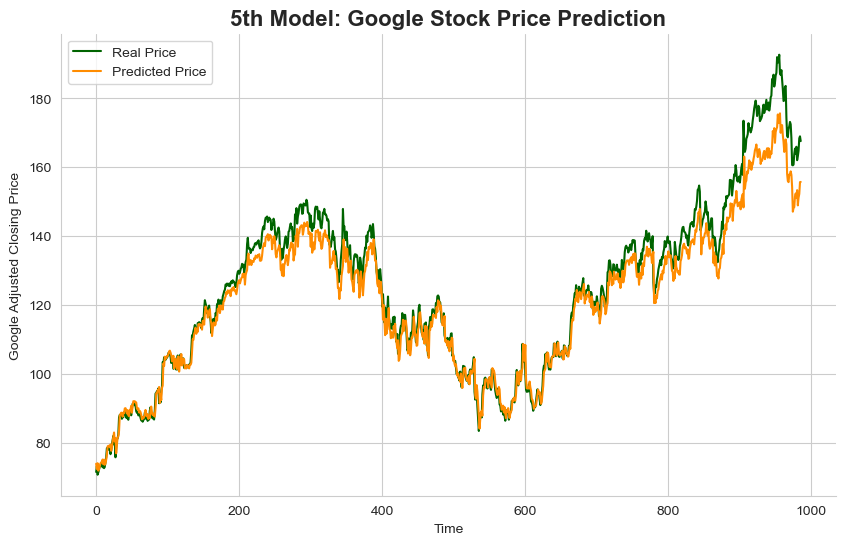

In [103]:
# Plot predicted and real adj close price for model evaluation

plt.figure(figsize = (10, 6))
sns.set_style('whitegrid')

plt.plot(original, color = 'darkgreen', label = 'Real Price')
plt.plot(preds5, color = 'darkorange', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Google Adjusted Closing Price')
plt.title('5th Model: Google Stock Price Prediction', fontweight = 'bold', fontsize = 16)
plt.legend()

sns.despine()
plt.show()

In [93]:
def build_model():
    grid_model = Sequential()
    grid_model.add(LSTM(128, return_sequences = True, input_shape = (21, 6)))
    grid_model.add(LSTM(64))
    grid_model.add(Dense(18))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse', optimizer = Adam())
    return grid_model


grid_model = KerasRegressor(build_fn = build_model,
                            verbose = 1, validation_data = (testX, testY))
parameters = {'batch_size' : [16, 24, 32],
              'epochs' : [20, 25, 30, 35]}
grid_search6  = GridSearchCV(estimator = grid_model,
                            param_grid = parameters,
                            cv = 4)

/var/folders/k6/rj6vyp8j659d9vfskgxrz_x40000gn/T/ipykernel_932/2400157920.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn = build_model,


In [ ]:
grid_search6 = grid_search6.fit(trainX, trainY, callbacks = [callback])

In [72]:
trainX.shape, trainY.shape

((4004, 21, 6), (4004,))

In [63]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(128, return_sequences = True, input_shape = (21, 6)))
    grid_model.add(LSTM(64, return_sequences = True))
    grid_model.add(LSTM(32))
    grid_model.add(Dense(8))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse', optimizer = optimizer)
    return grid_model


grid_model = KerasRegressor(build_fn = build_model,
                            verbose = 1, validation_data = (testX, testY))
parameters = {'batch_size' : [20, 24],
              'epochs' : [16, 20, 24], 'optimizer' : ['adam']}
grid_search4  = GridSearchCV(estimator = grid_model, param_grid = parameters, cv = 5)

/var/folders/k6/rj6vyp8j659d9vfskgxrz_x40000gn/T/ipykernel_932/18289169.py:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn = build_model,


In [64]:
%%time

grid_search4 = grid_search4.fit(trainX, trainY)

2024-08-22 17:59:01.870712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:59:01.873172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:59:01.875788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/16


2024-08-22 17:59:02.360396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:59:02.362133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:59:02.363700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

160/161 [============================>.] - ETA: 0s - loss: 0.0059

2024-08-22 17:59:19.983788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 17:59:19.984171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:59:20.371124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

161/161 [==============================] - 19s 67ms/step - loss: 0.0059 - val_loss: 0.1724
Epoch 2/16
161/161 [==============================] - 9s 55ms/step - loss: 5.5772e-04 - val_loss: 0.1509
Epoch 3/16
161/161 [==============================] - 7s 42ms/step - loss: 4.0893e-04 - val_loss: 0.0960
Epoch 4/16
161/161 [==============================] - 8s 47ms/step - loss: 3.8807e-04 - val_loss: 0.0688
Epoch 5/16
161/161 [==============================] - 7s 42ms/step - loss: 3.9688e-04 - val_loss: 0.0631
Epoch 6/16
161/161 [==============================] - 7s 43ms/step - loss: 3.5822e-04 - val_loss: 0.0560
Epoch 7/16
161/161 [==============================] - 7s 45ms/step - loss: 3.9389e-04 - val_loss: 0.0536
Epoch 8/16
161/161 [==============================] - 7s 44ms/step - loss: 3.2895e-04 - val_loss: 0.0327
Epoch 9/16
161/161 [==============================] - 7s 45ms/step - loss: 3.2474e-04 - val_loss: 0.0519
Epoch 10/16
161/161 [==============================] - 8s 47ms/step -

2024-08-22 18:01:11.885534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:01:11.886142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


41/41 [==============================] - 0s 10ms/step - loss: 9.3812e-05


2024-08-22 18:01:12.533773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:01:12.535169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:01:12.537126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/16


2024-08-22 18:01:13.001696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:01:13.004684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:01:13.007183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

160/161 [============================>.] - ETA: 0s - loss: 0.0078

2024-08-22 18:01:25.975156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:01:25.975557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:01:26.220962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

161/161 [==============================] - 14s 51ms/step - loss: 0.0078 - val_loss: 0.0914
Epoch 2/16
161/161 [==============================] - 7s 45ms/step - loss: 4.7059e-04 - val_loss: 0.0863
Epoch 3/16
161/161 [==============================] - 7s 46ms/step - loss: 3.5095e-04 - val_loss: 0.0753
Epoch 4/16
161/161 [==============================] - 8s 51ms/step - loss: 3.5047e-04 - val_loss: 0.0558
Epoch 5/16
161/161 [==============================] - 7s 45ms/step - loss: 3.7195e-04 - val_loss: 0.0421
Epoch 6/16
161/161 [==============================] - 7s 44ms/step - loss: 3.0692e-04 - val_loss: 0.0554
Epoch 7/16
161/161 [==============================] - 8s 49ms/step - loss: 3.0331e-04 - val_loss: 0.0418
Epoch 8/16
161/161 [==============================] - 7s 46ms/step - loss: 3.4447e-04 - val_loss: 0.0314
Epoch 9/16
161/161 [==============================] - 8s 48ms/step - loss: 2.9129e-04 - val_loss: 0.0382
Epoch 10/16
161/161 [==============================] - 7s 45ms/step -

2024-08-22 18:03:21.119317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:03:21.119711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


41/41 [==============================] - 0s 9ms/step - loss: 5.8043e-05


2024-08-22 18:03:21.747167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:03:21.749046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:03:21.750556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/16


2024-08-22 18:03:23.468601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3203]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:03:23.469032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3203]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:03:23.798103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim

160/161 [============================>.] - ETA: 0s - loss: 0.0044

2024-08-22 18:03:36.168019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:03:36.168316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:03:36.408545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

161/161 [==============================] - 14s 51ms/step - loss: 0.0044 - val_loss: 0.1396
Epoch 2/16
161/161 [==============================] - 7s 46ms/step - loss: 4.8508e-04 - val_loss: 0.1252
Epoch 3/16
161/161 [==============================] - 7s 43ms/step - loss: 3.8015e-04 - val_loss: 0.0898
Epoch 4/16
161/161 [==============================] - 7s 43ms/step - loss: 3.4882e-04 - val_loss: 0.0682
Epoch 5/16
161/161 [==============================] - 7s 46ms/step - loss: 3.4464e-04 - val_loss: 0.0650
Epoch 6/16
161/161 [==============================] - 8s 47ms/step - loss: 3.1718e-04 - val_loss: 0.0558
Epoch 7/16
161/161 [==============================] - 7s 43ms/step - loss: 3.5343e-04 - val_loss: 0.0504
Epoch 8/16
161/161 [==============================] - 7s 43ms/step - loss: 3.0523e-04 - val_loss: 0.0348
Epoch 9/16
161/161 [==============================] - 7s 46ms/step - loss: 3.0762e-04 - val_loss: 0.0414
Epoch 10/16
161/161 [==============================] - 7s 43ms/step -

2024-08-22 18:05:25.096685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:05:25.097022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


41/41 [==============================] - 0s 9ms/step - loss: 5.8554e-05


2024-08-22 18:05:25.709069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:05:25.710886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:05:25.712558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/16


2024-08-22 18:05:26.153868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:05:26.155930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:05:26.157732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

160/161 [============================>.] - ETA: 0s - loss: 0.0039

2024-08-22 18:05:38.923247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:05:38.923534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:05:39.163623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

161/161 [==============================] - 14s 53ms/step - loss: 0.0039 - val_loss: 0.1031
Epoch 2/16
161/161 [==============================] - 7s 42ms/step - loss: 4.8571e-04 - val_loss: 0.0995
Epoch 3/16
161/161 [==============================] - 7s 45ms/step - loss: 3.4183e-04 - val_loss: 0.0653
Epoch 4/16
161/161 [==============================] - 7s 43ms/step - loss: 3.3983e-04 - val_loss: 0.0483
Epoch 5/16
161/161 [==============================] - 7s 43ms/step - loss: 3.0202e-04 - val_loss: 0.0495
Epoch 6/16
161/161 [==============================] - 8s 47ms/step - loss: 3.2638e-04 - val_loss: 0.0549
Epoch 7/16
161/161 [==============================] - 7s 43ms/step - loss: 2.9282e-04 - val_loss: 0.0508
Epoch 8/16
161/161 [==============================] - 7s 45ms/step - loss: 2.9666e-04 - val_loss: 0.0236
Epoch 9/16
161/161 [==============================] - 7s 43ms/step - loss: 2.5505e-04 - val_loss: 0.0228
Epoch 10/16
161/161 [==============================] - 7s 45ms/step -

2024-08-22 18:07:26.475917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:07:26.476362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


41/41 [==============================] - 0s 9ms/step - loss: 1.3653e-04


2024-08-22 18:07:27.078294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:07:27.080759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:07:27.082660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/16


2024-08-22 18:07:27.528332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:07:27.530763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:07:27.532691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

160/161 [============================>.] - ETA: 0s - loss: 0.0016

2024-08-22 18:07:39.991905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:07:39.992389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:07:40.296471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

161/161 [==============================] - 14s 51ms/step - loss: 0.0016 - val_loss: 0.4091
Epoch 2/16
161/161 [==============================] - 7s 42ms/step - loss: 1.4989e-04 - val_loss: 0.3640
Epoch 3/16
161/161 [==============================] - 7s 42ms/step - loss: 1.4622e-04 - val_loss: 0.2856
Epoch 4/16
161/161 [==============================] - 7s 43ms/step - loss: 1.4794e-04 - val_loss: 0.2820
Epoch 5/16
161/161 [==============================] - 7s 45ms/step - loss: 1.5241e-04 - val_loss: 0.2319
Epoch 6/16
161/161 [==============================] - 8s 47ms/step - loss: 1.2709e-04 - val_loss: 0.2257
Epoch 7/16
161/161 [==============================] - 7s 42ms/step - loss: 1.1999e-04 - val_loss: 0.2234
Epoch 8/16
161/161 [==============================] - 7s 42ms/step - loss: 1.2749e-04 - val_loss: 0.2196
Epoch 9/16
161/161 [==============================] - 7s 45ms/step - loss: 1.1424e-04 - val_loss: 0.1673
Epoch 10/16
161/161 [==============================] - 7s 42ms/step -

2024-08-22 18:09:27.266777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [800]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:09:27.267175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [800]
	 [[{{node Placeholder/_11}}]]


40/40 [==============================] - 0s 9ms/step - loss: 6.7560e-04


2024-08-22 18:09:27.868590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:09:27.870397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:09:27.872163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 18:09:28.344014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:09:28.346756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:09:28.348309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

161/161 [==============================] - ETA: 0s - loss: 0.0061

2024-08-22 18:09:41.438061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:09:41.438388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:09:41.680717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

161/161 [==============================] - 14s 49ms/step - loss: 0.0061 - val_loss: 0.1664
Epoch 2/20
161/161 [==============================] - 7s 44ms/step - loss: 5.3839e-04 - val_loss: 0.1577
Epoch 3/20
161/161 [==============================] - 7s 42ms/step - loss: 3.7272e-04 - val_loss: 0.1072
Epoch 4/20
161/161 [==============================] - 7s 43ms/step - loss: 3.8991e-04 - val_loss: 0.0782
Epoch 5/20
161/161 [==============================] - 7s 43ms/step - loss: 3.6529e-04 - val_loss: 0.0691
Epoch 6/20
161/161 [==============================] - 7s 44ms/step - loss: 3.3541e-04 - val_loss: 0.0678
Epoch 7/20
161/161 [==============================] - 7s 42ms/step - loss: 3.7342e-04 - val_loss: 0.0634
Epoch 8/20
161/161 [==============================] - 7s 42ms/step - loss: 3.2284e-04 - val_loss: 0.0391
Epoch 9/20
161/161 [==============================] - 7s 46ms/step - loss: 3.2444e-04 - val_loss: 0.0579
Epoch 10/20
161/161 [==============================] - 7s 46ms/step -

2024-08-22 18:11:55.736978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:11:55.737318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


41/41 [==============================] - 0s 9ms/step - loss: 5.3462e-05


2024-08-22 18:11:56.340967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:11:56.343039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:11:56.344551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 18:11:56.766177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:11:56.768314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:11:56.769847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

160/161 [============================>.] - ETA: 0s - loss: 0.0044

2024-08-22 18:12:08.587517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:12:08.587811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:12:08.822453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

161/161 [==============================] - 13s 48ms/step - loss: 0.0044 - val_loss: 0.1219
Epoch 2/20
161/161 [==============================] - 8s 49ms/step - loss: 4.7934e-04 - val_loss: 0.1134
Epoch 3/20
161/161 [==============================] - 7s 41ms/step - loss: 3.8826e-04 - val_loss: 0.0807
Epoch 4/20
161/161 [==============================] - 7s 41ms/step - loss: 3.5642e-04 - val_loss: 0.0656
Epoch 5/20
161/161 [==============================] - 7s 45ms/step - loss: 3.5083e-04 - val_loss: 0.0739
Epoch 6/20
161/161 [==============================] - 7s 42ms/step - loss: 3.3356e-04 - val_loss: 0.0611
Epoch 7/20
161/161 [==============================] - 7s 41ms/step - loss: 3.8124e-04 - val_loss: 0.0488
Epoch 8/20
161/161 [==============================] - 7s 45ms/step - loss: 3.0932e-04 - val_loss: 0.0367
Epoch 9/20
161/161 [==============================] - 7s 43ms/step - loss: 2.9512e-04 - val_loss: 0.0453
Epoch 10/20
161/161 [==============================] - 7s 45ms/step -

2024-08-22 18:14:22.615796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [801,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 18:14:22.616151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


41/41 [==============================] - 0s 9ms/step - loss: 1.1209e-04


2024-08-22 18:14:23.215980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:14:23.217374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:14:23.218837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 18:14:23.659228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:14:23.660947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:14:23.662405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

161/161 [==============================] - ETA: 0s - loss: 0.0051

2024-08-22 18:14:36.124251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:14:36.124586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:14:36.358698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

161/161 [==============================] - 14s 52ms/step - loss: 0.0051 - val_loss: 0.1314
Epoch 2/20
161/161 [==============================] - 7s 46ms/step - loss: 5.2237e-04 - val_loss: 0.1231
Epoch 3/20
161/161 [==============================] - 7s 42ms/step - loss: 3.6226e-04 - val_loss: 0.0915
Epoch 4/20
161/161 [==============================] - 7s 42ms/step - loss: 3.6796e-04 - val_loss: 0.0621
Epoch 5/20
161/161 [==============================] - 7s 46ms/step - loss: 3.3709e-04 - val_loss: 0.0547
Epoch 6/20
161/161 [==============================] - 7s 41ms/step - loss: 3.0652e-04 - val_loss: 0.0581
Epoch 7/20
161/161 [==============================] - 7s 42ms/step - loss: 3.2529e-04 - val_loss: 0.0545
Epoch 8/20
161/161 [==============================] - 7s 45ms/step - loss: 3.1030e-04 - val_loss: 0.0344
Epoch 9/20
161/161 [==============================] - 7s 41ms/step - loss: 3.0539e-04 - val_loss: 0.0436
Epoch 10/20
161/161 [==============================] - 7s 42ms/step -

2024-08-22 18:16:49.502489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:16:49.502910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


41/41 [==============================] - 0s 9ms/step - loss: 7.0921e-05


2024-08-22 18:16:50.107022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:16:50.108863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:16:50.110712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 18:16:50.546895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:16:50.548973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:16:50.550815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

161/161 [==============================] - ETA: 0s - loss: 0.0033

2024-08-22 18:17:02.829810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:17:02.830459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:17:03.070820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

161/161 [==============================] - 14s 48ms/step - loss: 0.0033 - val_loss: 0.1401
Epoch 2/20
161/161 [==============================] - 7s 42ms/step - loss: 5.4884e-04 - val_loss: 0.1355
Epoch 3/20
161/161 [==============================] - 7s 44ms/step - loss: 3.5366e-04 - val_loss: 0.0868
Epoch 4/20
161/161 [==============================] - 7s 45ms/step - loss: 3.5561e-04 - val_loss: 0.0605
Epoch 5/20
161/161 [==============================] - 7s 42ms/step - loss: 3.2131e-04 - val_loss: 0.0644
Epoch 6/20
161/161 [==============================] - 7s 42ms/step - loss: 3.4294e-04 - val_loss: 0.0788
Epoch 7/20
161/161 [==============================] - 7s 45ms/step - loss: 2.8947e-04 - val_loss: 0.0638
Epoch 8/20
161/161 [==============================] - 7s 42ms/step - loss: 3.1410e-04 - val_loss: 0.0360
Epoch 9/20
161/161 [==============================] - 7s 42ms/step - loss: 2.5455e-04 - val_loss: 0.0357
Epoch 10/20
161/161 [==============================] - 7s 45ms/step -

2024-08-22 18:19:16.544631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:19:16.544923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


41/41 [==============================] - 0s 9ms/step - loss: 2.0468e-04


2024-08-22 18:19:17.153734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:19:17.155559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:19:17.157310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 18:19:17.589638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:19:17.591451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:19:17.593249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

161/161 [==============================] - ETA: 0s - loss: 0.0027

2024-08-22 18:19:29.537142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 18:19:29.537442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:19:30.962446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

161/161 [==============================] - 15s 57ms/step - loss: 0.0027 - val_loss: 0.2347
Epoch 2/20
161/161 [==============================] - 7s 41ms/step - loss: 1.5649e-04 - val_loss: 0.2494
Epoch 3/20
161/161 [==============================] - 7s 41ms/step - loss: 1.4609e-04 - val_loss: 0.2111
Epoch 4/20
161/161 [==============================] - 7s 42ms/step - loss: 1.4563e-04 - val_loss: 0.2020
Epoch 5/20
161/161 [==============================] - 7s 42ms/step - loss: 1.4868e-04 - val_loss: 0.1665
Epoch 6/20
161/161 [==============================] - 7s 45ms/step - loss: 1.4355e-04 - val_loss: 0.1673
Epoch 7/20
161/161 [==============================] - 7s 43ms/step - loss: 1.2291e-04 - val_loss: 0.1458
Epoch 8/20
161/161 [==============================] - 7s 42ms/step - loss: 1.4470e-04 - val_loss: 0.1443
Epoch 9/20
161/161 [==============================] - 7s 41ms/step - loss: 1.2661e-04 - val_loss: 0.1120
Epoch 10/20
161/161 [==============================] - 7s 44ms/step -

2024-08-22 18:21:42.062076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [800]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:21:42.062410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [800]
	 [[{{node Placeholder/_11}}]]


40/40 [==============================] - 0s 9ms/step - loss: 4.3664e-04


2024-08-22 18:21:42.659413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:21:42.661426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:21:42.662780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 18:21:43.106010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:21:43.108433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:21:43.110655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

161/161 [==============================] - ETA: 0s - loss: 0.0044

2024-08-22 18:21:55.500378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:21:55.500703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:21:55.749807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

161/161 [==============================] - 14s 49ms/step - loss: 0.0044 - val_loss: 0.1113
Epoch 2/24
161/161 [==============================] - 7s 42ms/step - loss: 4.9587e-04 - val_loss: 0.1050
Epoch 3/24
161/161 [==============================] - 7s 42ms/step - loss: 3.5812e-04 - val_loss: 0.0632
Epoch 4/24
161/161 [==============================] - 8s 47ms/step - loss: 3.4831e-04 - val_loss: 0.0530
Epoch 5/24
161/161 [==============================] - 7s 42ms/step - loss: 3.6681e-04 - val_loss: 0.0516
Epoch 6/24
161/161 [==============================] - 7s 42ms/step - loss: 3.2316e-04 - val_loss: 0.0519
Epoch 7/24
161/161 [==============================] - 7s 45ms/step - loss: 3.7234e-04 - val_loss: 0.0492
Epoch 8/24
161/161 [==============================] - 7s 42ms/step - loss: 3.0164e-04 - val_loss: 0.0297
Epoch 9/24
161/161 [==============================] - 7s 42ms/step - loss: 2.9425e-04 - val_loss: 0.0448
Epoch 10/24
161/161 [==============================] - 7s 42ms/step -

2024-08-22 18:24:37.487997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:24:37.488294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


41/41 [==============================] - 0s 9ms/step - loss: 7.0366e-05


2024-08-22 18:24:38.097552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:24:38.099412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:24:38.101223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 18:24:38.520636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:24:38.522800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:24:38.524751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

161/161 [==============================] - ETA: 0s - loss: 0.0049

2024-08-22 18:24:50.473363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:24:50.473695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:24:50.716075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

161/161 [==============================] - 13s 48ms/step - loss: 0.0049 - val_loss: 0.1816
Epoch 2/24
161/161 [==============================] - 7s 45ms/step - loss: 4.3884e-04 - val_loss: 0.1564
Epoch 3/24
161/161 [==============================] - 7s 42ms/step - loss: 3.7799e-04 - val_loss: 0.1063
Epoch 4/24
161/161 [==============================] - 7s 46ms/step - loss: 3.6743e-04 - val_loss: 0.0728
Epoch 5/24
161/161 [==============================] - 7s 42ms/step - loss: 3.3949e-04 - val_loss: 0.0826
Epoch 6/24
161/161 [==============================] - 7s 42ms/step - loss: 3.2727e-04 - val_loss: 0.0578
Epoch 7/24
161/161 [==============================] - 7s 45ms/step - loss: 3.8418e-04 - val_loss: 0.0489
Epoch 8/24
161/161 [==============================] - 7s 42ms/step - loss: 3.0701e-04 - val_loss: 0.0320
Epoch 9/24
161/161 [==============================] - 7s 43ms/step - loss: 2.9634e-04 - val_loss: 0.0344
Epoch 10/24
161/161 [==============================] - 7s 45ms/step -

2024-08-22 18:28:05.643616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:28:05.643997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


41/41 [==============================] - 0s 9ms/step - loss: 7.1893e-05


2024-08-22 18:28:06.218071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:28:06.219848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:28:06.221497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 18:28:06.596823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:28:06.598629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:28:06.600303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

160/161 [============================>.] - ETA: 0s - loss: 0.0052

2024-08-22 18:28:18.047425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:28:18.047720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:28:18.258982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

161/161 [==============================] - 13s 48ms/step - loss: 0.0052 - val_loss: 0.1158
Epoch 2/24
161/161 [==============================] - 6s 40ms/step - loss: 4.7790e-04 - val_loss: 0.1097
Epoch 3/24
161/161 [==============================] - 6s 40ms/step - loss: 3.4866e-04 - val_loss: 0.0844
Epoch 4/24
161/161 [==============================] - 7s 43ms/step - loss: 3.4644e-04 - val_loss: 0.0584
Epoch 5/24
161/161 [==============================] - 6s 40ms/step - loss: 3.3482e-04 - val_loss: 0.0514
Epoch 6/24
161/161 [==============================] - 7s 41ms/step - loss: 3.0102e-04 - val_loss: 0.0532
Epoch 7/24
161/161 [==============================] - 7s 44ms/step - loss: 3.2705e-04 - val_loss: 0.0503
Epoch 8/24
161/161 [==============================] - 7s 41ms/step - loss: 3.1279e-04 - val_loss: 0.0338
Epoch 9/24
161/161 [==============================] - 7s 46ms/step - loss: 3.0349e-04 - val_loss: 0.0422
Epoch 10/24
161/161 [==============================] - 7s 42ms/step -

2024-08-22 18:30:58.618436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [801,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 18:30:58.618729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


41/41 [==============================] - 0s 9ms/step - loss: 4.2711e-05


2024-08-22 18:30:59.226393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:30:59.228139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:30:59.229888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 18:30:59.659616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:30:59.662410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:30:59.664293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

161/161 [==============================] - ETA: 0s - loss: 0.0059

2024-08-22 18:31:11.990123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:31:11.990489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:31:12.231686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

161/161 [==============================] - 14s 49ms/step - loss: 0.0059 - val_loss: 0.1279
Epoch 2/24
161/161 [==============================] - 7s 42ms/step - loss: 4.9234e-04 - val_loss: 0.1108
Epoch 3/24
161/161 [==============================] - 7s 45ms/step - loss: 3.4853e-04 - val_loss: 0.0821
Epoch 4/24
161/161 [==============================] - 7s 42ms/step - loss: 3.2107e-04 - val_loss: 0.0605
Epoch 5/24
161/161 [==============================] - 7s 42ms/step - loss: 3.5550e-04 - val_loss: 0.0607
Epoch 6/24
161/161 [==============================] - 7s 45ms/step - loss: 3.1425e-04 - val_loss: 0.0797
Epoch 7/24
161/161 [==============================] - 7s 42ms/step - loss: 3.0220e-04 - val_loss: 0.0597
Epoch 8/24
161/161 [==============================] - 7s 42ms/step - loss: 3.4443e-04 - val_loss: 0.0324
Epoch 9/24
161/161 [==============================] - 7s 42ms/step - loss: 2.6995e-04 - val_loss: 0.0350
Epoch 10/24
161/161 [==============================] - 8s 52ms/step -

2024-08-22 18:33:54.426150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:33:54.426434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


41/41 [==============================] - 0s 9ms/step - loss: 8.9066e-05


2024-08-22 18:33:55.017867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:33:55.019198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:33:55.020785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 18:33:55.450185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:33:55.451980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:33:55.453706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

161/161 [==============================] - ETA: 0s - loss: 0.0019

2024-08-22 18:34:08.654375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:34:08.654654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:34:08.894455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

161/161 [==============================] - 15s 48ms/step - loss: 0.0019 - val_loss: 0.2443
Epoch 2/24
161/161 [==============================] - 7s 46ms/step - loss: 1.4448e-04 - val_loss: 0.2384
Epoch 3/24
161/161 [==============================] - 7s 42ms/step - loss: 1.3874e-04 - val_loss: 0.1738
Epoch 4/24
161/161 [==============================] - 7s 42ms/step - loss: 1.3555e-04 - val_loss: 0.1846
Epoch 5/24
161/161 [==============================] - 7s 45ms/step - loss: 1.3887e-04 - val_loss: 0.1347
Epoch 6/24
161/161 [==============================] - 7s 46ms/step - loss: 1.2882e-04 - val_loss: 0.1324
Epoch 7/24
161/161 [==============================] - 7s 42ms/step - loss: 1.1908e-04 - val_loss: 0.1488
Epoch 8/24
161/161 [==============================] - 7s 42ms/step - loss: 1.2727e-04 - val_loss: 0.1441
Epoch 9/24
161/161 [==============================] - 7s 45ms/step - loss: 1.1432e-04 - val_loss: 0.1075
Epoch 10/24
161/161 [==============================] - 7s 42ms/step -

2024-08-22 18:36:51.703791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [800]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:36:51.704102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [800]
	 [[{{node Placeholder/_11}}]]


40/40 [==============================] - 0s 9ms/step - loss: 4.0268e-04


2024-08-22 18:36:52.308637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:36:52.310760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:36:52.311986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/16


2024-08-22 18:36:52.868160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:36:52.869838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:36:52.871436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0061

2024-08-22 18:37:04.339036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:37:04.339336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:37:04.568885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 13s 52ms/step - loss: 0.0060 - val_loss: 0.1337
Epoch 2/16
134/134 [==============================] - 6s 44ms/step - loss: 4.8211e-04 - val_loss: 0.1192
Epoch 3/16
134/134 [==============================] - 6s 44ms/step - loss: 3.6927e-04 - val_loss: 0.0874
Epoch 4/16
134/134 [==============================] - 6s 45ms/step - loss: 3.7118e-04 - val_loss: 0.0693
Epoch 5/16
134/134 [==============================] - 6s 46ms/step - loss: 4.5075e-04 - val_loss: 0.0633
Epoch 6/16
134/134 [==============================] - 6s 44ms/step - loss: 3.0770e-04 - val_loss: 0.0770
Epoch 7/16
134/134 [==============================] - 6s 44ms/step - loss: 3.5618e-04 - val_loss: 0.0481
Epoch 8/16
134/134 [==============================] - 6s 48ms/step - loss: 3.2664e-04 - val_loss: 0.0323
Epoch 9/16
134/134 [==============================] - 6s 44ms/step - loss: 2.9286e-04 - val_loss: 0.0523
Epoch 10/16
134/134 [==============================] - 6s 44ms/step -

2024-08-22 18:38:36.699246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:38:36.699552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 10ms/step - loss: 1.5604e-04


2024-08-22 18:38:37.266082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:38:37.268267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:38:37.269743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/16


2024-08-22 18:38:37.724882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:38:37.726924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:38:37.728766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0054

2024-08-22 18:38:48.858546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 18:38:48.858824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:38:49.103352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

134/134 [==============================] - 12s 52ms/step - loss: 0.0054 - val_loss: 0.1758
Epoch 2/16
134/134 [==============================] - 6s 44ms/step - loss: 6.2233e-04 - val_loss: 0.1638
Epoch 3/16
134/134 [==============================] - 6s 44ms/step - loss: 4.0256e-04 - val_loss: 0.1243
Epoch 4/16
134/134 [==============================] - 6s 48ms/step - loss: 4.3560e-04 - val_loss: 0.1074
Epoch 5/16
134/134 [==============================] - 6s 45ms/step - loss: 4.9442e-04 - val_loss: 0.0842
Epoch 6/16
134/134 [==============================] - 6s 44ms/step - loss: 3.2199e-04 - val_loss: 0.0962
Epoch 7/16
134/134 [==============================] - 6s 48ms/step - loss: 3.6179e-04 - val_loss: 0.0644
Epoch 8/16
134/134 [==============================] - 6s 43ms/step - loss: 3.2532e-04 - val_loss: 0.0469
Epoch 9/16
134/134 [==============================] - 6s 44ms/step - loss: 3.0647e-04 - val_loss: 0.0622
Epoch 10/16
134/134 [==============================] - 6s 47ms/step -

2024-08-22 18:40:21.571189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:40:21.571549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 10ms/step - loss: 1.1227e-04


2024-08-22 18:40:22.141945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:40:22.143823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:40:22.145644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/16


2024-08-22 18:40:22.576862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:40:22.578880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:40:22.580367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0053

2024-08-22 18:40:34.240070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:40:34.240362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:40:34.463563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 13s 56ms/step - loss: 0.0053 - val_loss: 0.0948
Epoch 2/16
134/134 [==============================] - 6s 43ms/step - loss: 4.5485e-04 - val_loss: 0.0776
Epoch 3/16
134/134 [==============================] - 6s 44ms/step - loss: 3.5575e-04 - val_loss: 0.0662
Epoch 4/16
134/134 [==============================] - 6s 45ms/step - loss: 3.4993e-04 - val_loss: 0.0634
Epoch 5/16
134/134 [==============================] - 6s 46ms/step - loss: 4.2915e-04 - val_loss: 0.0523
Epoch 6/16
134/134 [==============================] - 6s 43ms/step - loss: 2.9257e-04 - val_loss: 0.0764
Epoch 7/16
134/134 [==============================] - 6s 48ms/step - loss: 3.2538e-04 - val_loss: 0.0504
Epoch 8/16
134/134 [==============================] - 6s 44ms/step - loss: 3.0025e-04 - val_loss: 0.0373
Epoch 9/16
134/134 [==============================] - 6s 44ms/step - loss: 2.9325e-04 - val_loss: 0.0492
Epoch 10/16
134/134 [==============================] - 6s 45ms/step -

2024-08-22 18:42:06.718293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:42:06.718700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 12ms/step - loss: 1.1834e-04


2024-08-22 18:42:07.349643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:42:07.351452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:42:07.353408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/16


2024-08-22 18:42:07.789034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:42:07.791214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:42:07.793452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0049

2024-08-22 18:42:20.439159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:42:20.439567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:42:20.668863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 14s 52ms/step - loss: 0.0049 - val_loss: 0.1501
Epoch 2/16
134/134 [==============================] - 6s 44ms/step - loss: 4.6733e-04 - val_loss: 0.1325
Epoch 3/16
134/134 [==============================] - 6s 46ms/step - loss: 3.5666e-04 - val_loss: 0.1030
Epoch 4/16
134/134 [==============================] - 6s 45ms/step - loss: 3.4669e-04 - val_loss: 0.0976
Epoch 5/16
134/134 [==============================] - 6s 44ms/step - loss: 3.0991e-04 - val_loss: 0.0707
Epoch 6/16
134/134 [==============================] - 6s 44ms/step - loss: 2.9135e-04 - val_loss: 0.1044
Epoch 7/16
134/134 [==============================] - 6s 44ms/step - loss: 3.4985e-04 - val_loss: 0.0672
Epoch 8/16
134/134 [==============================] - 6s 45ms/step - loss: 2.8100e-04 - val_loss: 0.0481
Epoch 9/16
134/134 [==============================] - 7s 49ms/step - loss: 2.9704e-04 - val_loss: 0.0576
Epoch 10/16
134/134 [==============================] - 6s 44ms/step -

2024-08-22 18:43:52.817461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:43:52.817759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 10ms/step - loss: 1.4238e-04


2024-08-22 18:43:53.393722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:43:53.395701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:43:53.397209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/16


2024-08-22 18:43:53.828457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:43:53.831080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:43:53.832884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0046

2024-08-22 18:44:05.419865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:44:05.420158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:44:05.648995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 13s 55ms/step - loss: 0.0046 - val_loss: 0.3949
Epoch 2/16
134/134 [==============================] - 6s 45ms/step - loss: 1.7401e-04 - val_loss: 0.4002
Epoch 3/16
134/134 [==============================] - 6s 48ms/step - loss: 1.6340e-04 - val_loss: 0.3721
Epoch 4/16
134/134 [==============================] - 6s 44ms/step - loss: 1.5095e-04 - val_loss: 0.3481
Epoch 5/16
134/134 [==============================] - 6s 44ms/step - loss: 1.3831e-04 - val_loss: 0.2994
Epoch 6/16
134/134 [==============================] - 6s 48ms/step - loss: 1.2553e-04 - val_loss: 0.3028
Epoch 7/16
134/134 [==============================] - 6s 44ms/step - loss: 1.3550e-04 - val_loss: 0.2726
Epoch 8/16
134/134 [==============================] - 6s 44ms/step - loss: 1.4253e-04 - val_loss: 0.2513
Epoch 9/16
134/134 [==============================] - 6s 47ms/step - loss: 1.2695e-04 - val_loss: 0.2258
Epoch 10/16
134/134 [==============================] - 6s 45ms/step -

2024-08-22 18:45:38.094197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [800]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:45:38.094579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [800]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 10ms/step - loss: 7.4017e-04


2024-08-22 18:45:38.657229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:45:38.658873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:45:38.660572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 18:45:39.108614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:45:39.111350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:45:39.113270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0050

2024-08-22 18:45:50.672518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:45:50.672813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:45:50.915314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 13s 52ms/step - loss: 0.0049 - val_loss: 0.1033
Epoch 2/20
134/134 [==============================] - 6s 44ms/step - loss: 4.8887e-04 - val_loss: 0.1008
Epoch 3/20
134/134 [==============================] - 6s 47ms/step - loss: 3.8959e-04 - val_loss: 0.0619
Epoch 4/20
134/134 [==============================] - 6s 44ms/step - loss: 3.6872e-04 - val_loss: 0.0462
Epoch 5/20
134/134 [==============================] - 7s 50ms/step - loss: 3.5350e-04 - val_loss: 0.0370
Epoch 6/20
134/134 [==============================] - 6s 44ms/step - loss: 3.1423e-04 - val_loss: 0.0590
Epoch 7/20
134/134 [==============================] - 6s 44ms/step - loss: 3.6814e-04 - val_loss: 0.0318
Epoch 8/20
134/134 [==============================] - 6s 48ms/step - loss: 3.0753e-04 - val_loss: 0.0211
Epoch 9/20
134/134 [==============================] - 6s 44ms/step - loss: 3.0115e-04 - val_loss: 0.0449
Epoch 10/20
134/134 [==============================] - 6s 44ms/step -

2024-08-22 18:47:47.773467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:47:47.773826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 10ms/step - loss: 1.0248e-04


2024-08-22 18:47:48.344296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:47:48.345636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:47:48.347285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 18:47:48.781681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:47:48.783671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:47:48.785443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0064

2024-08-22 18:47:59.914296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:47:59.914617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:48:00.148010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 12s 52ms/step - loss: 0.0063 - val_loss: 0.1308
Epoch 2/20
134/134 [==============================] - 6s 47ms/step - loss: 5.7928e-04 - val_loss: 0.1331
Epoch 3/20
134/134 [==============================] - 6s 47ms/step - loss: 3.9045e-04 - val_loss: 0.1042
Epoch 4/20
134/134 [==============================] - 6s 44ms/step - loss: 4.3024e-04 - val_loss: 0.0936
Epoch 5/20
134/134 [==============================] - 6s 44ms/step - loss: 5.0163e-04 - val_loss: 0.0804
Epoch 6/20
134/134 [==============================] - 6s 44ms/step - loss: 3.2668e-04 - val_loss: 0.0932
Epoch 7/20
134/134 [==============================] - 6s 48ms/step - loss: 3.5815e-04 - val_loss: 0.0680
Epoch 8/20
134/134 [==============================] - 6s 44ms/step - loss: 3.4113e-04 - val_loss: 0.0475
Epoch 9/20
134/134 [==============================] - 6s 44ms/step - loss: 3.1074e-04 - val_loss: 0.0639
Epoch 10/20
134/134 [==============================] - 6s 48ms/step -

2024-08-22 18:49:56.993580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:49:56.994066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 10ms/step - loss: 4.8534e-05


2024-08-22 18:49:57.558232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:49:57.560104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:49:57.561948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 18:49:57.997163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:49:57.999963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:49:58.001520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0063

2024-08-22 18:50:10.421530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 18:50:10.421924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:50:10.663835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

134/134 [==============================] - 14s 52ms/step - loss: 0.0063 - val_loss: 0.1039
Epoch 2/20
134/134 [==============================] - 7s 49ms/step - loss: 4.6214e-04 - val_loss: 0.0925
Epoch 3/20
134/134 [==============================] - 6s 44ms/step - loss: 3.5691e-04 - val_loss: 0.0736
Epoch 4/20
134/134 [==============================] - 6s 43ms/step - loss: 3.5543e-04 - val_loss: 0.0656
Epoch 5/20
134/134 [==============================] - 6s 48ms/step - loss: 4.4574e-04 - val_loss: 0.0530
Epoch 6/20
134/134 [==============================] - 6s 47ms/step - loss: 2.9356e-04 - val_loss: 0.0708
Epoch 7/20
134/134 [==============================] - 6s 45ms/step - loss: 3.2318e-04 - val_loss: 0.0467
Epoch 8/20
134/134 [==============================] - 6s 44ms/step - loss: 3.0530e-04 - val_loss: 0.0322
Epoch 9/20
134/134 [==============================] - 6s 43ms/step - loss: 3.0715e-04 - val_loss: 0.0424
Epoch 10/20
134/134 [==============================] - 6s 48ms/step -

2024-08-22 18:52:07.429348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [801,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 18:52:07.429658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 10ms/step - loss: 9.7657e-05


2024-08-22 18:52:07.986471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:52:07.988262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:52:07.990029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 18:52:08.422758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:52:08.424780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:52:08.426614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0058

2024-08-22 18:52:19.817340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:52:19.817641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:52:20.049425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 13s 52ms/step - loss: 0.0058 - val_loss: 0.1501
Epoch 2/20
134/134 [==============================] - 6s 43ms/step - loss: 4.6223e-04 - val_loss: 0.1117
Epoch 3/20
134/134 [==============================] - 6s 45ms/step - loss: 3.4699e-04 - val_loss: 0.0765
Epoch 4/20
134/134 [==============================] - 6s 45ms/step - loss: 3.4109e-04 - val_loss: 0.0741
Epoch 5/20
134/134 [==============================] - 6s 43ms/step - loss: 3.0839e-04 - val_loss: 0.0555
Epoch 6/20
134/134 [==============================] - 6s 44ms/step - loss: 2.8303e-04 - val_loss: 0.0941
Epoch 7/20
134/134 [==============================] - 6s 48ms/step - loss: 3.1668e-04 - val_loss: 0.0570
Epoch 8/20
134/134 [==============================] - 6s 43ms/step - loss: 2.7003e-04 - val_loss: 0.0472
Epoch 9/20
134/134 [==============================] - 6s 44ms/step - loss: 2.9784e-04 - val_loss: 0.0557
Epoch 10/20
134/134 [==============================] - 6s 48ms/step -

2024-08-22 18:54:16.226705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:54:16.227045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 10ms/step - loss: 1.1071e-04


2024-08-22 18:54:16.842677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:54:16.844077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:54:16.845701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2024-08-22 18:54:17.290153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:54:17.291954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:54:17.293898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0024

2024-08-22 18:54:28.348484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 18:54:28.348880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:54:28.599337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

134/134 [==============================] - 12s 52ms/step - loss: 0.0024 - val_loss: 0.2721
Epoch 2/20
134/134 [==============================] - 6s 47ms/step - loss: 1.5128e-04 - val_loss: 0.2999
Epoch 3/20
134/134 [==============================] - 6s 44ms/step - loss: 1.3304e-04 - val_loss: 0.2488
Epoch 4/20
134/134 [==============================] - 6s 44ms/step - loss: 1.5934e-04 - val_loss: 0.2608
Epoch 5/20
134/134 [==============================] - 6s 44ms/step - loss: 1.2664e-04 - val_loss: 0.2096
Epoch 6/20
134/134 [==============================] - 6s 44ms/step - loss: 1.3070e-04 - val_loss: 0.1974
Epoch 7/20
134/134 [==============================] - 7s 49ms/step - loss: 1.3165e-04 - val_loss: 0.1866
Epoch 8/20
134/134 [==============================] - 6s 44ms/step - loss: 1.5720e-04 - val_loss: 0.1837
Epoch 9/20
134/134 [==============================] - 6s 46ms/step - loss: 1.4086e-04 - val_loss: 0.1544
Epoch 10/20
134/134 [==============================] - 6s 48ms/step -

2024-08-22 18:56:26.675080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [800]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:56:26.675358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [800]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 10ms/step - loss: 7.3905e-04


2024-08-22 18:56:27.537512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:56:27.539333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:56:27.540732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 18:56:27.962483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:56:27.964340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:56:27.965941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0050

2024-08-22 18:56:39.451442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:56:39.451732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:56:39.680230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 13s 53ms/step - loss: 0.0050 - val_loss: 0.0761
Epoch 2/24
134/134 [==============================] - 6s 43ms/step - loss: 5.0264e-04 - val_loss: 0.0791
Epoch 3/24
134/134 [==============================] - 6s 44ms/step - loss: 3.6571e-04 - val_loss: 0.0578
Epoch 4/24
134/134 [==============================] - 6s 47ms/step - loss: 3.7318e-04 - val_loss: 0.0511
Epoch 5/24
134/134 [==============================] - 6s 44ms/step - loss: 4.4955e-04 - val_loss: 0.0483
Epoch 6/24
134/134 [==============================] - 6s 45ms/step - loss: 3.0425e-04 - val_loss: 0.0676
Epoch 7/24
134/134 [==============================] - 6s 43ms/step - loss: 3.5910e-04 - val_loss: 0.0387
Epoch 8/24
134/134 [==============================] - 6s 44ms/step - loss: 3.1533e-04 - val_loss: 0.0242
Epoch 9/24
134/134 [==============================] - 6s 47ms/step - loss: 2.8936e-04 - val_loss: 0.0442
Epoch 10/24
134/134 [==============================] - 6s 44ms/step -

2024-08-22 18:58:59.322409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:58:59.322702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 10ms/step - loss: 1.5047e-04


2024-08-22 18:58:59.883020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:58:59.884842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:58:59.886445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 18:59:00.316693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 18:59:00.318557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 18:59:00.320234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0054

2024-08-22 18:59:11.944603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:59:11.944989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 18:59:13.513648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 14s 62ms/step - loss: 0.0054 - val_loss: 0.1259
Epoch 2/24
134/134 [==============================] - 6s 43ms/step - loss: 4.9807e-04 - val_loss: 0.1145
Epoch 3/24
134/134 [==============================] - 7s 49ms/step - loss: 3.8058e-04 - val_loss: 0.0859
Epoch 4/24
134/134 [==============================] - 6s 44ms/step - loss: 3.9501e-04 - val_loss: 0.0721
Epoch 5/24
134/134 [==============================] - 6s 44ms/step - loss: 4.6795e-04 - val_loss: 0.0504
Epoch 6/24
134/134 [==============================] - 6s 48ms/step - loss: 3.2393e-04 - val_loss: 0.0631
Epoch 7/24
134/134 [==============================] - 6s 44ms/step - loss: 3.6710e-04 - val_loss: 0.0350
Epoch 8/24
134/134 [==============================] - 6s 44ms/step - loss: 3.1686e-04 - val_loss: 0.0239
Epoch 9/24
134/134 [==============================] - 6s 44ms/step - loss: 2.9547e-04 - val_loss: 0.0347
Epoch 10/24
134/134 [==============================] - 6s 48ms/step -

2024-08-22 19:01:37.215114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [801,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 19:01:37.215402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 10ms/step - loss: 4.3219e-05


2024-08-22 19:01:37.803302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:01:37.805046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:01:37.806913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 19:01:38.228957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:01:38.230855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:01:38.232411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0076

2024-08-22 19:01:49.420817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:01:49.421257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:01:49.659863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 12s 52ms/step - loss: 0.0076 - val_loss: 0.1036
Epoch 2/24
134/134 [==============================] - 6s 48ms/step - loss: 5.2720e-04 - val_loss: 0.0881
Epoch 3/24
134/134 [==============================] - 6s 43ms/step - loss: 3.7804e-04 - val_loss: 0.0705
Epoch 4/24
134/134 [==============================] - 6s 48ms/step - loss: 3.7564e-04 - val_loss: 0.0682
Epoch 5/24
134/134 [==============================] - 6s 46ms/step - loss: 4.3376e-04 - val_loss: 0.0487
Epoch 6/24
134/134 [==============================] - 6s 44ms/step - loss: 3.0738e-04 - val_loss: 0.0749
Epoch 7/24
134/134 [==============================] - 6s 44ms/step - loss: 3.4188e-04 - val_loss: 0.0462
Epoch 8/24
134/134 [==============================] - 6s 44ms/step - loss: 3.1438e-04 - val_loss: 0.0337
Epoch 9/24
134/134 [==============================] - 6s 47ms/step - loss: 3.2083e-04 - val_loss: 0.0466
Epoch 10/24
134/134 [==============================] - 7s 49ms/step -

2024-08-22 19:04:15.475278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:04:15.475576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 11ms/step - loss: 4.8453e-05


2024-08-22 19:04:16.075915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:04:16.077210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:04:16.078875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 19:04:16.525081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:04:16.526435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:04:16.528087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0046

2024-08-22 19:04:28.044520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:04:28.044896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:04:28.364402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 13s 56ms/step - loss: 0.0046 - val_loss: 0.1495
Epoch 2/24
134/134 [==============================] - 6s 44ms/step - loss: 4.9359e-04 - val_loss: 0.1301
Epoch 3/24
134/134 [==============================] - 6s 45ms/step - loss: 3.4613e-04 - val_loss: 0.0878
Epoch 4/24
134/134 [==============================] - 7s 49ms/step - loss: 3.2835e-04 - val_loss: 0.0806
Epoch 5/24
134/134 [==============================] - 6s 44ms/step - loss: 3.5640e-04 - val_loss: 0.0652
Epoch 6/24
134/134 [==============================] - 6s 47ms/step - loss: 2.8494e-04 - val_loss: 0.0950
Epoch 7/24
134/134 [==============================] - 6s 46ms/step - loss: 3.5257e-04 - val_loss: 0.0537
Epoch 8/24
134/134 [==============================] - 6s 46ms/step - loss: 2.7345e-04 - val_loss: 0.0382
Epoch 9/24
134/134 [==============================] - 7s 49ms/step - loss: 2.8069e-04 - val_loss: 0.0427
Epoch 10/24
134/134 [==============================] - 6s 44ms/step -

2024-08-22 19:06:51.324685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:06:51.325040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [801]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 1s 15ms/step - loss: 2.5044e-04


2024-08-22 19:06:52.122119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:06:52.124425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:06:52.126188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 19:06:52.634996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:06:52.637120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:06:52.638616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0020

2024-08-22 19:07:03.727904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:07:03.728226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:07:03.956080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 12s 52ms/step - loss: 0.0020 - val_loss: 0.2672
Epoch 2/24
134/134 [==============================] - 7s 51ms/step - loss: 1.5119e-04 - val_loss: 0.2921
Epoch 3/24
134/134 [==============================] - 6s 45ms/step - loss: 1.3877e-04 - val_loss: 0.2491
Epoch 4/24
134/134 [==============================] - 6s 47ms/step - loss: 1.3490e-04 - val_loss: 0.2460
Epoch 5/24
134/134 [==============================] - 6s 45ms/step - loss: 1.3619e-04 - val_loss: 0.2110
Epoch 6/24
134/134 [==============================] - 6s 45ms/step - loss: 1.2557e-04 - val_loss: 0.1965
Epoch 7/24
134/134 [==============================] - 7s 49ms/step - loss: 1.2915e-04 - val_loss: 0.1978
Epoch 8/24
134/134 [==============================] - 6s 45ms/step - loss: 1.5607e-04 - val_loss: 0.1874
Epoch 9/24
134/134 [==============================] - 6s 45ms/step - loss: 1.2549e-04 - val_loss: 0.1571
Epoch 10/24
134/134 [==============================] - 6s 48ms/step -

2024-08-22 19:09:39.643555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [800]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:09:39.643970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [800]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 11ms/step - loss: 7.3378e-04


2024-08-22 19:09:40.246810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:09:40.248726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:09:40.250507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 19:09:40.688565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 19:09:40.690998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 19:09:40.695977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

201/201 [==============================] - ETA: 0s - loss: 0.0048

2024-08-22 19:09:54.967929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:09:54.968356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [986]
	 [[{{node Placeholder/_11}}]]
2024-08-22 19:09:55.241599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

201/201 [==============================] - 16s 51ms/step - loss: 0.0048 - val_loss: 0.0963
Epoch 2/24
201/201 [==============================] - 9s 42ms/step - loss: 3.5559e-04 - val_loss: 0.0645
Epoch 3/24
201/201 [==============================] - 9s 46ms/step - loss: 3.8006e-04 - val_loss: 0.0604
Epoch 4/24
201/201 [==============================] - 9s 43ms/step - loss: 3.3962e-04 - val_loss: 0.0463
Epoch 5/24
201/201 [==============================] - 9s 46ms/step - loss: 3.0291e-04 - val_loss: 0.0480
Epoch 6/24
201/201 [==============================] - 9s 43ms/step - loss: 2.8913e-04 - val_loss: 0.0434
Epoch 7/24
201/201 [==============================] - 9s 45ms/step - loss: 2.5899e-04 - val_loss: 0.0554
Epoch 8/24
201/201 [==============================] - 9s 45ms/step - loss: 2.5329e-04 - val_loss: 0.0541
Epoch 9/24
201/201 [==============================] - 9s 44ms/step - loss: 2.6360e-04 - val_loss: 0.0681
Epoch 10/24
201/201 [==============================] - 9s 43ms/step -

In [65]:
grid_search4.best_params_

{'batch_size': 20, 'epochs': 24, 'optimizer': 'adam'}

In [66]:
google_model4 = grid_search4.best_estimator_.model
prediction4 = google_model4.predict(testX)

print('Prediction Shape :', prediction4.shape)

2024-08-22 19:19:47.541867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 19:19:47.542287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [986,21,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 19:19:49.201718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/s

31/31 [==============================] - 3s 14ms/step
Prediction Shape : (986, 1)


In [67]:
# Change shape to use inverse_transform

prediction_copy_array4 = np.repeat(prediction4, 6, axis = -1)
original_copy_array4 = np.repeat(testY, 6, axis = -1)

# We just need the adj_close 1st column after inverse transform, use [:,0] at the end

preds4 = scaler.inverse_transform(np.reshape(prediction_copy_array4,(len(prediction4), 6)))[:,0]
original4 = scaler.inverse_transform(np.reshape(original_copy_array4,(len(testY), 6)))[:,0]

preds4.shape, original4.shape



((986,), (986,))

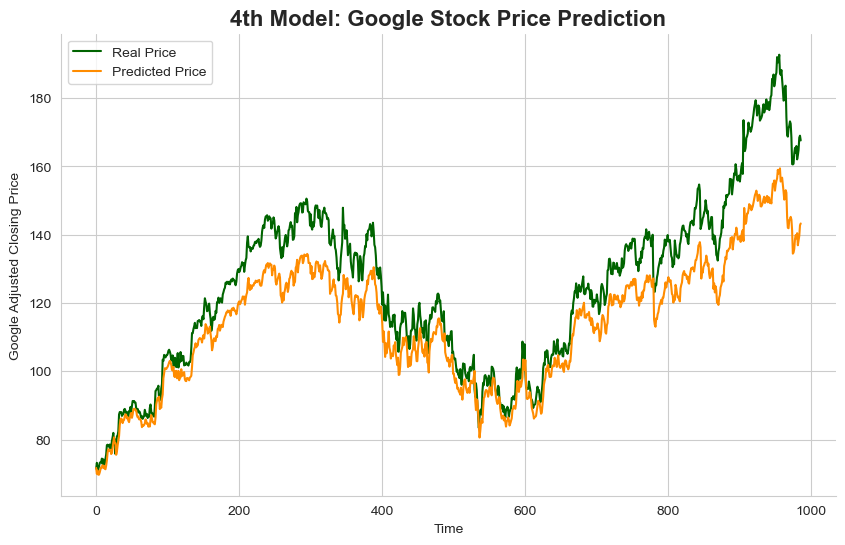

In [69]:
# Plot predicted and real adj close price for model evaluation

plt.figure(figsize = (10, 6))
sns.set_style('whitegrid')

plt.plot(original4, color = 'darkgreen', label = 'Real Price')
plt.plot(preds4, color = 'darkorange', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Google Adjusted Closing Price')
plt.title('4th Model: Google Stock Price Prediction', fontweight = 'bold', fontsize = 16)
plt.legend()

sns.despine()
plt.show()

### deneme

In [43]:
preds2_df = pd.DataFrame(preds2, columns = ['Prediction Close Price'])
preds2_df

Adjusted Close Price
0               74.559982
1               72.911270
2               74.461990
3               72.398529
4               72.936226
..                    ...
981            154.067490
982            156.414597
983            157.563660
984            161.255539
985            161.475449

[986 rows x 1 columns]

In [44]:
original_df = pd.DataFrame(original, columns = ['Real Close Price'])
original_df

Real Close Price
0           71.476662
1           73.189713
2           70.680069
3           71.333321
4           72.165878
..                ...
981        163.169998
982        164.740005
983        168.399994
984        168.960007
985        167.574997

[986 rows x 1 columns]

In [ ]:
deneme_df = pd.concat([original_df, preds2_df], ignore_index = True)

In [45]:
def createXY(dataset, n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)

trainX, trainY = createXY(google_train_scaled, 30)
testX, testY = createXY(google_test_scaled, 30)

In [46]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((3995, 30, 6), (3995,), (977, 30, 6), (977,))

In [47]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(128, return_sequences = True, input_shape = (30, 6)))
    grid_model.add(LSTM(64))
    grid_model.add(Dense(32))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse', optimizer = optimizer)
    return grid_model


grid_model = KerasRegressor(build_fn = build_model,
                            verbose = 1, validation_data = (testX, testY))
parameters = {'batch_size' : [16, 24, 32],
              'epochs' : [24, 30, 32], 'optimizer' : ['adam']}
grid_search3  = GridSearchCV(estimator = grid_model, param_grid = parameters, cv = 5)

/var/folders/k6/rj6vyp8j659d9vfskgxrz_x40000gn/T/ipykernel_932/134727193.py:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn = build_model,


In [48]:
%%time

grid_search3 = grid_search3.fit(trainX, trainY)

2024-08-22 14:50:21.895802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 14:50:21.898425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 14:50:21.899997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 14:50:23.389894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 14:50:23.392034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 14:50:23.393644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

200/200 [==============================] - ETA: 0s - loss: 0.0049

2024-08-22 14:50:35.172685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 14:50:35.173076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 14:50:35.386830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

200/200 [==============================] - 13s 45ms/step - loss: 0.0049 - val_loss: 0.0377
Epoch 2/24
200/200 [==============================] - 9s 44ms/step - loss: 3.0792e-04 - val_loss: 0.0269
Epoch 3/24
200/200 [==============================] - 8s 42ms/step - loss: 3.1516e-04 - val_loss: 0.0154
Epoch 4/24
200/200 [==============================] - 8s 42ms/step - loss: 3.0530e-04 - val_loss: 0.0284
Epoch 5/24
200/200 [==============================] - 9s 43ms/step - loss: 2.6098e-04 - val_loss: 0.0145
Epoch 6/24
200/200 [==============================] - 9s 45ms/step - loss: 2.9777e-04 - val_loss: 0.0186
Epoch 7/24
200/200 [==============================] - 8s 42ms/step - loss: 2.3364e-04 - val_loss: 0.0082
Epoch 8/24
200/200 [==============================] - 9s 43ms/step - loss: 2.6351e-04 - val_loss: 0.0082
Epoch 9/24
200/200 [==============================] - 10s 51ms/step - loss: 2.4162e-04 - val_loss: 0.0156
Epoch 10/24
200/200 [==============================] - 10s 50ms/step

2024-08-22 14:54:49.160695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 14:54:49.161074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 1s 16ms/step - loss: 8.7952e-05


2024-08-22 14:54:50.366564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 14:54:50.368380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 14:54:50.369889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 14:54:50.734431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 14:54:50.736254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 14:54:50.737583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

199/200 [============================>.] - ETA: 0s - loss: 0.0042

2024-08-22 14:55:04.592900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [977,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 14:55:04.593213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 14:55:04.811837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

200/200 [==============================] - 15s 54ms/step - loss: 0.0042 - val_loss: 0.0704
Epoch 2/24
200/200 [==============================] - 9s 44ms/step - loss: 3.2288e-04 - val_loss: 0.0521
Epoch 3/24
200/200 [==============================] - 9s 45ms/step - loss: 3.1956e-04 - val_loss: 0.0333
Epoch 4/24
200/200 [==============================] - 8s 42ms/step - loss: 2.9996e-04 - val_loss: 0.0491
Epoch 5/24
200/200 [==============================] - 9s 45ms/step - loss: 2.5726e-04 - val_loss: 0.0278
Epoch 6/24
200/200 [==============================] - 9s 43ms/step - loss: 2.7444e-04 - val_loss: 0.0265
Epoch 7/24
200/200 [==============================] - 9s 46ms/step - loss: 2.3170e-04 - val_loss: 0.0127
Epoch 8/24
200/200 [==============================] - 9s 47ms/step - loss: 2.8025e-04 - val_loss: 0.0178
Epoch 9/24
200/200 [==============================] - 9s 46ms/step - loss: 2.2839e-04 - val_loss: 0.0210
Epoch 10/24
200/200 [==============================] - 9s 46ms/step -

2024-08-22 14:58:34.397341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 14:58:34.397808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 0s 9ms/step - loss: 2.6264e-05


2024-08-22 14:58:35.112598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 14:58:35.114918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 14:58:35.116603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 14:58:35.409587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 14:58:35.411868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 14:58:35.413573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

200/200 [==============================] - ETA: 0s - loss: 0.0045

2024-08-22 14:58:48.808674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 14:58:48.809010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 14:58:49.061796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

200/200 [==============================] - 14s 50ms/step - loss: 0.0045 - val_loss: 0.0629
Epoch 2/24
200/200 [==============================] - 9s 43ms/step - loss: 3.4215e-04 - val_loss: 0.0431
Epoch 3/24
200/200 [==============================] - 9s 45ms/step - loss: 3.2984e-04 - val_loss: 0.0314
Epoch 4/24
200/200 [==============================] - 9s 43ms/step - loss: 3.0930e-04 - val_loss: 0.0406
Epoch 5/24
200/200 [==============================] - 9s 46ms/step - loss: 2.6782e-04 - val_loss: 0.0296
Epoch 6/24
200/200 [==============================] - 9s 43ms/step - loss: 3.0475e-04 - val_loss: 0.0236
Epoch 7/24
200/200 [==============================] - 9s 47ms/step - loss: 2.4148e-04 - val_loss: 0.0080
Epoch 8/24
200/200 [==============================] - 9s 43ms/step - loss: 2.7359e-04 - val_loss: 0.0106
Epoch 9/24
200/200 [==============================] - 9s 46ms/step - loss: 2.1635e-04 - val_loss: 0.0141
Epoch 10/24
200/200 [==============================] - 9s 43ms/step -

2024-08-22 15:02:18.151290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [799,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 15:02:18.151715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 0s 8ms/step - loss: 4.2532e-05


2024-08-22 15:02:18.791602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:02:18.793422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:02:18.795143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 15:02:19.005919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:02:19.007984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:02:19.010031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

200/200 [==============================] - ETA: 0s - loss: 0.0042

2024-08-22 15:02:31.238849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:02:31.239207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:02:31.546342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

200/200 [==============================] - 14s 48ms/step - loss: 0.0042 - val_loss: 0.0855
Epoch 2/24
200/200 [==============================] - 8s 42ms/step - loss: 2.9185e-04 - val_loss: 0.0692
Epoch 3/24
200/200 [==============================] - 8s 42ms/step - loss: 3.0277e-04 - val_loss: 0.0422
Epoch 4/24
200/200 [==============================] - 9s 44ms/step - loss: 2.5985e-04 - val_loss: 0.0600
Epoch 5/24
200/200 [==============================] - 9s 44ms/step - loss: 2.4704e-04 - val_loss: 0.0340
Epoch 6/24
200/200 [==============================] - 8s 42ms/step - loss: 2.7362e-04 - val_loss: 0.0377
Epoch 7/24
200/200 [==============================] - 9s 45ms/step - loss: 2.2822e-04 - val_loss: 0.0162
Epoch 8/24
200/200 [==============================] - 9s 43ms/step - loss: 2.2989e-04 - val_loss: 0.0182
Epoch 9/24
200/200 [==============================] - 9s 44ms/step - loss: 2.1140e-04 - val_loss: 0.0244
Epoch 10/24
200/200 [==============================] - 9s 44ms/step -

2024-08-22 15:05:54.518765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:05:54.519053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 0s 8ms/step - loss: 5.0905e-05


2024-08-22 15:05:55.150788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:05:55.152076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:05:55.153870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 15:05:55.391512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:05:55.393229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:05:55.395013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

199/200 [============================>.] - ETA: 0s - loss: 0.0017

2024-08-22 15:06:08.970128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:06:08.970438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:06:09.192708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

200/200 [==============================] - 15s 48ms/step - loss: 0.0017 - val_loss: 0.0518
Epoch 2/24
200/200 [==============================] - 9s 46ms/step - loss: 1.1211e-04 - val_loss: 0.0449
Epoch 3/24
200/200 [==============================] - 8s 40ms/step - loss: 1.0754e-04 - val_loss: 0.0410
Epoch 4/24
200/200 [==============================] - 9s 46ms/step - loss: 1.0429e-04 - val_loss: 0.0248
Epoch 5/24
200/200 [==============================] - 9s 43ms/step - loss: 9.1739e-05 - val_loss: 0.0392
Epoch 6/24
200/200 [==============================] - 9s 45ms/step - loss: 9.2175e-05 - val_loss: 0.0509
Epoch 7/24
200/200 [==============================] - 9s 44ms/step - loss: 1.1797e-04 - val_loss: 0.0175
Epoch 8/24
200/200 [==============================] - 9s 44ms/step - loss: 1.0112e-04 - val_loss: 0.0179
Epoch 9/24
200/200 [==============================] - 9s 43ms/step - loss: 8.7441e-05 - val_loss: 0.0074
Epoch 10/24
200/200 [==============================] - 9s 45ms/step -

2024-08-22 15:09:31.781483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [799,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 15:09:31.781779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 0s 8ms/step - loss: 2.8606e-04


2024-08-22 15:09:32.421708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:09:32.423107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:09:32.424679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 15:09:32.630615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:09:32.632702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:09:32.634182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

199/200 [============================>.] - ETA: 0s - loss: 0.0043

2024-08-22 15:09:45.147400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:09:45.147762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:09:45.363581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

200/200 [==============================] - 14s 47ms/step - loss: 0.0043 - val_loss: 0.0702
Epoch 2/30
200/200 [==============================] - 8s 42ms/step - loss: 3.0213e-04 - val_loss: 0.0518
Epoch 3/30
200/200 [==============================] - 9s 45ms/step - loss: 3.1430e-04 - val_loss: 0.0324
Epoch 4/30
200/200 [==============================] - 9s 47ms/step - loss: 2.9537e-04 - val_loss: 0.0382
Epoch 5/30
200/200 [==============================] - 8s 42ms/step - loss: 2.5366e-04 - val_loss: 0.0242
Epoch 6/30
200/200 [==============================] - 9s 43ms/step - loss: 2.9483e-04 - val_loss: 0.0246
Epoch 7/30
200/200 [==============================] - 8s 42ms/step - loss: 2.3578e-04 - val_loss: 0.0102
Epoch 8/30
200/200 [==============================] - 8s 42ms/step - loss: 2.5418e-04 - val_loss: 0.0093
Epoch 9/30
200/200 [==============================] - 9s 46ms/step - loss: 2.3094e-04 - val_loss: 0.0184
Epoch 10/30
200/200 [==============================] - 9s 44ms/step -

2024-08-22 15:14:00.592414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:14:00.592701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 0s 8ms/step - loss: 5.2856e-05


2024-08-22 15:14:01.241306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:14:01.243377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:14:01.244857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 15:14:01.456838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:14:01.459106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:14:01.461275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

200/200 [==============================] - ETA: 0s - loss: 0.0054

2024-08-22 15:14:14.134087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:14:14.134504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:14:14.361964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

200/200 [==============================] - 14s 48ms/step - loss: 0.0054 - val_loss: 0.0631
Epoch 2/30
200/200 [==============================] - 9s 46ms/step - loss: 3.2326e-04 - val_loss: 0.0466
Epoch 3/30
200/200 [==============================] - 9s 44ms/step - loss: 3.1513e-04 - val_loss: 0.0294
Epoch 4/30
200/200 [==============================] - 8s 42ms/step - loss: 3.1134e-04 - val_loss: 0.0528
Epoch 5/30
200/200 [==============================] - 9s 45ms/step - loss: 2.5820e-04 - val_loss: 0.0246
Epoch 6/30
200/200 [==============================] - 8s 42ms/step - loss: 2.7533e-04 - val_loss: 0.0247
Epoch 7/30
200/200 [==============================] - 9s 44ms/step - loss: 2.1948e-04 - val_loss: 0.0097
Epoch 8/30
200/200 [==============================] - 8s 42ms/step - loss: 2.6252e-04 - val_loss: 0.0126
Epoch 9/30
200/200 [==============================] - 9s 43ms/step - loss: 2.0785e-04 - val_loss: 0.0174
Epoch 10/30
200/200 [==============================] - 9s 45ms/step -

2024-08-22 15:18:28.170450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:18:28.170758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 0s 8ms/step - loss: 3.6414e-05


2024-08-22 15:18:28.871218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:18:28.872822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:18:28.874579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 15:18:29.087128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:18:29.089252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:18:29.090860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

199/200 [============================>.] - ETA: 0s - loss: 0.0044

2024-08-22 15:18:41.356652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [977,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 15:18:41.356952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:18:41.571503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

200/200 [==============================] - 13s 46ms/step - loss: 0.0044 - val_loss: 0.0566
Epoch 2/30
200/200 [==============================] - 9s 47ms/step - loss: 3.3242e-04 - val_loss: 0.0417
Epoch 3/30
200/200 [==============================] - 8s 42ms/step - loss: 3.3192e-04 - val_loss: 0.0245
Epoch 4/30
200/200 [==============================] - 8s 42ms/step - loss: 3.0639e-04 - val_loss: 0.0399
Epoch 5/30
200/200 [==============================] - 9s 44ms/step - loss: 2.7350e-04 - val_loss: 0.0215
Epoch 6/30
200/200 [==============================] - 9s 44ms/step - loss: 3.0191e-04 - val_loss: 0.0200
Epoch 7/30
200/200 [==============================] - 9s 43ms/step - loss: 2.3194e-04 - val_loss: 0.0073
Epoch 8/30
200/200 [==============================] - 9s 44ms/step - loss: 2.7739e-04 - val_loss: 0.0110
Epoch 9/30
200/200 [==============================] - 9s 43ms/step - loss: 2.1357e-04 - val_loss: 0.0130
Epoch 10/30
200/200 [==============================] - 10s 50ms/step 

2024-08-22 15:22:58.756103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:22:58.756549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 0s 8ms/step - loss: 2.6192e-05


2024-08-22 15:22:59.392214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:22:59.393973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:22:59.395832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 15:22:59.607846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:22:59.610014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:22:59.611940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

200/200 [==============================] - ETA: 0s - loss: 0.0054

2024-08-22 15:23:11.627926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [977,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 15:23:11.628494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:23:11.860741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

200/200 [==============================] - 13s 45ms/step - loss: 0.0054 - val_loss: 0.0586
Epoch 2/30
200/200 [==============================] - 8s 41ms/step - loss: 3.0989e-04 - val_loss: 0.0507
Epoch 3/30
200/200 [==============================] - 9s 46ms/step - loss: 3.1659e-04 - val_loss: 0.0264
Epoch 4/30
200/200 [==============================] - 9s 43ms/step - loss: 2.6899e-04 - val_loss: 0.0467
Epoch 5/30
200/200 [==============================] - 8s 42ms/step - loss: 2.4897e-04 - val_loss: 0.0241
Epoch 6/30
200/200 [==============================] - 8s 41ms/step - loss: 2.6872e-04 - val_loss: 0.0257
Epoch 7/30
200/200 [==============================] - 9s 43ms/step - loss: 2.2473e-04 - val_loss: 0.0087
Epoch 8/30
200/200 [==============================] - 9s 45ms/step - loss: 2.0783e-04 - val_loss: 0.0091
Epoch 9/30
200/200 [==============================] - 8s 42ms/step - loss: 1.9874e-04 - val_loss: 0.0134
Epoch 10/30
200/200 [==============================] - 9s 44ms/step -

2024-08-22 15:27:25.871453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:27:25.872009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 0s 9ms/step - loss: 5.0657e-05


2024-08-22 15:27:26.560269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:27:26.562823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:27:26.565280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 15:27:26.781342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:27:26.783462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:27:26.785149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

200/200 [==============================] - ETA: 0s - loss: 0.0015

2024-08-22 15:27:40.431396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:27:40.431704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:27:40.666419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

200/200 [==============================] - 15s 49ms/step - loss: 0.0015 - val_loss: 0.1111
Epoch 2/30
200/200 [==============================] - 8s 42ms/step - loss: 1.0222e-04 - val_loss: 0.0927
Epoch 3/30
200/200 [==============================] - 9s 45ms/step - loss: 9.9853e-05 - val_loss: 0.0781
Epoch 4/30
200/200 [==============================] - 8s 42ms/step - loss: 9.9264e-05 - val_loss: 0.0513
Epoch 5/30
200/200 [==============================] - 9s 45ms/step - loss: 8.8318e-05 - val_loss: 0.0637
Epoch 6/30
200/200 [==============================] - 9s 43ms/step - loss: 8.9002e-05 - val_loss: 0.0736
Epoch 7/30
200/200 [==============================] - 9s 43ms/step - loss: 1.1370e-04 - val_loss: 0.0285
Epoch 8/30
200/200 [==============================] - 9s 43ms/step - loss: 1.0065e-04 - val_loss: 0.0313
Epoch 9/30
200/200 [==============================] - 9s 43ms/step - loss: 8.6297e-05 - val_loss: 0.0178
Epoch 10/30
200/200 [==============================] - 9s 46ms/step -

2024-08-22 15:31:59.665497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:31:59.665885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 1s 10ms/step - loss: 2.3831e-04


2024-08-22 15:32:00.413920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:32:00.415696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:32:00.417473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 15:32:00.616286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2024-08-22 15:32:00.711132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3196]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:32:00.711455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor '

200/200 [==============================] - ETA: 0s - loss: 0.0050

2024-08-22 15:32:13.078460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:32:13.078782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:32:13.323455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

200/200 [==============================] - 14s 46ms/step - loss: 0.0050 - val_loss: 0.0764
Epoch 2/32
200/200 [==============================] - 9s 45ms/step - loss: 3.0228e-04 - val_loss: 0.0543
Epoch 3/32
200/200 [==============================] - 8s 42ms/step - loss: 3.2438e-04 - val_loss: 0.0340
Epoch 4/32
200/200 [==============================] - 8s 42ms/step - loss: 3.1161e-04 - val_loss: 0.0472
Epoch 5/32
200/200 [==============================] - 9s 45ms/step - loss: 2.6750e-04 - val_loss: 0.0234
Epoch 6/32
200/200 [==============================] - 9s 45ms/step - loss: 2.9556e-04 - val_loss: 0.0308
Epoch 7/32
200/200 [==============================] - 9s 43ms/step - loss: 2.3661e-04 - val_loss: 0.0122
Epoch 8/32
200/200 [==============================] - 9s 46ms/step - loss: 2.7486e-04 - val_loss: 0.0135
Epoch 9/32
200/200 [==============================] - 8s 42ms/step - loss: 2.3657e-04 - val_loss: 0.0188
Epoch 10/32
200/200 [==============================] - 9s 42ms/step -

2024-08-22 15:36:48.590728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:36:48.591097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 1s 10ms/step - loss: 1.2835e-05


2024-08-22 15:36:49.367069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:36:49.368912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:36:49.370493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 15:36:49.648059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:36:49.649508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:36:49.651230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

199/200 [============================>.] - ETA: 0s - loss: 0.0041

2024-08-22 15:37:02.358742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:37:02.359034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:37:02.590705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

200/200 [==============================] - 14s 47ms/step - loss: 0.0041 - val_loss: 0.0612
Epoch 2/32
200/200 [==============================] - 10s 49ms/step - loss: 3.1893e-04 - val_loss: 0.0448
Epoch 3/32
200/200 [==============================] - 8s 42ms/step - loss: 3.2250e-04 - val_loss: 0.0295
Epoch 4/32
200/200 [==============================] - 9s 44ms/step - loss: 3.0366e-04 - val_loss: 0.0380
Epoch 5/32
200/200 [==============================] - 8s 42ms/step - loss: 2.5423e-04 - val_loss: 0.0239
Epoch 6/32
200/200 [==============================] - 8s 42ms/step - loss: 2.5825e-04 - val_loss: 0.0182
Epoch 7/32
200/200 [==============================] - 9s 44ms/step - loss: 2.3896e-04 - val_loss: 0.0086
Epoch 8/32
200/200 [==============================] - 9s 45ms/step - loss: 2.3457e-04 - val_loss: 0.0098
Epoch 9/32
200/200 [==============================] - 9s 45ms/step - loss: 2.0129e-04 - val_loss: 0.0146
Epoch 10/32
200/200 [==============================] - 9s 43ms/step 

2024-08-22 15:41:38.632042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:41:38.632385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 0s 8ms/step - loss: 9.8346e-05


2024-08-22 15:41:39.271747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:41:39.273560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:41:39.275470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 15:41:39.494195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:41:39.496707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:41:39.499702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

199/200 [============================>.] - ETA: 0s - loss: 0.0042

2024-08-22 15:41:52.308475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:41:52.308818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:41:52.548382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

200/200 [==============================] - 14s 46ms/step - loss: 0.0042 - val_loss: 0.0522
Epoch 2/32
200/200 [==============================] - 8s 42ms/step - loss: 3.0173e-04 - val_loss: 0.0403
Epoch 3/32
200/200 [==============================] - 10s 49ms/step - loss: 3.0234e-04 - val_loss: 0.0310
Epoch 4/32
200/200 [==============================] - 9s 45ms/step - loss: 2.9299e-04 - val_loss: 0.0374
Epoch 5/32
200/200 [==============================] - 8s 42ms/step - loss: 2.5566e-04 - val_loss: 0.0294
Epoch 6/32
200/200 [==============================] - 9s 44ms/step - loss: 3.0346e-04 - val_loss: 0.0227
Epoch 7/32
200/200 [==============================] - 8s 42ms/step - loss: 2.3092e-04 - val_loss: 0.0101
Epoch 8/32
200/200 [==============================] - 9s 44ms/step - loss: 2.7555e-04 - val_loss: 0.0134
Epoch 9/32
200/200 [==============================] - 9s 44ms/step - loss: 2.1725e-04 - val_loss: 0.0176
Epoch 10/32
200/200 [==============================] - 9s 43ms/step 

2024-08-22 15:46:30.148533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [799,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 15:46:30.148946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 1s 12ms/step - loss: 1.9071e-05


2024-08-22 15:46:31.022063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:46:31.024597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:46:31.026592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 15:46:31.294437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:46:31.296240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:46:31.298098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

199/200 [============================>.] - ETA: 0s - loss: 0.0025

2024-08-22 15:46:43.208826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:46:43.209111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:46:43.435268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

200/200 [==============================] - 13s 46ms/step - loss: 0.0025 - val_loss: 0.0463
Epoch 2/32
200/200 [==============================] - 9s 45ms/step - loss: 2.8844e-04 - val_loss: 0.0375
Epoch 3/32
200/200 [==============================] - 9s 43ms/step - loss: 2.9523e-04 - val_loss: 0.0272
Epoch 4/32
200/200 [==============================] - 9s 43ms/step - loss: 2.6750e-04 - val_loss: 0.0315
Epoch 5/32
200/200 [==============================] - 9s 45ms/step - loss: 2.3045e-04 - val_loss: 0.0317
Epoch 6/32
200/200 [==============================] - 9s 44ms/step - loss: 2.8597e-04 - val_loss: 0.0257
Epoch 7/32
200/200 [==============================] - 9s 45ms/step - loss: 2.1132e-04 - val_loss: 0.0074
Epoch 8/32
200/200 [==============================] - 9s 43ms/step - loss: 2.2613e-04 - val_loss: 0.0082
Epoch 9/32
200/200 [==============================] - 9s 46ms/step - loss: 1.8812e-04 - val_loss: 0.0126
Epoch 10/32
200/200 [==============================] - 9s 43ms/step -

2024-08-22 15:51:22.956631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:51:22.956954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 0s 9ms/step - loss: 8.4618e-05


2024-08-22 15:51:23.618994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:51:23.620315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:51:23.621953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 15:51:23.850042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:51:23.852277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:51:23.854777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

199/200 [============================>.] - ETA: 0s - loss: 0.0016

2024-08-22 15:51:36.469858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:51:36.470167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:51:37.828314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

200/200 [==============================] - 15s 55ms/step - loss: 0.0016 - val_loss: 0.1543
Epoch 2/32
200/200 [==============================] - 9s 46ms/step - loss: 1.1422e-04 - val_loss: 0.1347
Epoch 3/32
200/200 [==============================] - 9s 45ms/step - loss: 9.9107e-05 - val_loss: 0.1341
Epoch 4/32
200/200 [==============================] - 9s 45ms/step - loss: 9.9424e-05 - val_loss: 0.0883
Epoch 5/32
200/200 [==============================] - 9s 44ms/step - loss: 8.8998e-05 - val_loss: 0.1064
Epoch 6/32
200/200 [==============================] - 9s 46ms/step - loss: 9.1214e-05 - val_loss: 0.1134
Epoch 7/32
200/200 [==============================] - 9s 43ms/step - loss: 1.1366e-04 - val_loss: 0.0703
Epoch 8/32
200/200 [==============================] - 8s 42ms/step - loss: 9.9182e-05 - val_loss: 0.0571
Epoch 9/32
200/200 [==============================] - 9s 46ms/step - loss: 9.5086e-05 - val_loss: 0.0346
Epoch 10/32
200/200 [==============================] - 9s 46ms/step -

2024-08-22 15:56:20.697147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:56:20.697574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


50/50 [==============================] - 0s 8ms/step - loss: 2.9042e-04


2024-08-22 15:56:21.362026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:56:21.363750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:56:21.365494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 15:56:21.591602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:56:21.593855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:56:21.596456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0051

2024-08-22 15:56:33.348476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:56:33.348797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:56:33.596431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 13s 64ms/step - loss: 0.0051 - val_loss: 0.0521
Epoch 2/24
134/134 [==============================] - 7s 53ms/step - loss: 2.7684e-04 - val_loss: 0.0404
Epoch 3/24
134/134 [==============================] - 7s 55ms/step - loss: 2.6227e-04 - val_loss: 0.0348
Epoch 4/24
134/134 [==============================] - 7s 52ms/step - loss: 2.6282e-04 - val_loss: 0.0316
Epoch 5/24
134/134 [==============================] - 7s 49ms/step - loss: 2.6406e-04 - val_loss: 0.0272
Epoch 6/24
134/134 [==============================] - 7s 51ms/step - loss: 2.2822e-04 - val_loss: 0.0225
Epoch 7/24
134/134 [==============================] - 7s 56ms/step - loss: 2.2296e-04 - val_loss: 0.0203
Epoch 8/24
134/134 [==============================] - 7s 53ms/step - loss: 2.1900e-04 - val_loss: 0.0144
Epoch 9/24
134/134 [==============================] - 7s 49ms/step - loss: 2.1789e-04 - val_loss: 0.0172
Epoch 10/24
134/134 [==============================] - 7s 55ms/step -

2024-08-22 15:59:20.823992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:59:20.824323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 11ms/step - loss: 3.8522e-05


2024-08-22 15:59:21.436145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:59:21.437522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:59:21.439385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 15:59:21.656190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 15:59:21.657998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 15:59:21.659717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0075

2024-08-22 15:59:33.636922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [977,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 15:59:33.637256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 15:59:33.875407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

134/134 [==============================] - 13s 67ms/step - loss: 0.0075 - val_loss: 0.0798
Epoch 2/24
134/134 [==============================] - 7s 52ms/step - loss: 2.9296e-04 - val_loss: 0.0597
Epoch 3/24
134/134 [==============================] - 7s 50ms/step - loss: 2.7499e-04 - val_loss: 0.0492
Epoch 4/24
134/134 [==============================] - 8s 59ms/step - loss: 2.7690e-04 - val_loss: 0.0444
Epoch 5/24
134/134 [==============================] - 7s 51ms/step - loss: 2.8309e-04 - val_loss: 0.0397
Epoch 6/24
134/134 [==============================] - 7s 50ms/step - loss: 2.2634e-04 - val_loss: 0.0303
Epoch 7/24
134/134 [==============================] - 8s 60ms/step - loss: 2.4511e-04 - val_loss: 0.0249
Epoch 8/24
134/134 [==============================] - 8s 57ms/step - loss: 2.2705e-04 - val_loss: 0.0227
Epoch 9/24
134/134 [==============================] - 7s 51ms/step - loss: 2.3780e-04 - val_loss: 0.0204
Epoch 10/24
134/134 [==============================] - 8s 58ms/step -

2024-08-22 16:02:25.742888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [799,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 16:02:25.743376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 12ms/step - loss: 2.6076e-05


2024-08-22 16:02:26.383231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:02:26.384562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:02:26.386356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 16:02:26.604809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:02:26.606130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:02:26.607724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0070

2024-08-22 16:02:37.458204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:02:37.458551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:02:37.704045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 12s 60ms/step - loss: 0.0070 - val_loss: 0.0506
Epoch 2/24
134/134 [==============================] - 7s 56ms/step - loss: 2.7788e-04 - val_loss: 0.0405
Epoch 3/24
134/134 [==============================] - 7s 52ms/step - loss: 2.7335e-04 - val_loss: 0.0351
Epoch 4/24
134/134 [==============================] - 7s 54ms/step - loss: 2.7368e-04 - val_loss: 0.0315
Epoch 5/24
134/134 [==============================] - 7s 56ms/step - loss: 2.7971e-04 - val_loss: 0.0294
Epoch 6/24
134/134 [==============================] - 7s 50ms/step - loss: 2.1632e-04 - val_loss: 0.0221
Epoch 7/24
134/134 [==============================] - 7s 52ms/step - loss: 2.2646e-04 - val_loss: 0.0194
Epoch 8/24
134/134 [==============================] - 8s 56ms/step - loss: 2.1635e-04 - val_loss: 0.0224
Epoch 9/24
134/134 [==============================] - 7s 55ms/step - loss: 2.3943e-04 - val_loss: 0.0189
Epoch 10/24
134/134 [==============================] - 7s 52ms/step -

2024-08-22 16:05:27.133068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:05:27.133446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 12ms/step - loss: 3.9115e-05


2024-08-22 16:05:27.764596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:05:27.766518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:05:27.768033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 16:05:28.043852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:05:28.045638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:05:28.048050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0053

2024-08-22 16:05:39.912005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [977,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 16:05:39.912294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:05:40.156879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

134/134 [==============================] - 13s 68ms/step - loss: 0.0053 - val_loss: 0.0743
Epoch 2/24
134/134 [==============================] - 8s 58ms/step - loss: 2.6966e-04 - val_loss: 0.0593
Epoch 3/24
134/134 [==============================] - 7s 52ms/step - loss: 2.6415e-04 - val_loss: 0.0428
Epoch 4/24
134/134 [==============================] - 7s 52ms/step - loss: 2.6926e-04 - val_loss: 0.0398
Epoch 5/24
134/134 [==============================] - 7s 55ms/step - loss: 2.6003e-04 - val_loss: 0.0395
Epoch 6/24
134/134 [==============================] - 8s 57ms/step - loss: 2.1858e-04 - val_loss: 0.0253
Epoch 7/24
134/134 [==============================] - 7s 54ms/step - loss: 2.0441e-04 - val_loss: 0.0236
Epoch 8/24
134/134 [==============================] - 8s 57ms/step - loss: 2.1839e-04 - val_loss: 0.0224
Epoch 9/24
134/134 [==============================] - 7s 52ms/step - loss: 2.6658e-04 - val_loss: 0.0154
Epoch 10/24
134/134 [==============================] - 7s 53ms/step -

2024-08-22 16:08:33.032570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:08:33.032858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 12ms/step - loss: 1.2537e-04


2024-08-22 16:08:33.674137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:08:33.675979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:08:33.677782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 16:08:33.890656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:08:33.892728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:08:33.894647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0021

2024-08-22 16:08:45.011732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:08:45.012378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:08:45.497838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 13s 67ms/step - loss: 0.0021 - val_loss: 0.1021
Epoch 2/24
134/134 [==============================] - 8s 56ms/step - loss: 9.5676e-05 - val_loss: 0.0765
Epoch 3/24
134/134 [==============================] - 7s 54ms/step - loss: 1.0277e-04 - val_loss: 0.0773
Epoch 4/24
134/134 [==============================] - 7s 52ms/step - loss: 9.7469e-05 - val_loss: 0.0642
Epoch 5/24
134/134 [==============================] - 8s 58ms/step - loss: 8.6380e-05 - val_loss: 0.0689
Epoch 6/24
134/134 [==============================] - 7s 52ms/step - loss: 8.3854e-05 - val_loss: 0.0781
Epoch 7/24
134/134 [==============================] - 7s 52ms/step - loss: 1.0266e-04 - val_loss: 0.0436
Epoch 8/24
134/134 [==============================] - 8s 57ms/step - loss: 9.0276e-05 - val_loss: 0.0313
Epoch 9/24
134/134 [==============================] - 8s 57ms/step - loss: 9.3525e-05 - val_loss: 0.0257
Epoch 10/24
134/134 [==============================] - 7s 53ms/step -

2024-08-22 16:11:38.778067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:11:38.778441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 12ms/step - loss: 4.1375e-04


2024-08-22 16:11:39.644903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:11:39.647125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:11:39.648414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 16:11:39.846143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:11:39.848628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:11:39.850833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0064

2024-08-22 16:11:53.874341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:11:53.874884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:11:54.135233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 15s 73ms/step - loss: 0.0064 - val_loss: 0.0445
Epoch 2/30
134/134 [==============================] - 7s 51ms/step - loss: 2.8428e-04 - val_loss: 0.0405
Epoch 3/30
134/134 [==============================] - 7s 50ms/step - loss: 2.7251e-04 - val_loss: 0.0425
Epoch 4/30
134/134 [==============================] - 8s 58ms/step - loss: 2.8338e-04 - val_loss: 0.0362
Epoch 5/30
134/134 [==============================] - 8s 57ms/step - loss: 2.7152e-04 - val_loss: 0.0292
Epoch 6/30
134/134 [==============================] - 7s 50ms/step - loss: 2.3691e-04 - val_loss: 0.0304
Epoch 7/30
134/134 [==============================] - 7s 53ms/step - loss: 2.4060e-04 - val_loss: 0.0218
Epoch 8/30
134/134 [==============================] - 8s 57ms/step - loss: 2.4314e-04 - val_loss: 0.0203
Epoch 9/30
134/134 [==============================] - 7s 53ms/step - loss: 2.4310e-04 - val_loss: 0.0198
Epoch 10/30
134/134 [==============================] - 7s 53ms/step -

2024-08-22 16:15:32.718649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [799,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 16:15:32.719032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 14ms/step - loss: 3.3463e-05


2024-08-22 16:15:33.480209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:15:33.482572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:15:33.484420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 16:15:33.790305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:15:33.793528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:15:33.796132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0065

2024-08-22 16:15:45.497862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:15:45.498170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:15:45.748476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 13s 65ms/step - loss: 0.0065 - val_loss: 0.0488
Epoch 2/30
134/134 [==============================] - 7s 53ms/step - loss: 2.9758e-04 - val_loss: 0.0384
Epoch 3/30
134/134 [==============================] - 7s 54ms/step - loss: 2.6314e-04 - val_loss: 0.0328
Epoch 4/30
134/134 [==============================] - 7s 53ms/step - loss: 2.6807e-04 - val_loss: 0.0321
Epoch 5/30
134/134 [==============================] - 8s 60ms/step - loss: 2.6673e-04 - val_loss: 0.0296
Epoch 6/30
134/134 [==============================] - 7s 55ms/step - loss: 2.2096e-04 - val_loss: 0.0240
Epoch 7/30
134/134 [==============================] - 7s 54ms/step - loss: 2.5964e-04 - val_loss: 0.0177
Epoch 8/30
134/134 [==============================] - 7s 53ms/step - loss: 2.1906e-04 - val_loss: 0.0210
Epoch 9/30
134/134 [==============================] - 7s 55ms/step - loss: 2.4839e-04 - val_loss: 0.0129
Epoch 10/30
134/134 [==============================] - 7s 52ms/step -

2024-08-22 16:19:23.509995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:19:23.510428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 12ms/step - loss: 2.9630e-05


2024-08-22 16:19:24.159618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:19:24.161413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:19:24.163138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 16:19:24.384127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:19:24.387672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:19:24.390512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0081

2024-08-22 16:19:35.238574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [977,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 16:19:35.239021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:19:35.555049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

134/134 [==============================] - 12s 59ms/step - loss: 0.0080 - val_loss: 0.0612
Epoch 2/30
134/134 [==============================] - 7s 50ms/step - loss: 2.5946e-04 - val_loss: 0.0491
Epoch 3/30
134/134 [==============================] - 7s 51ms/step - loss: 2.5386e-04 - val_loss: 0.0404
Epoch 4/30
134/134 [==============================] - 7s 55ms/step - loss: 2.6284e-04 - val_loss: 0.0391
Epoch 5/30
134/134 [==============================] - 8s 58ms/step - loss: 2.7130e-04 - val_loss: 0.0362
Epoch 6/30
134/134 [==============================] - 8s 58ms/step - loss: 2.2982e-04 - val_loss: 0.0269
Epoch 7/30
134/134 [==============================] - 7s 55ms/step - loss: 2.6444e-04 - val_loss: 0.0234
Epoch 8/30
134/134 [==============================] - 8s 56ms/step - loss: 2.2307e-04 - val_loss: 0.0240
Epoch 9/30
134/134 [==============================] - 7s 53ms/step - loss: 2.7016e-04 - val_loss: 0.0161
Epoch 10/30
134/134 [==============================] - 8s 57ms/step -

2024-08-22 16:23:16.681856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:23:16.682152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 12ms/step - loss: 4.5193e-05


2024-08-22 16:23:17.341370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:23:17.343253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:23:17.345203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 16:23:17.561735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:23:17.564086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:23:17.566431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0047

2024-08-22 16:23:28.523976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:23:28.524323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:23:28.766146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 12s 61ms/step - loss: 0.0047 - val_loss: 0.0266
Epoch 2/30
134/134 [==============================] - 7s 54ms/step - loss: 2.3023e-04 - val_loss: 0.0315
Epoch 3/30
134/134 [==============================] - 7s 53ms/step - loss: 2.4129e-04 - val_loss: 0.0313
Epoch 4/30
134/134 [==============================] - 7s 52ms/step - loss: 2.3934e-04 - val_loss: 0.0269
Epoch 5/30
134/134 [==============================] - 7s 54ms/step - loss: 2.4133e-04 - val_loss: 0.0235
Epoch 6/30
134/134 [==============================] - 7s 51ms/step - loss: 1.9592e-04 - val_loss: 0.0181
Epoch 7/30
134/134 [==============================] - 7s 54ms/step - loss: 1.8591e-04 - val_loss: 0.0184
Epoch 8/30
134/134 [==============================] - 7s 54ms/step - loss: 2.0697e-04 - val_loss: 0.0171
Epoch 9/30
134/134 [==============================] - 7s 55ms/step - loss: 2.2899e-04 - val_loss: 0.0120
Epoch 10/30
134/134 [==============================] - 7s 50ms/step -

2024-08-22 16:26:56.966972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [799,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 16:26:56.967301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 11ms/step - loss: 7.1821e-05


2024-08-22 16:26:57.585476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:26:57.587288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:26:57.588634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 16:26:57.805236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:26:57.807217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:26:57.808703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0020

2024-08-22 16:27:08.690043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:27:08.690344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:27:08.927969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 12s 61ms/step - loss: 0.0020 - val_loss: 0.0996
Epoch 2/30
134/134 [==============================] - 7s 51ms/step - loss: 1.0505e-04 - val_loss: 0.0622
Epoch 3/30
134/134 [==============================] - 7s 53ms/step - loss: 1.1562e-04 - val_loss: 0.0676
Epoch 4/30
134/134 [==============================] - 7s 55ms/step - loss: 9.5133e-05 - val_loss: 0.0536
Epoch 5/30
134/134 [==============================] - 7s 55ms/step - loss: 9.1062e-05 - val_loss: 0.0514
Epoch 6/30
134/134 [==============================] - 7s 52ms/step - loss: 8.7498e-05 - val_loss: 0.0703
Epoch 7/30
134/134 [==============================] - 7s 53ms/step - loss: 1.1080e-04 - val_loss: 0.0436
Epoch 8/30
134/134 [==============================] - 7s 55ms/step - loss: 9.0078e-05 - val_loss: 0.0297
Epoch 9/30
134/134 [==============================] - 7s 52ms/step - loss: 9.9155e-05 - val_loss: 0.0280
Epoch 10/30
134/134 [==============================] - 8s 56ms/step -

2024-08-22 16:30:35.887265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [799,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 16:30:35.887724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 11ms/step - loss: 2.0783e-04


2024-08-22 16:30:36.488249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:30:36.489986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:30:36.491792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 16:30:36.718164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:30:36.720342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:30:36.721828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

134/134 [==============================] - ETA: 0s - loss: 0.0054

2024-08-22 16:30:48.147753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:30:48.148106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:30:48.385081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 12s 55ms/step - loss: 0.0054 - val_loss: 0.0612
Epoch 2/32
134/134 [==============================] - 7s 53ms/step - loss: 3.0541e-04 - val_loss: 0.0488
Epoch 3/32
134/134 [==============================] - 7s 50ms/step - loss: 2.8298e-04 - val_loss: 0.0432
Epoch 4/32
134/134 [==============================] - 7s 50ms/step - loss: 2.7799e-04 - val_loss: 0.0377
Epoch 5/32
134/134 [==============================] - 7s 55ms/step - loss: 2.7511e-04 - val_loss: 0.0318
Epoch 6/32
134/134 [==============================] - 7s 50ms/step - loss: 2.3190e-04 - val_loss: 0.0281
Epoch 7/32
134/134 [==============================] - 7s 50ms/step - loss: 2.3515e-04 - val_loss: 0.0233
Epoch 8/32
134/134 [==============================] - 7s 54ms/step - loss: 2.2611e-04 - val_loss: 0.0176
Epoch 9/32
134/134 [==============================] - 7s 50ms/step - loss: 2.2534e-04 - val_loss: 0.0198
Epoch 10/32
134/134 [==============================] - 7s 50ms/step -

2024-08-22 16:34:24.847281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:34:24.847606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 11ms/step - loss: 1.8407e-05


2024-08-22 16:34:25.463909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:34:25.465683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:34:25.467423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 16:34:25.674116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:34:25.676061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:34:25.677784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0088

2024-08-22 16:34:36.411163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:34:36.411502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:34:36.647762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 12s 59ms/step - loss: 0.0088 - val_loss: 0.0717
Epoch 2/32
134/134 [==============================] - 7s 54ms/step - loss: 3.0996e-04 - val_loss: 0.0639
Epoch 3/32
134/134 [==============================] - 7s 53ms/step - loss: 2.8732e-04 - val_loss: 0.0513
Epoch 4/32
134/134 [==============================] - 7s 52ms/step - loss: 2.9472e-04 - val_loss: 0.0468
Epoch 5/32
134/134 [==============================] - 7s 55ms/step - loss: 2.9282e-04 - val_loss: 0.0427
Epoch 6/32
134/134 [==============================] - 7s 52ms/step - loss: 2.2958e-04 - val_loss: 0.0328
Epoch 7/32
134/134 [==============================] - 7s 50ms/step - loss: 2.6835e-04 - val_loss: 0.0248
Epoch 8/32
134/134 [==============================] - 8s 57ms/step - loss: 2.2571e-04 - val_loss: 0.0280
Epoch 9/32
134/134 [==============================] - 7s 53ms/step - loss: 2.5831e-04 - val_loss: 0.0160
Epoch 10/32
134/134 [==============================] - 7s 51ms/step -

2024-08-22 16:38:21.366789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [799,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 16:38:21.367112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 11ms/step - loss: 2.3796e-05


2024-08-22 16:38:22.001474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:38:22.003309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:38:22.005314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 16:38:22.217426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:38:22.219431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:38:22.221041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0055

2024-08-22 16:38:33.361528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:38:33.361833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:38:33.605326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 12s 62ms/step - loss: 0.0055 - val_loss: 0.0505
Epoch 2/32
134/134 [==============================] - 7s 53ms/step - loss: 2.5332e-04 - val_loss: 0.0424
Epoch 3/32
134/134 [==============================] - 7s 54ms/step - loss: 2.4537e-04 - val_loss: 0.0352
Epoch 4/32
134/134 [==============================] - 7s 52ms/step - loss: 2.5283e-04 - val_loss: 0.0292
Epoch 5/32
134/134 [==============================] - 7s 55ms/step - loss: 2.6072e-04 - val_loss: 0.0294
Epoch 6/32
134/134 [==============================] - 7s 53ms/step - loss: 2.1177e-04 - val_loss: 0.0215
Epoch 7/32
134/134 [==============================] - 7s 52ms/step - loss: 2.2093e-04 - val_loss: 0.0179
Epoch 8/32
134/134 [==============================] - 7s 55ms/step - loss: 2.0923e-04 - val_loss: 0.0210
Epoch 9/32
134/134 [==============================] - 7s 52ms/step - loss: 2.4774e-04 - val_loss: 0.0144
Epoch 10/32
134/134 [==============================] - 8s 62ms/step -

2024-08-22 16:42:21.005968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:42:21.006388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 11ms/step - loss: 6.5434e-05


2024-08-22 16:42:21.615464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:42:21.617329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:42:21.619102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 16:42:21.834721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:42:21.836928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:42:21.838902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0061

2024-08-22 16:42:32.466974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:42:32.467427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:42:32.744033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 12s 59ms/step - loss: 0.0061 - val_loss: 0.0656
Epoch 2/32
134/134 [==============================] - 10s 74ms/step - loss: 2.8740e-04 - val_loss: 0.0567
Epoch 3/32
134/134 [==============================] - 10s 77ms/step - loss: 2.9937e-04 - val_loss: 0.0480
Epoch 4/32
134/134 [==============================] - 8s 60ms/step - loss: 2.8591e-04 - val_loss: 0.0392
Epoch 5/32
134/134 [==============================] - 8s 58ms/step - loss: 2.7451e-04 - val_loss: 0.0298
Epoch 6/32
134/134 [==============================] - 8s 59ms/step - loss: 2.2103e-04 - val_loss: 0.0225
Epoch 7/32
134/134 [==============================] - 7s 54ms/step - loss: 2.1046e-04 - val_loss: 0.0198
Epoch 8/32
134/134 [==============================] - 8s 59ms/step - loss: 2.4103e-04 - val_loss: 0.0198
Epoch 9/32
134/134 [==============================] - 7s 54ms/step - loss: 2.6212e-04 - val_loss: 0.0139
Epoch 10/32
134/134 [==============================] - 7s 55ms/step

2024-08-22 16:46:32.974485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:46:32.974797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 11ms/step - loss: 1.2338e-04


2024-08-22 16:46:33.599985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:46:33.601366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:46:33.602926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 16:46:33.810462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:46:33.812497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:46:33.814034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

133/134 [============================>.] - ETA: 0s - loss: 0.0031

2024-08-22 16:46:44.724497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:46:44.724796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:46:44.954031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

134/134 [==============================] - 12s 61ms/step - loss: 0.0031 - val_loss: 0.0936
Epoch 2/32
134/134 [==============================] - 7s 52ms/step - loss: 1.1097e-04 - val_loss: 0.0881
Epoch 3/32
134/134 [==============================] - 7s 54ms/step - loss: 1.0522e-04 - val_loss: 0.0911
Epoch 4/32
134/134 [==============================] - 8s 56ms/step - loss: 8.7547e-05 - val_loss: 0.0713
Epoch 5/32
134/134 [==============================] - 7s 53ms/step - loss: 9.2047e-05 - val_loss: 0.0763
Epoch 6/32
134/134 [==============================] - 7s 52ms/step - loss: 8.9603e-05 - val_loss: 0.0852
Epoch 7/32
134/134 [==============================] - 7s 52ms/step - loss: 9.8271e-05 - val_loss: 0.0639
Epoch 8/32
134/134 [==============================] - 7s 56ms/step - loss: 8.0149e-05 - val_loss: 0.0404
Epoch 9/32
134/134 [==============================] - 7s 51ms/step - loss: 9.7927e-05 - val_loss: 0.0377
Epoch 10/32
134/134 [==============================] - 7s 52ms/step -

2024-08-22 16:50:34.879180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:50:34.879535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


34/34 [==============================] - 0s 11ms/step - loss: 2.2047e-04


2024-08-22 16:50:35.493162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:50:35.494932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:50:35.496737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 16:50:35.722844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:50:35.724423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:50:35.726089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0054

2024-08-22 16:50:45.692612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:50:45.692948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:50:45.939292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

100/100 [==============================] - 12s 83ms/step - loss: 0.0054 - val_loss: 0.0486
Epoch 2/24
100/100 [==============================] - 6s 57ms/step - loss: 2.6623e-04 - val_loss: 0.0414
Epoch 3/24
100/100 [==============================] - 6s 59ms/step - loss: 2.5564e-04 - val_loss: 0.0292
Epoch 4/24
100/100 [==============================] - 6s 62ms/step - loss: 2.5580e-04 - val_loss: 0.0345
Epoch 5/24
100/100 [==============================] - 8s 81ms/step - loss: 2.3903e-04 - val_loss: 0.0241
Epoch 6/24
100/100 [==============================] - 7s 74ms/step - loss: 2.2839e-04 - val_loss: 0.0238
Epoch 7/24
100/100 [==============================] - 10s 96ms/step - loss: 2.3735e-04 - val_loss: 0.0141
Epoch 8/24
100/100 [==============================] - 7s 70ms/step - loss: 2.4228e-04 - val_loss: 0.0203
Epoch 9/24
100/100 [==============================] - 6s 61ms/step - loss: 2.1455e-04 - val_loss: 0.0165
Epoch 10/24
100/100 [==============================] - 7s 74ms/step 

2024-08-22 16:53:23.764917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:53:23.765266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 17ms/step - loss: 5.7301e-05


2024-08-22 16:53:24.447370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:53:24.448690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:53:24.450279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 16:53:24.756921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:53:24.770347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:53:24.780158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0092

2024-08-22 16:53:35.979789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:53:35.980607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:53:36.512278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

100/100 [==============================] - 13s 87ms/step - loss: 0.0092 - val_loss: 0.0669
Epoch 2/24
100/100 [==============================] - 7s 65ms/step - loss: 2.9347e-04 - val_loss: 0.0578
Epoch 3/24
100/100 [==============================] - 6s 61ms/step - loss: 2.7677e-04 - val_loss: 0.0518
Epoch 4/24
100/100 [==============================] - 6s 59ms/step - loss: 2.7394e-04 - val_loss: 0.0602
Epoch 5/24
100/100 [==============================] - 6s 59ms/step - loss: 2.4193e-04 - val_loss: 0.0435
Epoch 6/24
100/100 [==============================] - 7s 71ms/step - loss: 2.3319e-04 - val_loss: 0.0477
Epoch 7/24
100/100 [==============================] - 7s 69ms/step - loss: 2.4238e-04 - val_loss: 0.0378
Epoch 8/24
100/100 [==============================] - 7s 74ms/step - loss: 2.7055e-04 - val_loss: 0.0480
Epoch 9/24
100/100 [==============================] - 6s 63ms/step - loss: 2.3573e-04 - val_loss: 0.0358
Epoch 10/24
100/100 [==============================] - 5s 54ms/step -

2024-08-22 16:56:04.390137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:56:04.390483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 13ms/step - loss: 1.3411e-04


2024-08-22 16:56:04.951943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:56:04.953412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:56:04.954962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 16:56:05.194098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:56:05.195607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:56:05.197107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0100

2024-08-22 16:56:15.863518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:56:15.863958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:56:16.219221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

100/100 [==============================] - 12s 76ms/step - loss: 0.0100 - val_loss: 0.0696
Epoch 2/24
100/100 [==============================] - 6s 65ms/step - loss: 3.0278e-04 - val_loss: 0.0498
Epoch 3/24
100/100 [==============================] - 6s 64ms/step - loss: 2.7345e-04 - val_loss: 0.0390
Epoch 4/24
100/100 [==============================] - 7s 72ms/step - loss: 2.7659e-04 - val_loss: 0.0521
Epoch 5/24
100/100 [==============================] - 7s 66ms/step - loss: 2.2995e-04 - val_loss: 0.0315
Epoch 6/24
100/100 [==============================] - 7s 75ms/step - loss: 2.2301e-04 - val_loss: 0.0357
Epoch 7/24
100/100 [==============================] - 10s 96ms/step - loss: 2.1971e-04 - val_loss: 0.0294
Epoch 8/24
100/100 [==============================] - 9s 89ms/step - loss: 2.7035e-04 - val_loss: 0.0388
Epoch 9/24
100/100 [==============================] - 7s 70ms/step - loss: 2.3759e-04 - val_loss: 0.0302
Epoch 10/24
100/100 [==============================] - 7s 69ms/step 

2024-08-22 16:58:58.292190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:58:58.293037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 17ms/step - loss: 9.2412e-05


2024-08-22 16:58:59.078397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:58:59.080097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:58:59.081961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 16:58:59.356306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 16:58:59.358223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 16:58:59.360037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0054

2024-08-22 16:59:10.484428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:59:10.484836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 16:59:10.794846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

100/100 [==============================] - 12s 79ms/step - loss: 0.0054 - val_loss: 0.0396
Epoch 2/24
100/100 [==============================] - 7s 74ms/step - loss: 2.4414e-04 - val_loss: 0.0499
Epoch 3/24
100/100 [==============================] - 7s 69ms/step - loss: 2.3362e-04 - val_loss: 0.0373
Epoch 4/24
100/100 [==============================] - 7s 72ms/step - loss: 2.5157e-04 - val_loss: 0.0432
Epoch 5/24
100/100 [==============================] - 6s 58ms/step - loss: 2.2983e-04 - val_loss: 0.0291
Epoch 6/24
100/100 [==============================] - 7s 67ms/step - loss: 2.1630e-04 - val_loss: 0.0364
Epoch 7/24
100/100 [==============================] - 7s 65ms/step - loss: 2.1214e-04 - val_loss: 0.0281
Epoch 8/24
100/100 [==============================] - 6s 63ms/step - loss: 2.2575e-04 - val_loss: 0.0205
Epoch 9/24
100/100 [==============================] - 6s 65ms/step - loss: 1.9596e-04 - val_loss: 0.0227
Epoch 10/24
100/100 [==============================] - 6s 62ms/step -

2024-08-22 17:01:42.846832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:01:42.847129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 14ms/step - loss: 9.0558e-05


2024-08-22 17:01:43.450831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:01:43.452218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:01:43.453881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/24


2024-08-22 17:01:43.690705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:01:43.693948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:01:43.696125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0042

2024-08-22 17:01:55.365711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:01:55.366371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:01:55.624816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

100/100 [==============================] - 13s 73ms/step - loss: 0.0042 - val_loss: 0.0414
Epoch 2/24
100/100 [==============================] - 7s 72ms/step - loss: 1.1568e-04 - val_loss: 0.0594
Epoch 3/24
100/100 [==============================] - 8s 77ms/step - loss: 1.0314e-04 - val_loss: 0.0625
Epoch 4/24
100/100 [==============================] - 6s 64ms/step - loss: 9.9340e-05 - val_loss: 0.0549
Epoch 5/24
100/100 [==============================] - 6s 63ms/step - loss: 1.0840e-04 - val_loss: 0.0678
Epoch 6/24
100/100 [==============================] - 6s 60ms/step - loss: 9.1003e-05 - val_loss: 0.0669
Epoch 7/24
100/100 [==============================] - 6s 63ms/step - loss: 1.0563e-04 - val_loss: 0.0471
Epoch 8/24
100/100 [==============================] - 6s 60ms/step - loss: 8.8820e-05 - val_loss: 0.0449
Epoch 9/24
100/100 [==============================] - 6s 64ms/step - loss: 9.2473e-05 - val_loss: 0.0378
Epoch 10/24
100/100 [==============================] - 6s 60ms/step -

2024-08-22 17:04:21.147989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [799,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 17:04:21.148329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 14ms/step - loss: 4.2277e-04


2024-08-22 17:04:21.716452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:04:21.718395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:04:21.719988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 17:04:21.938999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:04:21.942038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:04:21.944348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0085

2024-08-22 17:04:31.793135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:04:31.793477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:04:32.032335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

100/100 [==============================] - 11s 67ms/step - loss: 0.0085 - val_loss: 0.0647
Epoch 2/30
100/100 [==============================] - 6s 63ms/step - loss: 3.0403e-04 - val_loss: 0.0569
Epoch 3/30
100/100 [==============================] - 6s 59ms/step - loss: 2.9210e-04 - val_loss: 0.0453
Epoch 4/30
100/100 [==============================] - 6s 60ms/step - loss: 2.9349e-04 - val_loss: 0.0571
Epoch 5/30
100/100 [==============================] - 6s 60ms/step - loss: 2.6685e-04 - val_loss: 0.0404
Epoch 6/30
100/100 [==============================] - 6s 63ms/step - loss: 2.4932e-04 - val_loss: 0.0430
Epoch 7/30
100/100 [==============================] - 6s 63ms/step - loss: 2.6902e-04 - val_loss: 0.0279
Epoch 8/30
100/100 [==============================] - 6s 60ms/step - loss: 2.7613e-04 - val_loss: 0.0400
Epoch 9/30
100/100 [==============================] - 6s 60ms/step - loss: 2.3520e-04 - val_loss: 0.0318
Epoch 10/30
100/100 [==============================] - 6s 62ms/step -

2024-08-22 17:07:39.193487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:07:39.193833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 14ms/step - loss: 3.2964e-05


2024-08-22 17:07:39.797052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:07:39.798389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:07:39.800033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 17:07:40.018189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:07:40.020780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:07:40.023497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0113

2024-08-22 17:07:51.968554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [977,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 17:07:51.968953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:07:52.273377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

100/100 [==============================] - 13s 69ms/step - loss: 0.0113 - val_loss: 0.0609
Epoch 2/30
100/100 [==============================] - 6s 59ms/step - loss: 2.9276e-04 - val_loss: 0.0524
Epoch 3/30
100/100 [==============================] - 6s 63ms/step - loss: 2.8334e-04 - val_loss: 0.0444
Epoch 4/30
100/100 [==============================] - 6s 60ms/step - loss: 2.7504e-04 - val_loss: 0.0531
Epoch 5/30
100/100 [==============================] - 6s 61ms/step - loss: 2.4780e-04 - val_loss: 0.0356
Epoch 6/30
100/100 [==============================] - 6s 62ms/step - loss: 2.3622e-04 - val_loss: 0.0380
Epoch 7/30
100/100 [==============================] - 6s 59ms/step - loss: 2.4975e-04 - val_loss: 0.0289
Epoch 8/30
100/100 [==============================] - 6s 62ms/step - loss: 2.7717e-04 - val_loss: 0.0377
Epoch 9/30
100/100 [==============================] - 6s 59ms/step - loss: 2.4382e-04 - val_loss: 0.0280
Epoch 10/30
100/100 [==============================] - 6s 59ms/step -

2024-08-22 17:10:48.975396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:10:48.975784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 14ms/step - loss: 7.1840e-05


2024-08-22 17:10:49.546599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:10:49.548348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:10:49.549997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 17:10:49.749106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:10:49.751925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:10:49.753829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0082

2024-08-22 17:10:59.139964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:10:59.140278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:10:59.375328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

100/100 [==============================] - 10s 66ms/step - loss: 0.0082 - val_loss: 0.0373
Epoch 2/30
100/100 [==============================] - 6s 63ms/step - loss: 2.8071e-04 - val_loss: 0.0324
Epoch 3/30
100/100 [==============================] - 6s 60ms/step - loss: 2.6893e-04 - val_loss: 0.0266
Epoch 4/30
100/100 [==============================] - 6s 63ms/step - loss: 2.8331e-04 - val_loss: 0.0339
Epoch 5/30
100/100 [==============================] - 6s 60ms/step - loss: 2.4947e-04 - val_loss: 0.0221
Epoch 6/30
100/100 [==============================] - 8s 78ms/step - loss: 2.4001e-04 - val_loss: 0.0251
Epoch 7/30
100/100 [==============================] - 7s 65ms/step - loss: 2.3713e-04 - val_loss: 0.0172
Epoch 8/30
100/100 [==============================] - 6s 60ms/step - loss: 2.6905e-04 - val_loss: 0.0245
Epoch 9/30
100/100 [==============================] - 6s 60ms/step - loss: 2.3032e-04 - val_loss: 0.0182
Epoch 10/30
100/100 [==============================] - 6s 64ms/step -

2024-08-22 17:14:01.342938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:14:01.343246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 14ms/step - loss: 3.7540e-05


2024-08-22 17:14:01.928120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:14:01.929462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:14:01.931263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 17:14:02.142069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:14:02.144118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:14:02.145952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0059

2024-08-22 17:14:11.694691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:14:11.695017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:14:11.941720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

100/100 [==============================] - 11s 70ms/step - loss: 0.0059 - val_loss: 0.0348
Epoch 2/30
100/100 [==============================] - 6s 61ms/step - loss: 2.5801e-04 - val_loss: 0.0403
Epoch 3/30
100/100 [==============================] - 6s 59ms/step - loss: 2.3581e-04 - val_loss: 0.0326
Epoch 4/30
100/100 [==============================] - 6s 60ms/step - loss: 2.4688e-04 - val_loss: 0.0357
Epoch 5/30
100/100 [==============================] - 6s 63ms/step - loss: 2.2883e-04 - val_loss: 0.0235
Epoch 6/30
100/100 [==============================] - 6s 59ms/step - loss: 2.0938e-04 - val_loss: 0.0295
Epoch 7/30
100/100 [==============================] - 6s 62ms/step - loss: 2.0691e-04 - val_loss: 0.0221
Epoch 8/30
100/100 [==============================] - 6s 59ms/step - loss: 2.2145e-04 - val_loss: 0.0161
Epoch 9/30
100/100 [==============================] - 6s 60ms/step - loss: 1.9215e-04 - val_loss: 0.0176
Epoch 10/30
100/100 [==============================] - 6s 65ms/step -

2024-08-22 17:17:10.906302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [799,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 17:17:10.906633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 14ms/step - loss: 9.9722e-05


2024-08-22 17:17:11.486299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:17:11.487547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:17:11.489281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 17:17:11.700946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:17:11.702917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:17:11.704420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0031

2024-08-22 17:17:21.100384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [977,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 17:17:21.100721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:17:21.326829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

100/100 [==============================] - 10s 66ms/step - loss: 0.0031 - val_loss: 0.0258
Epoch 2/30
100/100 [==============================] - 6s 63ms/step - loss: 1.1080e-04 - val_loss: 0.0415
Epoch 3/30
100/100 [==============================] - 6s 61ms/step - loss: 9.6999e-05 - val_loss: 0.0465
Epoch 4/30
100/100 [==============================] - 6s 61ms/step - loss: 9.3360e-05 - val_loss: 0.0436
Epoch 5/30
100/100 [==============================] - 6s 63ms/step - loss: 1.0301e-04 - val_loss: 0.0634
Epoch 6/30
100/100 [==============================] - 6s 63ms/step - loss: 8.4221e-05 - val_loss: 0.0637
Epoch 7/30
100/100 [==============================] - 6s 60ms/step - loss: 1.0142e-04 - val_loss: 0.0478
Epoch 8/30
100/100 [==============================] - 6s 60ms/step - loss: 8.5304e-05 - val_loss: 0.0426
Epoch 9/30
100/100 [==============================] - 6s 61ms/step - loss: 8.7154e-05 - val_loss: 0.0345
Epoch 10/30
100/100 [==============================] - 6s 65ms/step -

2024-08-22 17:20:20.975315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:20:20.975782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 15ms/step - loss: 2.9420e-04


2024-08-22 17:20:21.571626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:20:21.573375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:20:21.575076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 17:20:21.851096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:20:21.852908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:20:21.854659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0057

2024-08-22 17:20:31.143883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:20:31.144294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:20:31.375298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

100/100 [==============================] - 10s 68ms/step - loss: 0.0057 - val_loss: 0.0298
Epoch 2/32
100/100 [==============================] - 6s 63ms/step - loss: 3.1030e-04 - val_loss: 0.0279
Epoch 3/32
100/100 [==============================] - 6s 60ms/step - loss: 2.8294e-04 - val_loss: 0.0247
Epoch 4/32
100/100 [==============================] - 7s 67ms/step - loss: 2.6448e-04 - val_loss: 0.0267
Epoch 5/32
100/100 [==============================] - 6s 60ms/step - loss: 2.4060e-04 - val_loss: 0.0193
Epoch 6/32
100/100 [==============================] - 6s 60ms/step - loss: 2.3038e-04 - val_loss: 0.0210
Epoch 7/32
100/100 [==============================] - 6s 60ms/step - loss: 2.4178e-04 - val_loss: 0.0123
Epoch 8/32
100/100 [==============================] - 6s 63ms/step - loss: 2.4463e-04 - val_loss: 0.0175
Epoch 9/32
100/100 [==============================] - 6s 60ms/step - loss: 2.1879e-04 - val_loss: 0.0160
Epoch 10/32
100/100 [==============================] - 6s 63ms/step -

2024-08-22 17:23:41.936973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:23:41.937342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 14ms/step - loss: 4.6248e-05


2024-08-22 17:23:42.512171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:23:42.514092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:23:42.515922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 17:23:42.720677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:23:42.722686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:23:42.724111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0053

2024-08-22 17:23:53.576987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:23:53.577397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:23:53.795194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

100/100 [==============================] - 12s 68ms/step - loss: 0.0053 - val_loss: 0.0508
Epoch 2/32
100/100 [==============================] - 6s 60ms/step - loss: 2.9925e-04 - val_loss: 0.0437
Epoch 3/32
100/100 [==============================] - 6s 63ms/step - loss: 2.7444e-04 - val_loss: 0.0333
Epoch 4/32
100/100 [==============================] - 6s 61ms/step - loss: 2.8590e-04 - val_loss: 0.0444
Epoch 5/32
100/100 [==============================] - 6s 62ms/step - loss: 2.5669e-04 - val_loss: 0.0304
Epoch 6/32
100/100 [==============================] - 6s 63ms/step - loss: 2.3950e-04 - val_loss: 0.0319
Epoch 7/32
100/100 [==============================] - 6s 60ms/step - loss: 2.5108e-04 - val_loss: 0.0219
Epoch 8/32
100/100 [==============================] - 6s 63ms/step - loss: 2.6580e-04 - val_loss: 0.0280
Epoch 9/32
100/100 [==============================] - 6s 60ms/step - loss: 2.2142e-04 - val_loss: 0.0217
Epoch 10/32
100/100 [==============================] - 6s 60ms/step -

2024-08-22 17:27:04.578264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:27:04.578751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 14ms/step - loss: 4.0573e-05


2024-08-22 17:27:05.159591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:27:05.161331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:27:05.163175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 17:27:05.449999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [3196,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 17:27:05.450314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3196]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:27:05.725340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/spli

100/100 [==============================] - ETA: 0s - loss: 0.0102

2024-08-22 17:27:14.926869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:27:14.928828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:27:15.156941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

100/100 [==============================] - 11s 68ms/step - loss: 0.0102 - val_loss: 0.0444
Epoch 2/32
100/100 [==============================] - 6s 60ms/step - loss: 2.8048e-04 - val_loss: 0.0397
Epoch 3/32
100/100 [==============================] - 6s 59ms/step - loss: 2.6391e-04 - val_loss: 0.0359
Epoch 4/32
100/100 [==============================] - 6s 61ms/step - loss: 2.6244e-04 - val_loss: 0.0476
Epoch 5/32
100/100 [==============================] - 6s 61ms/step - loss: 2.3126e-04 - val_loss: 0.0318
Epoch 6/32
100/100 [==============================] - 6s 59ms/step - loss: 2.3246e-04 - val_loss: 0.0373
Epoch 7/32
100/100 [==============================] - 6s 60ms/step - loss: 2.2738e-04 - val_loss: 0.0305
Epoch 8/32
100/100 [==============================] - 6s 59ms/step - loss: 2.6890e-04 - val_loss: 0.0371
Epoch 9/32
100/100 [==============================] - 6s 62ms/step - loss: 2.4684e-04 - val_loss: 0.0307
Epoch 10/32
100/100 [==============================] - 6s 60ms/step -

2024-08-22 17:30:18.207567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:30:18.207893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 14ms/step - loss: 5.8948e-05


2024-08-22 17:30:18.777317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:30:18.779332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:30:18.780976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 17:30:18.986377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:30:18.988518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:30:18.990067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0054

2024-08-22 17:30:28.226900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:30:28.227220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:30:28.457547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

100/100 [==============================] - 10s 64ms/step - loss: 0.0054 - val_loss: 0.0540
Epoch 2/32
100/100 [==============================] - 6s 62ms/step - loss: 2.7561e-04 - val_loss: 0.0439
Epoch 3/32
100/100 [==============================] - 6s 59ms/step - loss: 2.4798e-04 - val_loss: 0.0293
Epoch 4/32
100/100 [==============================] - 6s 59ms/step - loss: 2.5914e-04 - val_loss: 0.0329
Epoch 5/32
100/100 [==============================] - 6s 62ms/step - loss: 2.3573e-04 - val_loss: 0.0211
Epoch 6/32
100/100 [==============================] - 6s 59ms/step - loss: 2.1517e-04 - val_loss: 0.0238
Epoch 7/32
100/100 [==============================] - 6s 57ms/step - loss: 2.0047e-04 - val_loss: 0.0177
Epoch 8/32
100/100 [==============================] - 6s 56ms/step - loss: 2.2705e-04 - val_loss: 0.0148
Epoch 9/32
100/100 [==============================] - 6s 60ms/step - loss: 1.8983e-04 - val_loss: 0.0152
Epoch 10/32
100/100 [==============================] - 6s 56ms/step -

2024-08-22 17:33:32.680782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [799,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 17:33:32.681152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 17ms/step - loss: 1.2633e-04


2024-08-22 17:33:33.418179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:33:33.420360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:33:33.421991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/32


2024-08-22 17:33:33.715768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:33:33.717711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:33:33.719437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - ETA: 0s - loss: 0.0087

2024-08-22 17:33:43.083148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [977,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 17:33:43.083528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:33:43.299009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_

100/100 [==============================] - 10s 66ms/step - loss: 0.0087 - val_loss: 0.0658
Epoch 2/32
100/100 [==============================] - 6s 57ms/step - loss: 1.1917e-04 - val_loss: 0.0537
Epoch 3/32
100/100 [==============================] - 6s 59ms/step - loss: 1.1014e-04 - val_loss: 0.0482
Epoch 4/32
100/100 [==============================] - 6s 59ms/step - loss: 1.0469e-04 - val_loss: 0.0464
Epoch 5/32
100/100 [==============================] - 6s 64ms/step - loss: 9.8867e-05 - val_loss: 0.0517
Epoch 6/32
100/100 [==============================] - 6s 61ms/step - loss: 9.2495e-05 - val_loss: 0.0521
Epoch 7/32
100/100 [==============================] - 6s 60ms/step - loss: 9.3221e-05 - val_loss: 0.0457
Epoch 8/32
100/100 [==============================] - 6s 59ms/step - loss: 9.2084e-05 - val_loss: 0.0466
Epoch 9/32
100/100 [==============================] - 6s 61ms/step - loss: 1.0725e-04 - val_loss: 0.0553
Epoch 10/32
100/100 [==============================] - 6s 61ms/step -

2024-08-22 17:36:50.527091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:36:50.527556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [799]
	 [[{{node Placeholder/_11}}]]


25/25 [==============================] - 0s 14ms/step - loss: 4.5533e-04


2024-08-22 17:36:51.102869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 17:36:51.104232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 17:36:51.105728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/30


2024-08-22 17:36:51.306661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_1_grad/concat/split_1/split_dim' with dtype int32
	 [[{{node gradients/split_1_grad/concat/split_1/split_dim}}]]
2024-08-22 17:36:51.401175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [3995]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:36:51.401480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor '

167/167 [==============================] - ETA: 0s - loss: 0.0044

2024-08-22 17:37:02.491371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:37:02.491711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [977]
	 [[{{node Placeholder/_11}}]]
2024-08-22 17:37:02.757811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' 

167/167 [==============================] - 12s 51ms/step - loss: 0.0044 - val_loss: 0.0733
Epoch 2/30
167/167 [==============================] - 8s 51ms/step - loss: 2.6690e-04 - val_loss: 0.0497
Epoch 3/30
167/167 [==============================] - 9s 51ms/step - loss: 2.5221e-04 - val_loss: 0.0566
Epoch 4/30
167/167 [==============================] - 8s 50ms/step - loss: 2.3756e-04 - val_loss: 0.0418
Epoch 5/30
167/167 [==============================] - 8s 51ms/step - loss: 2.1393e-04 - val_loss: 0.0345
Epoch 6/30
167/167 [==============================] - 8s 47ms/step - loss: 2.0738e-04 - val_loss: 0.0176
Epoch 7/30
167/167 [==============================] - 8s 50ms/step - loss: 2.6463e-04 - val_loss: 0.0261
Epoch 8/30
167/167 [==============================] - 8s 47ms/step - loss: 1.8370e-04 - val_loss: 0.0229
Epoch 9/30
167/167 [==============================] - 8s 47ms/step - loss: 2.0382e-04 - val_loss: 0.0224
Epoch 10/30
167/167 [==============================] - 9s 52ms/step -

In [49]:
grid_search3.best_params_

{'batch_size': 24, 'epochs': 30, 'optimizer': 'adam'}

In [50]:
google_model3 = grid_search3.best_estimator_.model
prediction3 = google_model3.predict(testX)
print('Prediction Shape :', prediction3.shape)

2024-08-22 17:44:00.453039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [977,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 17:44:00.453534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [977,30,6]
	 [[{{node Placeholder/_10}}]]
2024-08-22 17:44:00.748189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/s

31/31 [==============================] - 1s 13ms/step
Prediction Shape : (977, 1)


In [52]:
original_copy_array3 = np.repeat(testY, 6, axis = -1)
original3 = scaler.inverse_transform(np.reshape(original_copy_array3,(len(testY), 6)))[:,0]

In [53]:
# Change shape to use inverse_transform

prediction_array3 = np.repeat(prediction3, 6, axis = -1)
preds3 = scaler.inverse_transform(np.reshape(prediction_array3,(len(prediction3), 6)))[:,0]
preds3.shape, original3.shape

((977,), (977,))

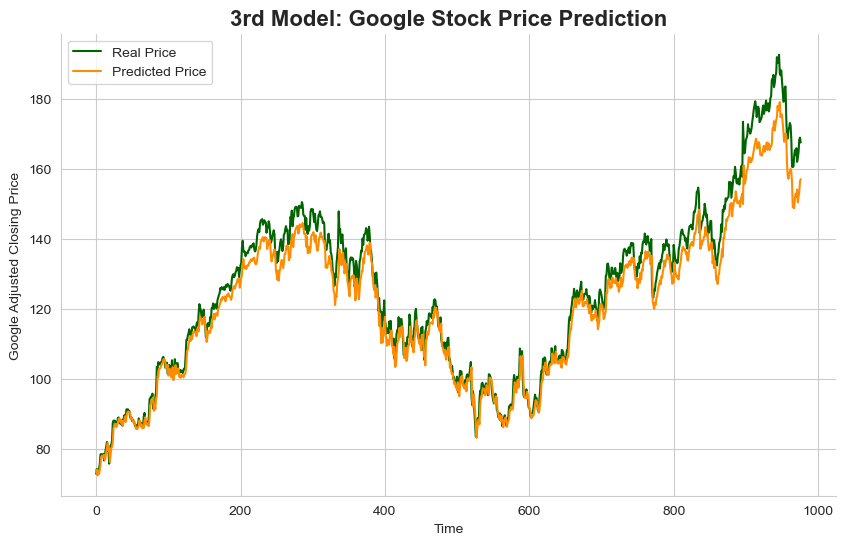

In [54]:
plt.figure(figsize = (10, 6))
sns.set_style('whitegrid')

plt.plot(original3, color = 'darkgreen', label = 'Real Price')
plt.plot(preds3, color = 'darkorange', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Google Adjusted Closing Price')
plt.title('3rd Model: Google Stock Price Prediction', fontweight = 'bold', fontsize = 16)
plt.legend()

sns.despine()
plt.show()

In [86]:
google_model3.save('3rd-Google-LSTM-Model.h5')
print('Model saved to disk!')

Model saved to disk!


In [57]:
#mae
mae = np.mean(np.abs((testY - preds3) / testY)) 

#mape
mape = np.mean(np.abs((testY - preds3) / testY)) * 100

#mse
mse = np.mean((testY - preds3)**2)

#rmse
rmse = np.sqrt(np.mean((testY - preds3)**2))

print(mae, mape, mse, rmse)


74.37167417724253 7437.167417724252 14669.155524102523 121.11628925996091


In [104]:
trial1 = tf.keras.models.load_model('2nd-Google-LSTM-Model.h5')
trial1.summary()

2024-08-22 22:25:43.494027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 22:25:43.495972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 22:25:43.497696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 21, 128)           69120     
                                                                 
 lstm_61 (LSTM)              (None, 64)                49408     
                                                                 
 dense_60 (Dense)            (None, 10)                650       
                                                                 
 dense_61 (Dense)            (None, 1)                 11        
                                                                 
Total params: 119,189
Trainable params: 119,189
Non-trainable params: 0
_________________________________________________________________


2024-08-22 22:25:43.816125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 22:25:43.817910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 22:25:43.819653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [106]:
trial2 = tf.keras.models.load_model('3rd-Google-LSTM-Model.h5')
trial2.summary()

2024-08-22 22:26:12.319313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-22 22:26:12.322004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-22 22:26:12.323527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_152 (LSTM)             (None, 30, 128)           69120     
                                                                 
 lstm_153 (LSTM)             (None, 64)                49408     
                                                                 
 dense_152 (Dense)           (None, 32)                2080      
                                                                 
 dense_153 (Dense)           (None, 1)                 33        
                                                                 
Total params: 120,641
Trainable params: 120,641
Non-trainable params: 0
_________________________________________________________________
